<h1 align="center">IMPLEMENTASI DEEP LEARNING UNTUK REKOMENDASI RESEP MAKANAN BERDASARKAN BAHAN SAYURAN MENGGUNAKAN ALGORITMA CONVOLUTIONAL NEURAL NETWORK (CNN)</h1>

<p align="center">
   LAPORAN TUGAS AKHIR
</p>



<p align="center">
   Muhamad Rendi
</p>

<p align="center">
   5190411597
</p>

<br/>






# **Persiapan Dataset**

## **1. Mengimpor pustaka/modul python yang dibutuhkan**

Menginstall split folders agar bisa membagi rasio data latih dan data testing

In [ ]:
pip install split-folders

I/O python

In [ ]:
import os, shutil, glob, time, pathlib, zipfile, shutil
from pathlib import Path
import os.path

Preproses data

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import splitfolders
import numpy as np
import pandas as pd
from tensorflow import keras
import re

Untuk pembuatan model

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Transfer learning

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

Visualisasi

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px
from PIL import Image

Evaluasi

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

Menautkan dengan Drive untuk mengambil dataset

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

## **2. Menyiapkan Dataset**

Mengekstrak file zip menjadi bentuk folder

In [ ]:
local_zip = '/content/drive/MyDrive/dataset_ta.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

## **3. Pemahaman Data (*Data Understanding*)**

### 3.1 Struktur dataset

Menampung alamat dari dataset

In [ ]:
base_url = '/content/dataset/dataset_ta'

Mengecek hasil ekstrak

In [ ]:
os.listdir(base_url)

['timun',
 'cabai merah',
 'kubis',
 'bawang putih',
 'bawang merah',
 'wortel',
 'jagung',
 'kembang kol',
 'kentang',
 'bombai',
 'cabai hijau',
 'tomat',
 'terong',
 'jahe']

membuat fungsi untuk mengecek jumlah data pada folder dataset

In [ ]:
def cek_jumlah_data(path, data_name):
  total_gambar = 0
  print(f'======================================================================')
  print(f'========================== {data_name} ==============================\n')
  for item in os.listdir(path):
    if len(item) > 7 :
      print('Total Gambar ', item, ' \t: ', len(os.listdir(path + '/' + item)))
      total_gambar += len(os.listdir(path + '/' + item))
    else:
      print('Total Gambar ', item, ' \t\t: ', len(os.listdir(path + '/' + item)))
      total_gambar += len(os.listdir(path + '/' + item))
  print(f'\nTotal Gambar Keseluruhan dari ', data_name ,': ', total_gambar)
  print(f'\n\n')

Mengetahui jumlah data setiap kategori

In [ ]:
cek_jumlah_data(base_url, 'Dataset Awal')

========================== Dataset Awal ==============================

Total Gambar  timun  		:  397
Total Gambar  cabai merah  	:  399
Total Gambar  kubis  		:  434
Total Gambar  bawang putih  	:  461
Total Gambar  bawang merah  	:  367
Total Gambar  wortel  		:  484
Total Gambar  jagung  		:  494
Total Gambar  kembang kol  	:  420
Total Gambar  kentang  		:  414
Total Gambar  bombai  		:  405
Total Gambar  cabai hijau  	:  398
Total Gambar  tomat  		:  400
Total Gambar  terong  		:  557
Total Gambar  jahe  		:  394

Total Gambar Keseluruhan dari  Dataset Awal :  6024





### 3.2 Visualisasi Data

Menampilkan salah satu gambar dataset

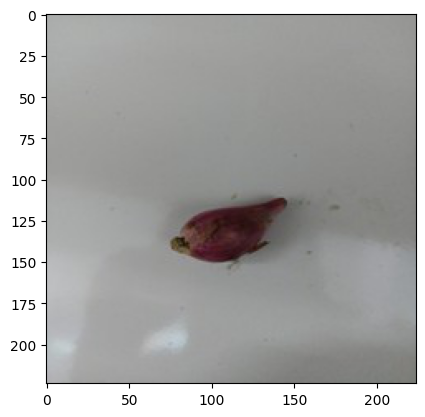

In [ ]:
img = tf.keras.utils.load_img(base_url + '/bawang merah/IMG_20221224_110809_Burst12.jpg')
imgplot = plt.imshow(img)

Menampilkan bar chart jumlah data

In [ ]:
label = []
count = []
for dir in os.listdir(base_url):
  label.append(dir)
  count.append(len(os.listdir(f'/content/dataset/dataset_ta/{dir}')))

fig = px.bar(x=label, y=count, title="Jumlah Data pada Kategori")
fig.show()

Menampilkan data berdasarkan label

In [ ]:
data = Path(base_url)
#glob (kependekan dari global) digunakan untuk mengembalikan semua jalur file yang cocok dengan pola tertentu
dataset_filepaths = list(data.glob(r'**/*.jpg'))

Membuat fungsi untuk mengubah dataset kedalam bentu dataframe untuk visualisasi data berdasarkan label

In [ ]:
def process_img(filepath):
    labels = [str(filepath[i]).split("/")[-2]
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='FilePath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop = True)

    return df

menampung hasil pengubahan dataset ke dataframe kedalam variabel baru

In [ ]:
train_df = process_img(dataset_filepaths)

Menampilkan data

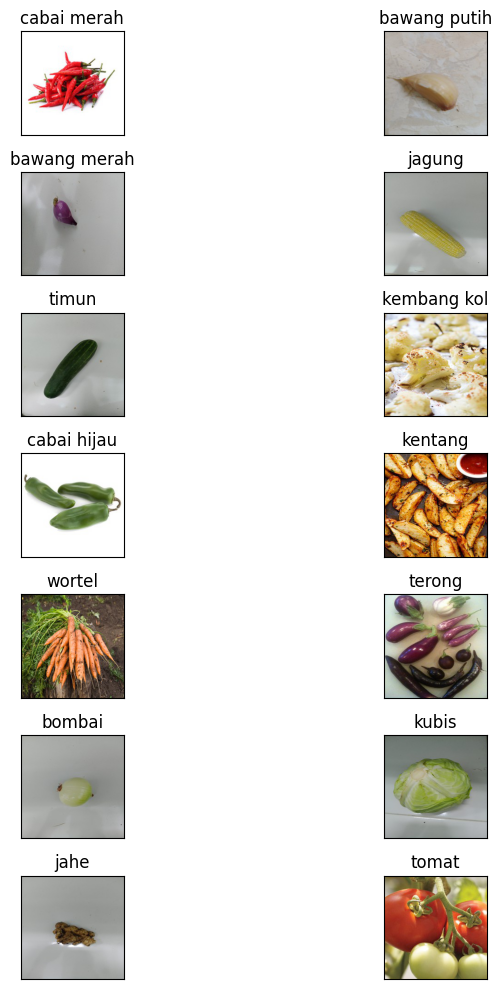

In [ ]:
unique_labels = train_df.copy().drop_duplicates(subset=['Label']).reset_index()
fig, axes = plt.subplots(7,2, figsize=(10,10),subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(unique_labels.FilePath[i]))
    ax.set_title(unique_labels.Label[i], fontsize=12)

plt.tight_layout()
plt.show()

<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>
Dari hasil ekstraksi zip dataset terdapat 16 folder, folder-folder tersebut akan dijadikan label dalam pelatihan model.
</details>

## **4. Persiapan Data** ***(Data Preparation)***

### 4.1 Melakukan pembagian data pada dataset dengan splitfolders

menampung banyaknya pembagian data setiap percobaan

In [ ]:
#menampung banyaknya pembagian data setiap percobaan
percobaan = [70,80,90]

Menampung alamat untuk final dataset untuk setiap percobaan

In [ ]:
alamat_dataset_percobaan = {
    'dataset_70_30' : '/content/dataset/split_70_30',
    'dataset_80_20' : '/content/dataset/split_80_20',
    'dataset_90_10' : '/content/dataset/split_90_10'
}

Membuat fungsi utnuk pembagian dataset setiap percobaan

In [ ]:
def pembagian_dataset_percobaan(destination, ratio):
  splitfolders.ratio(base_url, output=destination, seed= 1337, ratio=(ratio, round((1 - ratio), 2)))

Membagi file menjadi dataset train dan test untuk setiap percobaan

In [ ]:
ratio = 70

for item in alamat_dataset_percobaan:
  pembagian_dataset_percobaan(alamat_dataset_percobaan[item], ratio/100)
  ratio += 10

Copying files: 6024 files [00:01, 5942.79 files/s]
Copying files: 6024 files [00:01, 5808.12 files/s]
Copying files: 6024 files [00:00, 6319.22 files/s]


Melihat jumlah pembagian data training dan testing setiap percobaan

In [ ]:
jumlah_data_model = {
    "train" : {
        'dataset_70_30' : 0,
        'dataset_80_20' : 0,
        'dataset_90_10' : 0
    },

    "val" : {
        'dataset_70_30' : 0,
        'dataset_80_20' : 0,
        'dataset_90_10' : 0
    }
}

def cek_jumlah_data_model(path, data_name):
  total_data_train = 0
  total_data_val = 0
  print(f'======================================================================')
  print(f'========================== {data_name} ==============================\n')
  for item in os.listdir(path):
    if item == 'train':
      for data in os.listdir(path+'/'+item):
        total_data_train += len(os.listdir(f'{path}/{item}/{data}'))
    else:
      for data in os.listdir(path+'/'+item):
        total_data_val += len(os.listdir(f'{path}/{item}/{data}'))
  print(f'\nTotal Data Training {data_name}   : {total_data_train}')
  print(f'\nTotal Data Validation {data_name} : {total_data_val}')
  print(f'\n\n')
  jumlah_data_model["train"][f'{data_name}'] = total_data_train
  jumlah_data_model["val"][f'{data_name}'] = total_data_val

In [ ]:
for item in alamat_dataset_percobaan:
  cek_jumlah_data_model(alamat_dataset_percobaan[item], item)

========================== dataset_70_30 ==============================


Total Data Training dataset_70_30   : 4208

Total Data Validation dataset_70_30 : 1816



========================== dataset_80_20 ==============================


Total Data Training dataset_80_20   : 4815

Total Data Validation dataset_80_20 : 1209



========================== dataset_90_10 ==============================


Total Data Training dataset_90_10   : 5416

Total Data Validation dataset_90_10 : 608





# **Pembagian Data Training dan Testing 70_30**

### **4.2 Membuat augmentasi gambar dengan ImageDataGenerator**

In [ ]:
TOTAL_IMAGE_70_30 = jumlah_data_model['train']['dataset_70_30']
TOTAL_VAL_70_30 = jumlah_data_model['val']['dataset_70_30']

WIDTH = 224
HEIGHT = 224
BATCH_SIZE = 20
EPOCH = 20
STEP_EPOCH = (TOTAL_IMAGE_70_30 - TOTAL_VAL_70_30) / BATCH_SIZE
TRAIN_PATH = "/content/dataset/split_70_30/train"
VALID_PATH = "/content/dataset/split_70_30/val"

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=10,
    vertical_flip=True,
    horizontal_flip=True=
)

valid_datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

### **4.3 Menghasilkan augmentasi data pelatihan dan validasi menggunakan** generator data.

In [ ]:
train_images = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(WIDTH, HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=0)

valid_images = valid_datagen.flow_from_directory(
    VALID_PATH,
    target_size=(WIDTH, HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 4208 images belonging to 14 classes.
Found 1816 images belonging to 14 classes.


## **5. Pembuatan Model**

### 5.1 Membangun arsitektur model

#### 5.1.1 Model dengan MobileNet

In [ ]:
def mobilenet_model(optimizer, lr):
  #	Membangun arsitektur model
  base_mobilenet =  MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(WIDTH, HEIGHT,3),
    pooling='avg',
  )

  base_mobilenet.trainable = False

  inputs = base_mobilenet.input

  x = tf.keras.layers.Dense(512, activation='relu')(base_mobilenet.output)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.10)(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.10)(x)

  outputs = tf.keras.layers.Dense(14, activation='softmax')(x)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  # Optimasi Model
  model.compile(optimizer=optimizer(learning_rate=lr),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

 # CallBack Implementation
  save_model = f'/content/drive/MyDrive/TA/models/70_30/mobilenet_model{str(optimizer)}_{lr}.h5'
  earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
  modelCheckpoint = ModelCheckpoint(save_model, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
  reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=1e-5, mode='min')

  # proses pelatihan
  start = time.time()
  history = model.fit(
      train_images,
      steps_per_epoch=STEP_EPOCH,
      validation_data=valid_images,
      epochs=EPOCH,
      callbacks=[earlyStopping, modelCheckpoint, reducelr],
      verbose = 1
      )

  elapsed = time.time() - start
  elapsed = round(elapsed,2)/60
  print('Computation time = ' + str(elapsed) + ' Minutes')

  return history, model, elapsed

#### 5.1.2 Model dengan VGG

In [ ]:
def vgg_model(optimizer, lr):
  #	Membangun arsitektur model
  base_vgg =  VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(WIDTH, HEIGHT,3),
    pooling='avg',
  )

  base_vgg.trainable = False

  inputs = base_vgg.input

  x = tf.keras.layers.Dense(512, activation='relu')(base_vgg.output)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.10)(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.10)(x)
  outputs = tf.keras.layers.Dense(14, activation='softmax')(x)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  # Optimasi Model
  model.compile(optimizer=optimizer(learning_rate=lr),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

 # CallBack Implementation
  save_model = f'/content/drive/MyDrive/TA/models/70_30/vgg_model{str(optimizer)}_{lr}.h5'
  earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
  modelCheckpoint = ModelCheckpoint(save_model, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
  reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=1e-5, mode='min')

  # proses pelatihan
  start = time.time()
  history = model.fit(
      train_images,
      steps_per_epoch=STEP_EPOCH,
      validation_data=valid_images,
      epochs=EPOCH,
      callbacks=[earlyStopping, modelCheckpoint, reducelr],
      verbose = 1
      )

  elapsed = time.time() - start
  elapsed = round(elapsed,2)/60
  print('Computation time = ' + str(elapsed) + ' Minutes')

  return history, model, elapsed

#### 5.1.3 Model dengan ResNet50V2

In [ ]:
def resnet_model(optimizer, lr):
  #	Membangun arsitektur model
  base_resnet =  ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(WIDTH, HEIGHT,3),
    pooling='avg',
  )

  base_resnet.trainable = False

  inputs = base_resnet.input

  x = tf.keras.layers.Dense(512, activation='relu')(base_resnet.output)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.10)(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.10)(x)

  outputs = tf.keras.layers.Dense(14, activation='softmax')(x)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  # Optimasi Model
  model.compile(optimizer=optimizer(learning_rate=lr),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

 # CallBack Implementation
  save_model = f'/content/drive/MyDrive/TA/models/70_30/resnet_model{str(optimizer)}_{lr}.h5'
  earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
  modelCheckpoint = ModelCheckpoint(save_model, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
  reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=1e-5, mode='min')

  # proses pelatihan
  start = time.time()
  history = model.fit(
      train_images,
      steps_per_epoch=STEP_EPOCH,
      validation_data=valid_images,
      epochs=EPOCH,
      callbacks=[earlyStopping, modelCheckpoint, reducelr],
      verbose = 1
      )

  elapsed = time.time() - start
  elapsed = round(elapsed,2)/60
  print('Computation time = ' + str(elapsed) + ' Minutes')

  return history, model, elapsed

#### 5.1.5 Model dengan buatan sendiri

In [ ]:
def own_model(optimizer, lr):
  #	Membangun arsitektur model
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation = "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(512,activation = "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(14, activation='softmax')
    ])

  # Optimasi Model
  model.compile(optimizer=optimizer(learning_rate=lr),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

 # CallBack Implementation
  save_model = f'/content/drive/MyDrive/TA/models/70_30/own_model{str(optimizer)}_{lr}.h5'
  earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
  modelCheckpoint = ModelCheckpoint(save_model, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
  reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=1e-5, mode='min')

  # proses pelatihan
  start = time.time()
  history = model.fit(
      train_images,
      steps_per_epoch=STEP_EPOCH,
      validation_data=valid_images,
      epochs=EPOCH,
      callbacks=[earlyStopping, modelCheckpoint, reducelr],
      verbose = 1
      )

  elapsed = time.time() - start
  elapsed = round(elapsed,2)/60
  print('Computation time = ' + str(elapsed) + ' Minutes')

  return history, model, elapsed

### 5.2 Melatih Model

Fungsi untuk menampilkan grafik pelatihan

In [ ]:
def plot_accuracy_loss(history, title):
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Accuracy {title}')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.subplot(2,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Loss {title}')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#### 5.2.1 Melatih Model MobileNet

##### 5.2.1.1 Optimizers Adam

In [ ]:
history_mobilenet_adam1, model_mobilenet_adam1, time_mobilenet_adam1 = mobilenet_model(Adam, 0.01)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 0.7308 - accuracy: 0.8266
Epoch 1: val_accuracy improved from -inf to 0.93667, saving model to /content/drive/MyDrive/TA/models/70_30/mobilenet_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.01.h5
119/119 [==============================] - 41s 263ms/step - loss: 0.7308 - accuracy: 0.8266 - val_loss: 0.2373 - val_accuracy: 0.9367 - lr: 0.0100
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 0.2141 - accuracy: 0.9479
Epoch 2: val_accuracy improved from 0.93667 to 0.97137, saving model to /content/drive/MyDrive/TA/models/70_30/mobilenet_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.01.h5
119/119 [==============================] - 30s 253ms/step - loss: 0.2141 - accuracy: 0.9479 - val_loss: 0.1028 - val_accuracy: 0.9714 - lr: 0.0100
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 0.2025 - accurac

In [ ]:
history_mobilenet_adam2, model_mobilenet_adam2, time_mobilenet_adam2  = mobilenet_model(Adam, 0.001)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 0.4435 - accuracy: 0.8854
Epoch 1: val_accuracy improved from -inf to 0.98073, saving model to /content/drive/MyDrive/TA/models/70_30/mobilenet_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.001.h5
119/119 [==============================] - 47s 377ms/step - loss: 0.4435 - accuracy: 0.8854 - val_loss: 0.0684 - val_accuracy: 0.9807 - lr: 0.0010
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 0.9761
Epoch 2: val_accuracy improved from 0.98073 to 0.98348, saving model to /content/drive/MyDrive/TA/models/70_30/mobilenet_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.001.h5
119/119 [==============================] - 41s 340ms/step - loss: 0.0726 - accuracy: 0.9761 - val_loss: 0.0595 - val_accuracy: 0.9835 - lr: 0.0010
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 0.0548 - accuracy: 0.9816
Epoch 3: val_accuracy did not improve from 0.98348


In [ ]:
history_mobilenet_adam3, model_mobilenet_adam3, time_mobilenet_adam3  = mobilenet_model(Adam, 0.0001)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 1.6337 - accuracy: 0.6204
Epoch 1: val_accuracy improved from -inf to 0.91410, saving model to /content/drive/MyDrive/TA/models/70_30/mobilenet_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.0001.h5
119/119 [==============================] - 41s 322ms/step - loss: 1.6337 - accuracy: 0.6204 - val_loss: 0.6856 - val_accuracy: 0.9141 - lr: 1.0000e-04
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 0.4267 - accuracy: 0.9242
Epoch 2: val_accuracy improved from 0.91410 to 0.95319, saving model to /content/drive/MyDrive/TA/models/70_30/mobilenet_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.0001.h5
119/119 [==============================] - 30s 253ms/step - loss: 0.4267 - accuracy: 0.9242 - val_loss: 0.2270 - val_accuracy: 0.9532 - lr: 1.0000e-04
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.9615
Epoch 3: val_accuracy improved from 0.953

Menampilkan grafik pelatihan

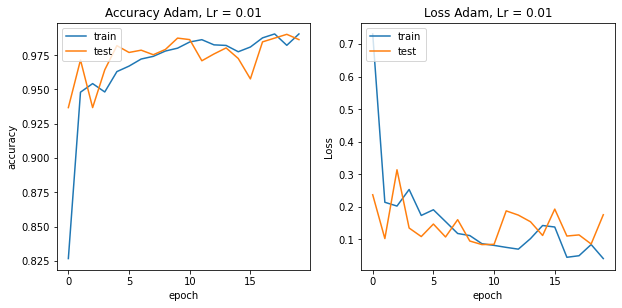

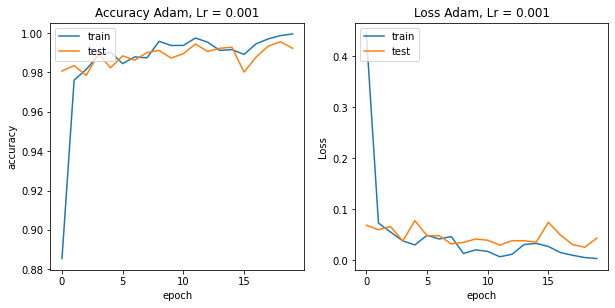

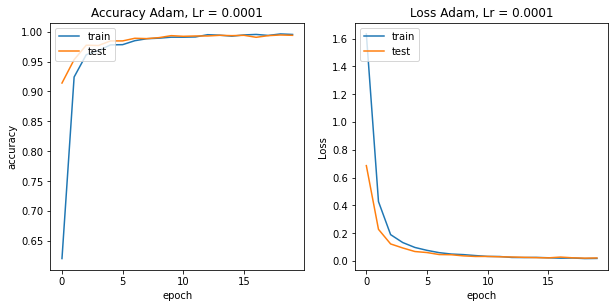

In [ ]:
# Menampilkan grafik pelatihan
train_history = [history_mobilenet_adam1, history_mobilenet_adam2, history_mobilenet_adam3]
train_title = ["Adam, Lr = 0.01", "Adam, Lr = 0.001", "Adam, Lr = 0.0001"]
for hist, title in zip (train_history, train_title):
  plot_accuracy_loss(hist, title)

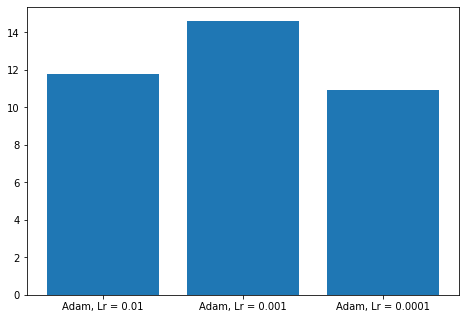

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ["Adam, Lr = 0.01", "Adam, Lr = 0.001", "Adam, Lr = 0.0001"]
times = [time_mobilenet_adam1 ,time_mobilenet_adam2, time_mobilenet_adam3]
ax.bar(labels,times)
plt.show()

Menampilkan grafik waktu melatih model

##### 5.2.1.2 Optimizers RMSProp

In [ ]:
history_mobilenet_rmsprop1, model_mobilenet_rmsprop1, time_mobilenet_rmsprop1 = mobilenet_model(RMSprop, 0.01)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 1.4164 - accuracy: 0.7971
Epoch 1: val_accuracy improved from -inf to 0.91575, saving model to /content/drive/MyDrive/TA/models/70_30/mobilenet_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>_0.01.h5
119/119 [==============================] - 33s 253ms/step - loss: 1.4164 - accuracy: 0.7971 - val_loss: 0.3775 - val_accuracy: 0.9157 - lr: 0.0100
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 0.3476 - accuracy: 0.9321
Epoch 2: val_accuracy improved from 0.91575 to 0.94879, saving model to /content/drive/MyDrive/TA/models/70_30/mobilenet_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>_0.01.h5
119/119 [==============================] - 32s 268ms/step - loss: 0.3476 - accuracy: 0.9321 - val_loss: 0.2378 - val_accuracy: 0.9488 - lr: 0.0100
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 0.3073 - accuracy: 0.9492
Epoch 3: val_accuracy improved from 0.948

In [ ]:
history_mobilenet_rmsprop2, model_mobilenet_rmsprop2, time_mobilenet_rmsprop2 = mobilenet_model(RMSprop, 0.001)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.8865
Epoch 1: val_accuracy improved from -inf to 0.96421, saving model to /content/drive/MyDrive/TA/models/70_30/mobilenet_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>_0.001.h5
119/119 [==============================] - 32s 252ms/step - loss: 0.3845 - accuracy: 0.8865 - val_loss: 0.0945 - val_accuracy: 0.9642 - lr: 0.0010
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.9703
Epoch 2: val_accuracy did not improve from 0.96421
119/119 [==============================] - 30s 255ms/step - loss: 0.0987 - accuracy: 0.9703 - val_loss: 0.1494 - val_accuracy: 0.9521 - lr: 0.0010
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 0.0557 - accuracy: 0.9812
Epoch 3: val_accuracy improved from 0.96421 to 0.98513, saving model to /content/drive/MyDrive/TA/models/70_30/mobilenet_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop

In [ ]:
history_mobilenet_rmsprop3, model_mobilenet_rmsprop3, time_mobilenet_rmsprop3 = mobilenet_model(RMSprop, 0.0001)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 1.4836 - accuracy: 0.6654
Epoch 1: val_accuracy improved from -inf to 0.93062, saving model to /content/drive/MyDrive/TA/models/70_30/mobilenet_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>_0.0001.h5
119/119 [==============================] - 34s 262ms/step - loss: 1.4836 - accuracy: 0.6654 - val_loss: 0.5952 - val_accuracy: 0.9306 - lr: 1.0000e-04
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 0.3805 - accuracy: 0.9326
Epoch 2: val_accuracy improved from 0.93062 to 0.96916, saving model to /content/drive/MyDrive/TA/models/70_30/mobilenet_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>_0.0001.h5
119/119 [==============================] - 30s 250ms/step - loss: 0.3805 - accuracy: 0.9326 - val_loss: 0.1870 - val_accuracy: 0.9692 - lr: 1.0000e-04
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 0.1855 - accuracy: 0.9573
Epoch 3: val_accuracy improve

Menampilkan grafik pelatihan

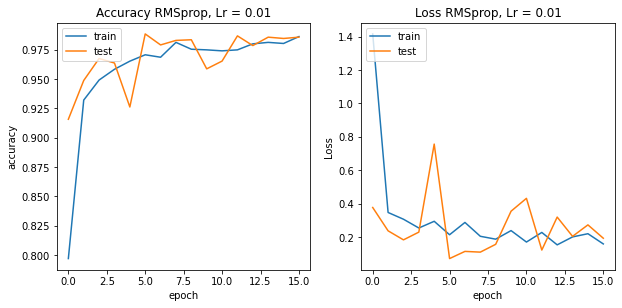

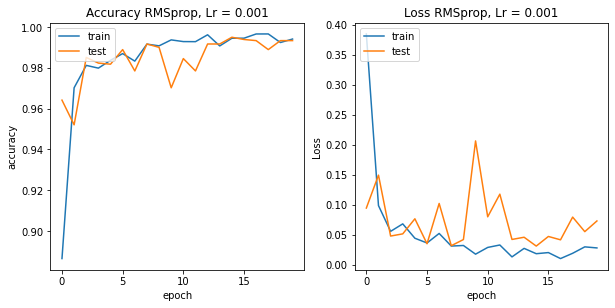

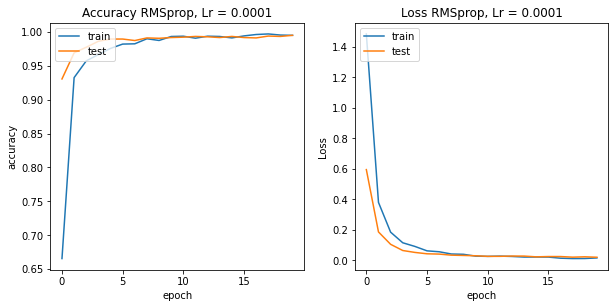

In [ ]:
# Menampilkan grafik pelatihan
train_history = [history_mobilenet_rmsprop1, history_mobilenet_rmsprop2, history_mobilenet_rmsprop3]
train_title = ["RMSprop, Lr = 0.01", "RMSprop, Lr = 0.001", "RMSprop, Lr = 0.0001"]
for hist, title in zip (train_history, train_title):
  plot_accuracy_loss(hist, title)

Menampilkan grafik waktu pelatihan model

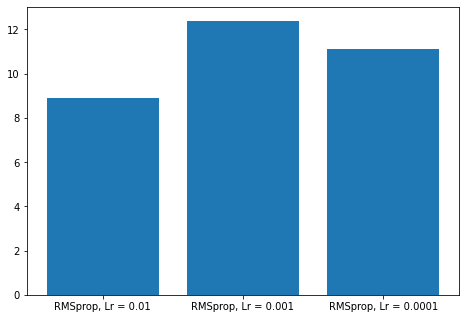

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ["RMSprop, Lr = 0.01", "RMSprop, Lr = 0.001", "RMSprop, Lr = 0.0001"]
times = [time_mobilenet_rmsprop1, time_mobilenet_rmsprop2, time_mobilenet_rmsprop3]
ax.bar(labels,times)
plt.show()

#### 5.2.2 Melatih Model VGG

##### 5.2.2.1 Optimizers Adam

In [ ]:
history_vgg_adam1, model_vgg_adam1, time_vgg_adam1 = vgg_model(Adam, 0.01)

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 1.1759 - accuracy: 0.6117
Epoch 1: val_accuracy improved from -inf to 0.81443, saving model to /content/drive/MyDrive/TA/models/70_30/vgg_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.01.h5
119/119 [==============================] - 46s 358ms/step - loss: 1.1759 - accuracy: 0.6117 - val_loss: 0.5490 - val_accuracy: 0.8144 - lr: 0.0100
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 0.4093 - accuracy: 0.8727
Epoch 2: val_accuracy improved from 0.81443 to 0.90363, saving model to /content/drive/MyDrive/TA/models/70_30/vgg_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.01.h5
119/119 [==============================] - 43s 359ms/step - loss: 0.4093 - accuracy: 0.8727 - val_loss: 0.3333 - val_accuracy: 0.9036 - lr: 0.0100
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.8979


In [ ]:
history_vgg_adam2, model_vgg_adam2, time_vgg_adam2 = vgg_model(Adam, 0.001)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 1.7931 - accuracy: 0.4791
Epoch 1: val_accuracy improved from -inf to 0.87059, saving model to /content/drive/MyDrive/TA/models/70_30/vgg_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.001.h5
119/119 [==============================] - 50s 418ms/step - loss: 1.7931 - accuracy: 0.4791 - val_loss: 0.8107 - val_accuracy: 0.8706 - lr: 0.0010
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 0.5955 - accuracy: 0.8685
Epoch 2: val_accuracy improved from 0.87059 to 0.92070, saving model to /content/drive/MyDrive/TA/models/70_30/vgg_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.001.h5
119/119 [==============================] - 42s 352ms/step - loss: 0.5955 - accuracy: 0.8685 - val_loss: 0.3725 - val_accuracy: 0.9207 - lr: 0.0010
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 0.3558 - accuracy: 0.9121
Epoch 3: val_accuracy improved from 0.92070 to 0.94769, saving 

In [ ]:
history_vgg_adam3, model_vgg_adam3, time_vgg_adam3 = vgg_model(Adam, 0.0001)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 2.5610 - accuracy: 0.1729
Epoch 1: val_accuracy improved from -inf to 0.27148, saving model to /content/drive/MyDrive/TA/models/70_30/vgg_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.0001.h5
119/119 [==============================] - 43s 353ms/step - loss: 2.5610 - accuracy: 0.1729 - val_loss: 2.4049 - val_accuracy: 0.2715 - lr: 1.0000e-04
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 2.3051 - accuracy: 0.3408
Epoch 2: val_accuracy improved from 0.27148 to 0.55176, saving model to /content/drive/MyDrive/TA/models/70_30/vgg_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.0001.h5
119/119 [==============================] - 42s 348ms/step - loss: 2.3051 - accuracy: 0.3408 - val_loss: 2.0945 - val_accuracy: 0.5518 - lr: 1.0000e-04
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 2.0019 - accuracy: 0.5204
Epoch 3: val_accuracy improved from 0.55176 to 0.7092

Menampilkan grafik pelatihan

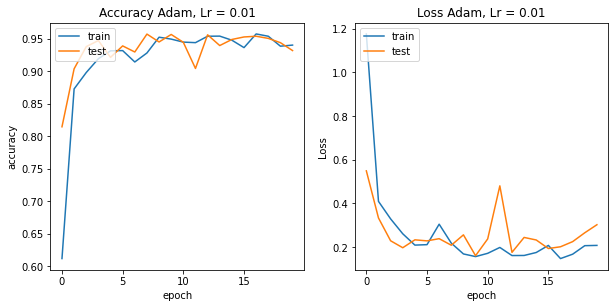

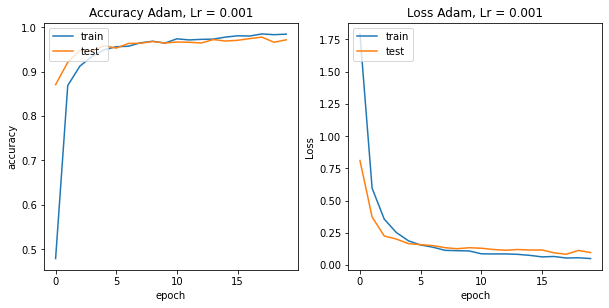

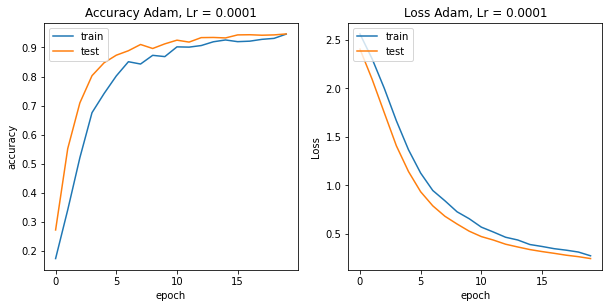

In [ ]:
# Menampilkan grafik pelatihan
train_history = [history_vgg_adam1, history_vgg_adam2, history_vgg_adam3]
train_title = ["Adam, Lr = 0.01", "Adam, Lr = 0.001", "Adam, Lr = 0.0001"]
for hist, title in zip (train_history, train_title):
  plot_accuracy_loss(hist, title)

Menampilkan grafik waktu pelatihan model

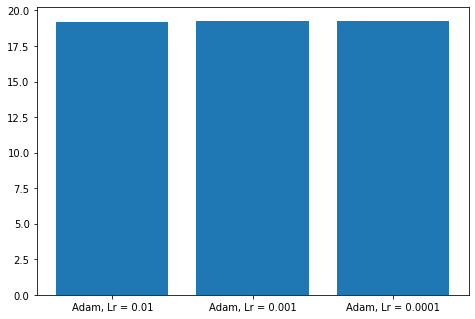

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ["Adam, Lr = 0.01", "Adam, Lr = 0.001", "Adam, Lr = 0.0001"]
times = [time_vgg_adam1 ,time_vgg_adam2, time_vgg_adam3]
ax.bar(labels,times)
plt.show()

##### 5.2.2.2 Optimizers RMSprop

In [ ]:
history_vgg_rmsprop1, model_vgg_rmsprop1, time_vgg_rmsprop1 = vgg_model(RMSprop, 0.01)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 1.8861 - accuracy: 0.4246
Epoch 1: val_accuracy improved from -inf to 0.73183, saving model to /content/drive/MyDrive/TA/models/70_30/vgg_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>_0.01.h5
119/119 [==============================] - 41s 340ms/step - loss: 1.8861 - accuracy: 0.4246 - val_loss: 0.8469 - val_accuracy: 0.7318 - lr: 0.0100
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.7697
Epoch 2: val_accuracy improved from 0.73183 to 0.88051, saving model to /content/drive/MyDrive/TA/models/70_30/vgg_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>_0.01.h5
119/119 [==============================] - 41s 342ms/step - loss: 0.6939 - accuracy: 0.7697 - val_loss: 0.3803 - val_accuracy: 0.8805 - lr: 0.0100
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 0.4909 - accuracy: 0.8539
Epoch 3: val_accuracy improved from 0.88051 to 0.9163

In [ ]:
history_vgg_rmsprop2, model_vgg_rmsprop2, time_vgg_rmsprop2 = vgg_model(RMSprop, 0.001)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 1.6672 - accuracy: 0.5188
Epoch 1: val_accuracy improved from -inf to 0.76817, saving model to /content/drive/MyDrive/TA/models/70_30/vgg_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>_0.001.h5
119/119 [==============================] - 41s 335ms/step - loss: 1.6672 - accuracy: 0.5188 - val_loss: 0.8668 - val_accuracy: 0.7682 - lr: 0.0010
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 0.6202 - accuracy: 0.8550
Epoch 2: val_accuracy improved from 0.76817 to 0.90143, saving model to /content/drive/MyDrive/TA/models/70_30/vgg_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>_0.001.h5
119/119 [==============================] - 41s 346ms/step - loss: 0.6202 - accuracy: 0.8550 - val_loss: 0.3999 - val_accuracy: 0.9014 - lr: 0.0010
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 0.3538 - accuracy: 0.9104
Epoch 3: val_accuracy improved from 0.90143 to 0.91

In [ ]:
history_vgg_rmsprop3, model_vgg_rmsprop3, time_vgg_rmsprop3 = vgg_model(RMSprop, 0.0001)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 2.5532 - accuracy: 0.1788
Epoch 1: val_accuracy improved from -inf to 0.24890, saving model to /content/drive/MyDrive/TA/models/70_30/vgg_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>_0.0001.h5
119/119 [==============================] - 41s 335ms/step - loss: 2.5532 - accuracy: 0.1788 - val_loss: 2.4216 - val_accuracy: 0.2489 - lr: 1.0000e-04
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 2.3377 - accuracy: 0.3673
Epoch 2: val_accuracy improved from 0.24890 to 0.39868, saving model to /content/drive/MyDrive/TA/models/70_30/vgg_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>_0.0001.h5
119/119 [==============================] - 42s 348ms/step - loss: 2.3377 - accuracy: 0.3673 - val_loss: 2.1785 - val_accuracy: 0.3987 - lr: 1.0000e-04
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 2.1025 - accuracy: 0.4396
Epoch 3: val_accuracy improved from 0.398

Menampilkan grafik pelatihan

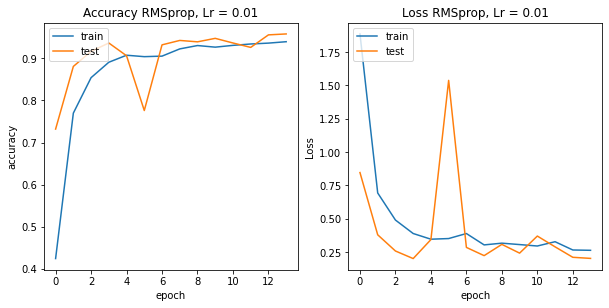

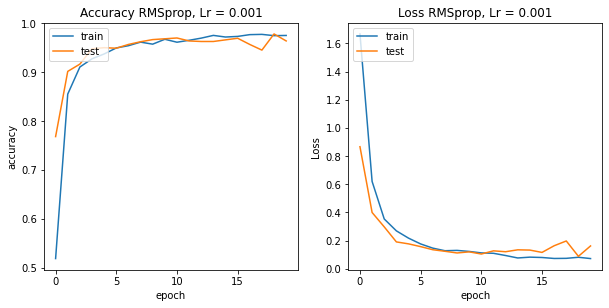

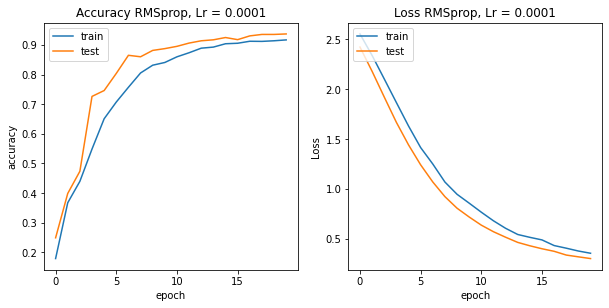

In [ ]:
# Menampilkan grafik pelatihan
train_history = [history_vgg_rmsprop1, history_vgg_rmsprop2, history_vgg_rmsprop3]
train_title = ["RMSprop, Lr = 0.01", "RMSprop, Lr = 0.001", "RMSprop, Lr = 0.0001"]
for hist, title in zip (train_history, train_title):
  plot_accuracy_loss(hist, title)

Menampilkan grafik waktu pelatihan model

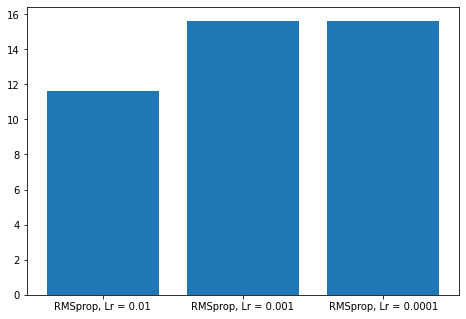

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ["RMSprop, Lr = 0.01", "RMSprop, Lr = 0.001", "RMSprop, Lr = 0.0001"]
times = [time_vgg_rmsprop1 ,time_vgg_rmsprop2, time_vgg_rmsprop3]
ax.bar(labels,times)
plt.show()

#### 5.2.3 Melatih Model ResNet

##### 5.2.3.1 Optmizers Adam

In [ ]:
history_resnet_adam1, model_resnet_adam1, time_resnet_adam1 = resnet_model(Adam, 0.01)

94668760/94668760 [==============================] - 5s 0us/step
Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 0.7843 - accuracy: 0.8032
Epoch 1: val_accuracy improved from -inf to 0.92952, saving model to /content/drive/MyDrive/TA/models/70_30/resnet_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.01.h5
119/119 [==============================] - 38s 294ms/step - loss: 0.7843 - accuracy: 0.8032 - val_loss: 0.2109 - val_accuracy: 0.9295 - lr: 0.0100
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 0.2836 - accuracy: 0.9225
Epoch 2: val_accuracy improved from 0.92952 to 0.93172, saving model to /content/drive/MyDrive/TA/models/70_30/resnet_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.01.h5
119/119 [==============================] - 35s 289ms/step - loss: 0.2836 - accuracy: 0.9225 - val_loss: 0.3475 - val_accuracy: 0.9317 - lr: 0.0100
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 0.2979 - accuracy: 0

In [ ]:
history_resnet_adam2, model_resnet_adam2, time_resnet_adam2 = resnet_model(Adam, 0.001)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.8652
Epoch 1: val_accuracy improved from -inf to 0.93888, saving model to /content/drive/MyDrive/TA/models/70_30/resnet_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.001.h5
119/119 [==============================] - 38s 299ms/step - loss: 0.4583 - accuracy: 0.8652 - val_loss: 0.1696 - val_accuracy: 0.9389 - lr: 0.0010
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 0.1287 - accuracy: 0.9602
Epoch 2: val_accuracy improved from 0.93888 to 0.94548, saving model to /content/drive/MyDrive/TA/models/70_30/resnet_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.001.h5
119/119 [==============================] - 35s 291ms/step - loss: 0.1287 - accuracy: 0.9602 - val_loss: 0.1772 - val_accuracy: 0.9455 - lr: 0.0010
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 0.0985 - accuracy: 0.9700
Epoch 3: val_accuracy improved from 0.94548 to 0.96035, s

In [ ]:
history_resnet_adam3, model_resnet_adam3, time_resnet_adam3 = resnet_model(Adam, 0.0001)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 1.4246 - accuracy: 0.6304
Epoch 1: val_accuracy improved from -inf to 0.87445, saving model to /content/drive/MyDrive/TA/models/70_30/resnet_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.0001.h5
119/119 [==============================] - 40s 312ms/step - loss: 1.4246 - accuracy: 0.6304 - val_loss: 0.5658 - val_accuracy: 0.8744 - lr: 1.0000e-04
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 0.4219 - accuracy: 0.9042
Epoch 2: val_accuracy improved from 0.87445 to 0.93833, saving model to /content/drive/MyDrive/TA/models/70_30/resnet_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.0001.h5
119/119 [==============================] - 36s 297ms/step - loss: 0.4219 - accuracy: 0.9042 - val_loss: 0.2589 - val_accuracy: 0.9383 - lr: 1.0000e-04
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.9447
Epoch 3: val_accuracy improved from 0.93833 to 

Menampilkan grafik pelatihan

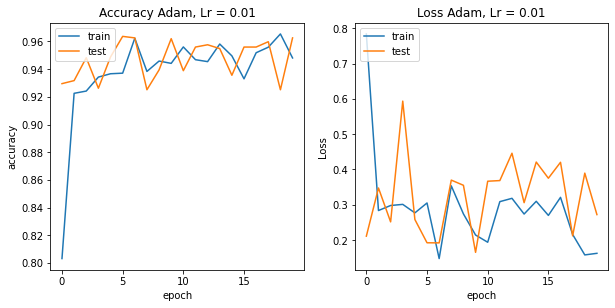

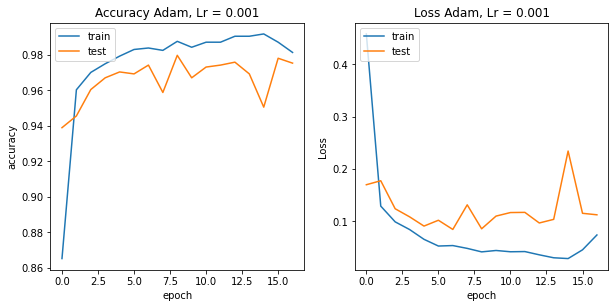

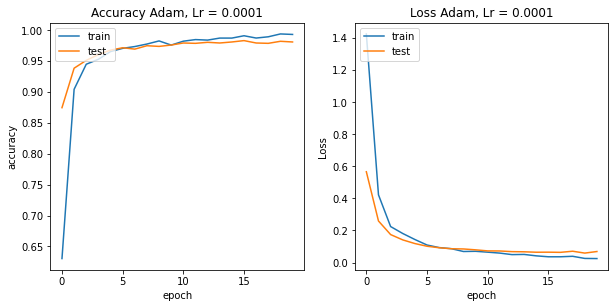

In [ ]:
# Menampilkan grafik pelatihan
train_history = [history_resnet_adam1, history_resnet_adam2, history_resnet_adam3]
train_title = ["Adam, Lr = 0.01", "Adam, Lr = 0.001", "Adam, Lr = 0.0001"]
for hist, title in zip (train_history, train_title):
  plot_accuracy_loss(hist, title)

Menampilkan grafik waktu pelatihan model

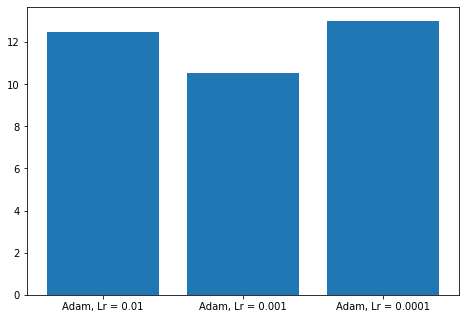

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ["Adam, Lr = 0.01", "Adam, Lr = 0.001", "Adam, Lr = 0.0001"]
times = [time_resnet_adam1 ,time_resnet_adam2, time_resnet_adam3]
ax.bar(labels,times)
plt.show()

##### 5.2.5.2 Optimizers RMSprop

In [ ]:
history_resnet_rmsprop1, model_resnet_rmsprop1, time_resnet_rmsprop1 = resnet_model(RMSprop, 0.01)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 1.7554 - accuracy: 0.7090
Epoch 1: val_accuracy improved from -inf to 0.83315, saving model to /content/drive/MyDrive/TA/models/70_30/resnet_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>_0.01.h5
119/119 [==============================] - 38s 294ms/step - loss: 1.7554 - accuracy: 0.7090 - val_loss: 1.3451 - val_accuracy: 0.8331 - lr: 0.0100
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 0.4797 - accuracy: 0.8954
Epoch 2: val_accuracy improved from 0.83315 to 0.92401, saving model to /content/drive/MyDrive/TA/models/70_30/resnet_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>_0.01.h5
119/119 [==============================] - 36s 298ms/step - loss: 0.4797 - accuracy: 0.8954 - val_loss: 0.5562 - val_accuracy: 0.9240 - lr: 0.0100
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 0.3697 - accuracy: 0.9204
Epoch 3: val_accuracy did not improve from 0.92

In [ ]:
history_resnet_rmsprop2, model_resnet_rmsprop2, time_resnet_rmsprop2 = resnet_model(RMSprop, 0.001)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 0.4619 - accuracy: 0.8635
Epoch 1: val_accuracy improved from -inf to 0.94879, saving model to /content/drive/MyDrive/TA/models/70_30/resnet_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>_0.001.h5
119/119 [==============================] - 38s 295ms/step - loss: 0.4619 - accuracy: 0.8635 - val_loss: 0.1666 - val_accuracy: 0.9488 - lr: 0.0010
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 0.1623 - accuracy: 0.9546
Epoch 2: val_accuracy improved from 0.94879 to 0.96806, saving model to /content/drive/MyDrive/TA/models/70_30/resnet_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>_0.001.h5
119/119 [==============================] - 36s 301ms/step - loss: 0.1623 - accuracy: 0.9546 - val_loss: 0.0902 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 0.1171 - accuracy: 0.9673
Epoch 3: val_accuracy improved from 0.96806 t

In [ ]:
history_resnet_rmsprop3, model_resnet_rmsprop3, time_resnet_rmsprop3 = resnet_model(RMSprop, 0.0001)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 1.3504 - accuracy: 0.6801
Epoch 1: val_accuracy improved from -inf to 0.87996, saving model to /content/drive/MyDrive/TA/models/70_30/resnet_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>_0.0001.h5
119/119 [==============================] - 39s 300ms/step - loss: 1.3504 - accuracy: 0.6801 - val_loss: 0.5454 - val_accuracy: 0.8800 - lr: 1.0000e-04
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 0.4192 - accuracy: 0.8963
Epoch 2: val_accuracy improved from 0.87996 to 0.93337, saving model to /content/drive/MyDrive/TA/models/70_30/resnet_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>_0.0001.h5
119/119 [==============================] - 38s 316ms/step - loss: 0.4192 - accuracy: 0.8963 - val_loss: 0.2498 - val_accuracy: 0.9334 - lr: 1.0000e-04
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 0.2252 - accuracy: 0.9418
Epoch 3: val_accuracy improved from

Menampilkan grafik pelatihan

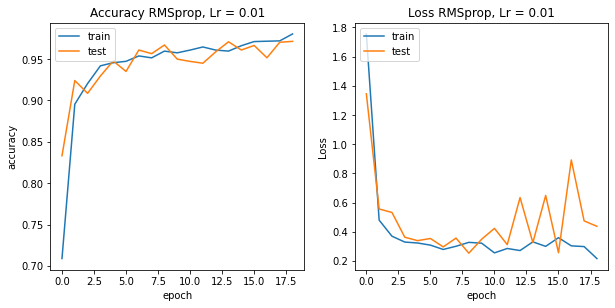

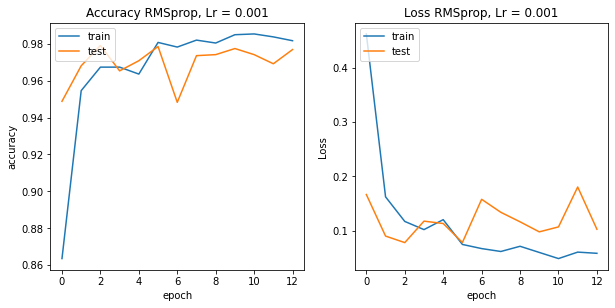

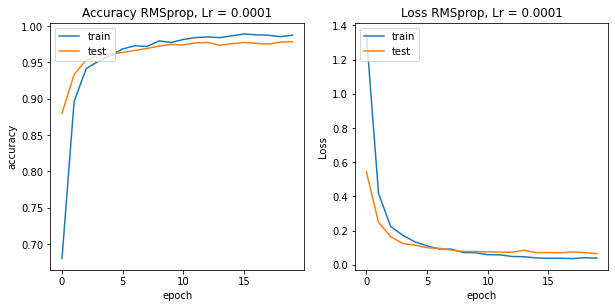

In [ ]:
# Menampilkan grafik pelatihan
train_history = [history_resnet_rmsprop1, history_resnet_rmsprop2, history_resnet_rmsprop3]
train_title = ["RMSprop, Lr = 0.01", "RMSprop, Lr = 0.001", "RMSprop, Lr = 0.0001"]
for hist, title in zip (train_history, train_title):
  plot_accuracy_loss(hist, title)

Menampilkan grafik waktu pelatihan model

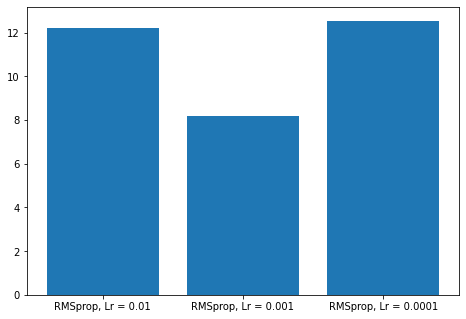

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ["RMSprop, Lr = 0.01", "RMSprop, Lr = 0.001", "RMSprop, Lr = 0.0001"]
times = [time_resnet_rmsprop1 ,time_resnet_rmsprop2, time_resnet_rmsprop3]
ax.bar(labels,times)
plt.show()

#### 5.2.5 Melatih Model rancangan sendiri

##### 5.2.4.1 Optimizers Adam

In [ ]:
history_own_adam1, model_own_adam1, time_own_adam1 = own_model(Adam, 0.01)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 39.3760 - accuracy: 0.3271
Epoch 1: val_accuracy improved from -inf to 0.17566, saving model to /content/drive/MyDrive/TA/models/70_30/own_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.01.h5
119/119 [==============================] - 55s 367ms/step - loss: 39.3760 - accuracy: 0.3271 - val_loss: 35.0068 - val_accuracy: 0.1757 - lr: 0.0100
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 2.0280 - accuracy: 0.3700
Epoch 2: val_accuracy improved from 0.17566 to 0.32764, saving model to /content/drive/MyDrive/TA/models/70_30/own_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.01.h5
119/119 [==============================] - 32s 266ms/step - loss: 2.0280 - accuracy: 0.3700 - val_loss: 4.0196 - val_accuracy: 0.3276 - lr: 0.0100
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 1.9239 - accuracy: 0.4154
Epoch 3: val_accuracy improved from 0.32764 to 0.51211, saving

In [ ]:
history_own_adam2, model_own_adam2, time_own_adam2 = own_model(Adam, 0.001)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 5.6685 - accuracy: 0.4683
Epoch 1: val_accuracy improved from -inf to 0.13656, saving model to /content/drive/MyDrive/TA/models/70_30/own_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.001.h5
119/119 [==============================] - 33s 264ms/step - loss: 5.6685 - accuracy: 0.4683 - val_loss: 12.6694 - val_accuracy: 0.1366 - lr: 0.0010
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 3.4708 - accuracy: 0.6646
Epoch 2: val_accuracy improved from 0.13656 to 0.17676, saving model to /content/drive/MyDrive/TA/models/70_30/own_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.001.h5
119/119 [==============================] - 32s 268ms/step - loss: 3.4708 - accuracy: 0.6646 - val_loss: 10.0878 - val_accuracy: 0.1768 - lr: 0.0010
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 1.9708 - accuracy: 0.7278
Epoch 3: val_accuracy improved from 0.17676 to 0.48403, savin

In [ ]:
history_own_adam3, model_own_adam3, time_own_adam3 = own_model(Adam, 0.0001)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 1.8708 - accuracy: 0.5008
Epoch 1: val_accuracy improved from -inf to 0.07654, saving model to /content/drive/MyDrive/TA/models/70_30/own_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.0001.h5
119/119 [==============================] - 34s 278ms/step - loss: 1.8708 - accuracy: 0.5008 - val_loss: 6.3192 - val_accuracy: 0.0765 - lr: 1.0000e-04
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 0.9680 - accuracy: 0.7154
Epoch 2: val_accuracy did not improve from 0.07654
119/119 [==============================] - 32s 263ms/step - loss: 0.9680 - accuracy: 0.7154 - val_loss: 6.4202 - val_accuracy: 0.0765 - lr: 1.0000e-04
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 0.7209 - accuracy: 0.7825
Epoch 3: val_accuracy improved from 0.07654 to 0.13656, saving model to /content/drive/MyDrive/TA/models/70_30/own_model<class 'keras.optimizers.optimizer_v2.adam.Adam'>_0.0001.h5
11

Menampilkan grafik pelatihan

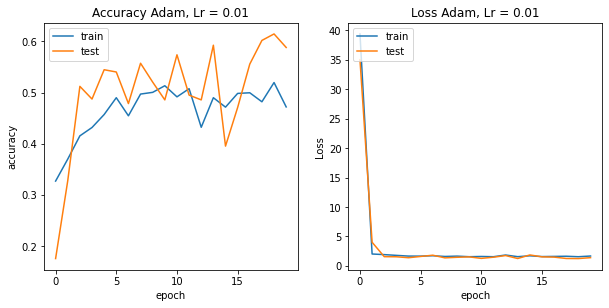

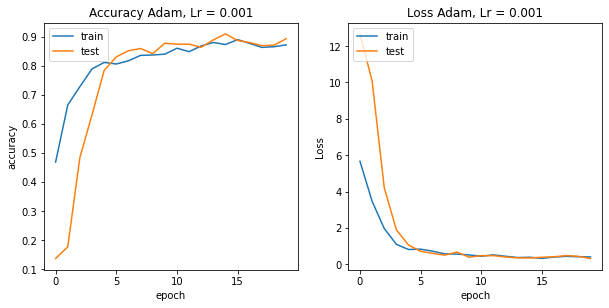

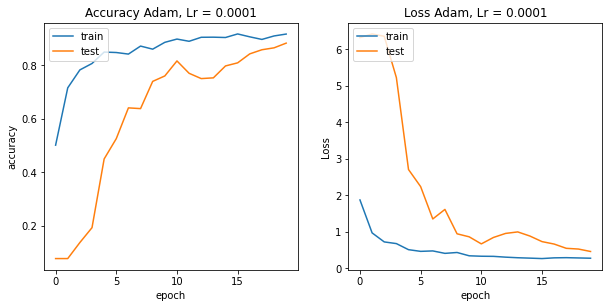

In [ ]:
# Menampilkan grafik pelatihan
train_history = [history_own_adam1, history_own_adam2, history_own_adam3]
train_title = ["Adam, Lr = 0.01", "Adam, Lr = 0.001", "Adam, Lr = 0.0001"]
for hist, title in zip (train_history, train_title):
  plot_accuracy_loss(hist, title)

Menampilkan grafik waktu pelatihan model

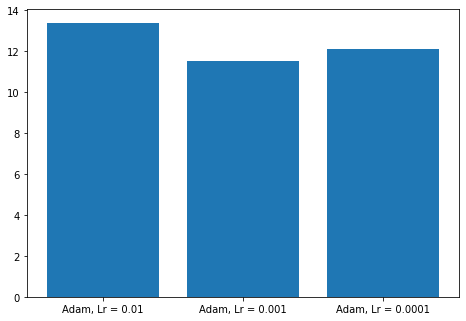

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ["Adam, Lr = 0.01", "Adam, Lr = 0.001", "Adam, Lr = 0.0001"]
times = [time_own_adam1 ,time_own_adam2, time_own_adam3]
ax.bar(labels,times)
plt.show()

##### **5.2.4.2 Optimizers RMSprop**

In [ ]:
history_own_rmsprop1, model_own_rmsprop1, time_own_rmsprop1 = own_model(RMSprop, 0.01)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 46.5625 - accuracy: 0.1700
Epoch 1: val_accuracy improved from -inf to 0.13106, saving model to /content/drive/MyDrive/TA/models/70_30/own_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>_0.01.h5
119/119 [==============================] - 32s 262ms/step - loss: 46.5625 - accuracy: 0.1700 - val_loss: 97.5528 - val_accuracy: 0.1311 - lr: 0.0100
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 2.9400 - accuracy: 0.0963
Epoch 2: val_accuracy did not improve from 0.13106
119/119 [==============================] - 31s 256ms/step - loss: 2.9400 - accuracy: 0.0963 - val_loss: 7.8838 - val_accuracy: 0.1118 - lr: 0.0100
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 2.6343 - accuracy: 0.0934
Epoch 3: val_accuracy did not improve from 0.13106
119/119 [==============================] - 31s 256ms/step - loss: 2.6343 - accuracy: 0.0934 - val_loss: 2.6337 - val_accuracy: 0.092

In [ ]:
history_own_rmsprop2, model_own_rmsprop2, time_own_rmsprop2 = own_model(RMSprop, 0.001)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 9.8074 - accuracy: 0.4325
Epoch 1: val_accuracy improved from -inf to 0.23183, saving model to /content/drive/MyDrive/TA/models/70_30/own_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>_0.001.h5
119/119 [==============================] - 33s 264ms/step - loss: 9.8074 - accuracy: 0.4325 - val_loss: 4.2234 - val_accuracy: 0.2318 - lr: 0.0010
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 4.1032 - accuracy: 0.6017
Epoch 2: val_accuracy did not improve from 0.23183
119/119 [==============================] - 33s 274ms/step - loss: 4.1032 - accuracy: 0.6017 - val_loss: 14.6822 - val_accuracy: 0.1619 - lr: 0.0010
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 2.3132 - accuracy: 0.6855
Epoch 3: val_accuracy did not improve from 0.23183
119/119 [==============================] - 31s 259ms/step - loss: 2.3132 - accuracy: 0.6855 - val_loss: 9.6649 - val_accuracy: 0.1944

In [ ]:
history_own_rmsprop3, model_own_rmsprop3, time_own_rmsprop3 = own_model(RMSprop, 0.0001)

Epoch 1/20
120/119 [==============================] - ETA: 0s - loss: 1.8978 - accuracy: 0.4942
Epoch 1: val_accuracy improved from -inf to 0.07654, saving model to /content/drive/MyDrive/TA/models/70_30/own_model<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>_0.0001.h5
119/119 [==============================] - 32s 262ms/step - loss: 1.8978 - accuracy: 0.4942 - val_loss: 5.6822 - val_accuracy: 0.0765 - lr: 1.0000e-04
Epoch 2/20
120/119 [==============================] - ETA: 0s - loss: 1.0749 - accuracy: 0.7165
Epoch 2: val_accuracy did not improve from 0.07654
119/119 [==============================] - 31s 262ms/step - loss: 1.0749 - accuracy: 0.7165 - val_loss: 10.0045 - val_accuracy: 0.0765 - lr: 1.0000e-04
Epoch 3/20
120/119 [==============================] - ETA: 0s - loss: 0.7938 - accuracy: 0.7767
Epoch 3: val_accuracy did not improve from 0.07654
119/119 [==============================] - 33s 274ms/step - loss: 0.7938 - accuracy: 0.7767 - val_loss: 11.3444 - val_accura

Menampilkan grafik pelatihan

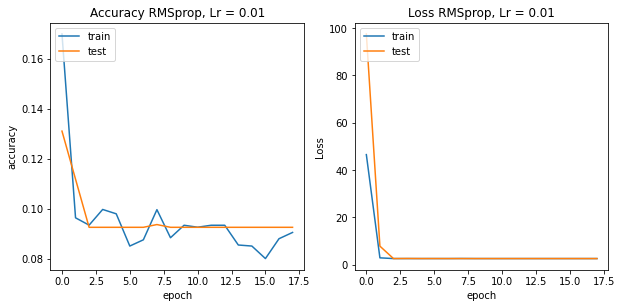

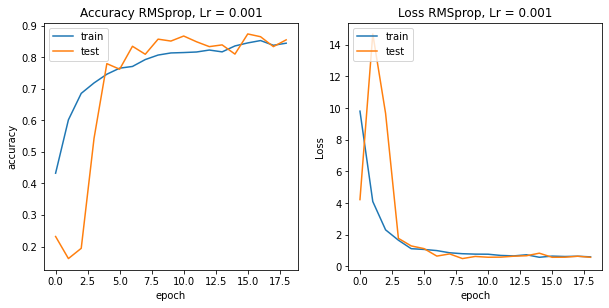

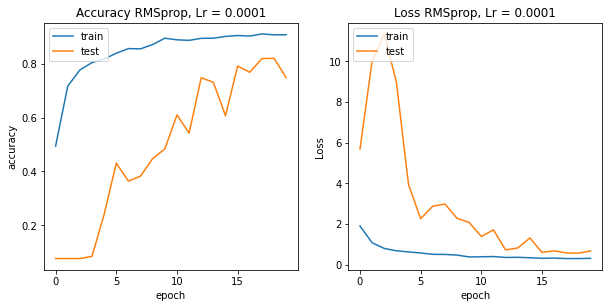

In [ ]:
# Menampilkan grafik pelatihan
train_history = [history_own_rmsprop1, history_own_rmsprop2, history_own_rmsprop3]
train_title = ["RMSprop, Lr = 0.01", "RMSprop, Lr = 0.001", "RMSprop, Lr = 0.0001"]
for hist, title in zip (train_history, train_title):
  plot_accuracy_loss(hist, title)

Menampilkan grafik waktu pelatihan model

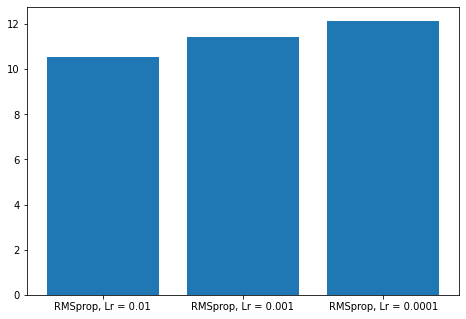

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ["RMSprop, Lr = 0.01", "RMSprop, Lr = 0.001", "RMSprop, Lr = 0.0001"]
times = [time_own_rmsprop1 ,time_own_rmsprop2, time_own_rmsprop3]
ax.bar(labels,times)
plt.show()

## **6. EvaluasiModel**

### 6.1 Load Model

Menghilangkan karakter ' agar model dapat dipanggil

In [ ]:
path_70_30 = '/content/drive/MyDrive/TA/models/70_30'
model_list = os.listdir(path_70_30)

for url in model_list:
  if '.ipynb_checkpoints' not in url:
    os.rename(os.path.join(path_70_30, url), os.path.join(path_70_30, re.sub(r"[']", "", url)))

memindahkan model yang disimpan di drive peneliti ke folder local colab

In [ ]:
os.mkdir('models/')
os.mkdir('models/70_30')
!cp /content/drive/MyDrive/TA/models/70_30/* models/70_30

#### 6.1.1 Model MobileNet

In [ ]:
model_mobilenet_adam1_70_30 = keras.models.load_model('/content/models/70_30/mobilenet_model<class keras.optimizers.optimizer_v2.adam.Adam>_0.01.h5')
model_mobilenet_adam2_70_30 = keras.models.load_model('/content/models/70_30/mobilenet_model<class keras.optimizers.optimizer_v2.adam.Adam>_0.001.h5')
model_mobilenet_adam3_70_30 = keras.models.load_model('/content/models/70_30/mobilenet_model<class keras.optimizers.optimizer_v2.adam.Adam>_0.0001.h5')

In [ ]:
model_mobilenet_rmsprop1_70_30 = keras.models.load_model('/content/models/70_30/mobilenet_model<class keras.optimizers.optimizer_v2.rmsprop.RMSprop>_0.01.h5')
model_mobilenet_rmsprop2_70_30 = keras.models.load_model('/content/models/70_30/mobilenet_model<class keras.optimizers.optimizer_v2.rmsprop.RMSprop>_0.001.h5')
model_mobilenet_rmsprop3_70_30 = keras.models.load_model('/content/models/70_30/mobilenet_model<class keras.optimizers.optimizer_v2.rmsprop.RMSprop>_0.0001.h5')

#### 6.1.2 Model VGG

In [ ]:
model_vgg_adam1_70_30 = keras.models.load_model('/content/models/70_30/vgg_model<class keras.optimizers.optimizer_v2.adam.Adam>_0.01.h5')
model_vgg_adam2_70_30 = keras.models.load_model('/content/models/70_30/vgg_model<class keras.optimizers.optimizer_v2.adam.Adam>_0.001.h5')
model_vgg_adam3_70_30 = keras.models.load_model('/content/models/70_30/vgg_model<class keras.optimizers.optimizer_v2.adam.Adam>_0.0001.h5')

In [ ]:
model_vgg_rmsprop1_70_30 = keras.models.load_model('/content/models/70_30/vgg_model<class keras.optimizers.optimizer_v2.rmsprop.RMSprop>_0.01.h5')
model_vgg_rmsprop2_70_30 = keras.models.load_model('/content/models/70_30/vgg_model<class keras.optimizers.optimizer_v2.rmsprop.RMSprop>_0.001.h5')
model_vgg_rmsprop3_70_30 = keras.models.load_model('/content/models/70_30/vgg_model<class keras.optimizers.optimizer_v2.rmsprop.RMSprop>_0.0001.h5')

#### 6.1.3 Model Resnet

In [ ]:
model_resnet_adam1_70_30 = keras.models.load_model('/content/models/70_30/resnet_model<class keras.optimizers.optimizer_v2.adam.Adam>_0.01.h5')
model_resnet_adam2_70_30 = keras.models.load_model('/content/models/70_30/resnet_model<class keras.optimizers.optimizer_v2.adam.Adam>_0.001.h5')
model_resnet_adam3_70_30 = keras.models.load_model('/content/models/70_30/resnet_model<class keras.optimizers.optimizer_v2.adam.Adam>_0.0001.h5')

In [ ]:
model_resnet_rmsprop1_70_30 = keras.models.load_model('/content/models/70_30/resnet_model<class keras.optimizers.optimizer_v2.rmsprop.RMSprop>_0.01.h5')
model_resnet_rmsprop2_70_30 = keras.models.load_model('/content/models/70_30/resnet_model<class keras.optimizers.optimizer_v2.rmsprop.RMSprop>_0.001.h5')
model_resnet_rmsprop3_70_30 = keras.models.load_model('/content/models/70_30/resnet_model<class keras.optimizers.optimizer_v2.rmsprop.RMSprop>_0.0001.h5')

#### 6.1. Model Sendiri

In [ ]:
model_own_adam1_70_30 = keras.models.load_model('/content/models/70_30/own_model_class _keras.optimizers.optimizer_v2.adam.Adam__0.01.h5')
model_own_adam2_70_30 = keras.models.load_model('/content/models/70_30/own_model_class _keras.optimizers.optimizer_v2.adam.Adam__0.001.h5')
model_own_adam3_70_30 = keras.models.load_model('/content/models/70_30/own_model_class _keras.optimizers.optimizer_v2.adam.Adam__0.0001.h5')

In [ ]:
model_own_rmsprop1_70_30 = keras.models.load_model('/content/models/70_30/own_model_class _keras.optimizers.optimizer_v2.rmsprop.RMSprop__0.01.h5')
model_own_rmsprop2_70_30 = keras.models.load_model('/content/models/70_30/own_model_class _keras.optimizers.optimizer_v2.rmsprop.RMSprop__0.001.h5')
model_own_rmsprop3_70_30 = keras.models.load_model('/content/models/70_30/own_model_class _keras.optimizers.optimizer_v2.rmsprop.RMSprop__0.0001.h5')

### 6.2 Mengecek Klasifikasi Model

#### 6.2.1 Klasifikasi Model MobileNet

In [ ]:
pred_mobilenet_adam1_70_30 = model_mobilenet_adam1_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))
pred_mobilenet_adam2_70_30 = model_mobilenet_adam2_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))
pred_mobilenet_adam3_70_30 = model_mobilenet_adam3_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))

91/91 [==============================] - 4s 37ms/step


In [ ]:
pred_mobilenet_rmsprop1_70_30 = model_mobilenet_rmsprop1_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))
pred_mobilenet_rmsprop2_70_30 = model_mobilenet_rmsprop2_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))
pred_mobilenet_rmsprop3_70_30 = model_mobilenet_rmsprop3_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))

91/91 [==============================] - 5s 46ms/step


#### 6.2.2 Klasifikasi Model VGG

In [ ]:
pred_vgg_adam1_70_30 = model_vgg_adam1_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))
pred_vgg_adam2_70_30 = model_vgg_adam2_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))
pred_vgg_adam3_70_30 = model_vgg_adam3_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))

91/91 [==============================] - 11s 118ms/step


In [ ]:
pred_vgg_rmsprop1_70_30 = model_vgg_rmsprop1_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))
pred_vgg_rmsprop2_70_30 = model_vgg_rmsprop2_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))
pred_vgg_rmsprop3_70_30 = model_vgg_rmsprop3_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))

91/91 [==============================] - 11s 117ms/step


#### 6.2.3 Klasifikasi Model Resnet

In [ ]:
pred_resnet_adam1_70_30 = model_resnet_adam1_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))
pred_resnet_adam2_70_30 = model_resnet_adam2_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))
pred_resnet_adam3_70_30 = model_resnet_adam3_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))

91/91 [==============================] - 6s 59ms/step


In [ ]:
pred_resnet_rmsprop1_70_30 = model_resnet_rmsprop1_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))
pred_resnet_rmsprop2_70_30 = model_resnet_rmsprop2_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))
pred_resnet_rmsprop3_70_30 = model_resnet_rmsprop3_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))

91/91 [==============================] - 6s 59ms/step


#### 6.2.5 Klasifikasi Model Rancangan sendiri

In [ ]:
pred_own_adam1_70_30 = model_own_adam1_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))
pred_own_adam2_70_30 = model_own_adam2_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))
pred_own_adam3_70_30 = model_own_adam3_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))

91/91 [==============================] - 3s 35ms/step


In [ ]:
pred_own_rmsprop1_70_30 = model_own_rmsprop1_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))
pred_own_rmsprop2_70_30 = model_own_rmsprop2_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))
pred_own_rmsprop3_70_30 = model_own_rmsprop3_70_30.predict(valid_images, steps = np.math.ceil(valid_images.samples / valid_images.batch_size))

91/91 [==============================] - 3s 35ms/step


### 6.3 Visualisasi Model

In [ ]:
true_classes = valid_images.classes
class_labels = list(valid_images.class_indices.keys())

In [ ]:
def plot_confusion_matrix(cm, class_, title):
    plt.figure(figsize=(30,30))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion matrix {title}', fontweight='bold')
    tick_marks = np.arange(len(class_))
    plt.xticks(tick_marks, class_, rotation=90)
    plt.yticks(tick_marks, class_)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True labels', fontweight='bold')
    plt.xlabel('Predicted labels', fontweight='bold')
    plt.show()

In [ ]:
opt = ["Adam", "Adam", "Adam", "RMSProp", "RMSProp", "RMSProp"]
lr = ["0.01", "0.001", "0.0001", "0.01", "0.001", "0.0001"]

#### 6.3.1 Visualisasi Model MobileNet

In [ ]:
res_predict = [pred_mobilenet_adam1_70_30, pred_mobilenet_adam2_70_30, pred_mobilenet_adam3_70_30, pred_mobilenet_rmsprop1_70_30, pred_mobilenet_rmsprop2_70_30, pred_mobilenet_rmsprop3_70_30]
for (x, y, z) in (zip(res_predict, opt, lr)):
  print(f"\n++++++++++++++++++++++++ Model MobileNet ++++++++++++++++++++++++")
  print(f"++++++++++ optimizer {y} dan learning rate {z} ++++++++++\n")

  preds = np.argmax(x, axis=1) # mengubah matrix ke array
  print(classification_report(true_classes, preds, target_names=class_labels))



++++++++++++++++++++++++ Model MobileNet ++++++++++++++++++++++++
++++++++++ optimizer Adam dan learning rate 0.01 ++++++++++

              precision    recall  f1-score   support

bawang merah       1.00      0.99      1.00       111
bawang putih       0.99      1.00      0.99       139
      bombai       1.00      1.00      1.00       122
 cabai hijau       0.99      0.95      0.97       120
 cabai merah       0.98      0.98      0.98       120
      jagung       1.00      1.00      1.00       149
        jahe       0.98      1.00      0.99       119
 kembang kol       1.00      0.98      0.99       126
     kentang       0.97      0.98      0.97       125
       kubis       1.00      0.99      1.00       131
      terong       0.98      1.00      0.99       168
       timun       0.98      1.00      0.99       120
       tomat       1.00      1.00      1.00       120
      wortel       0.99      0.99      0.99       146

    accuracy                           0.99      1816
   mac

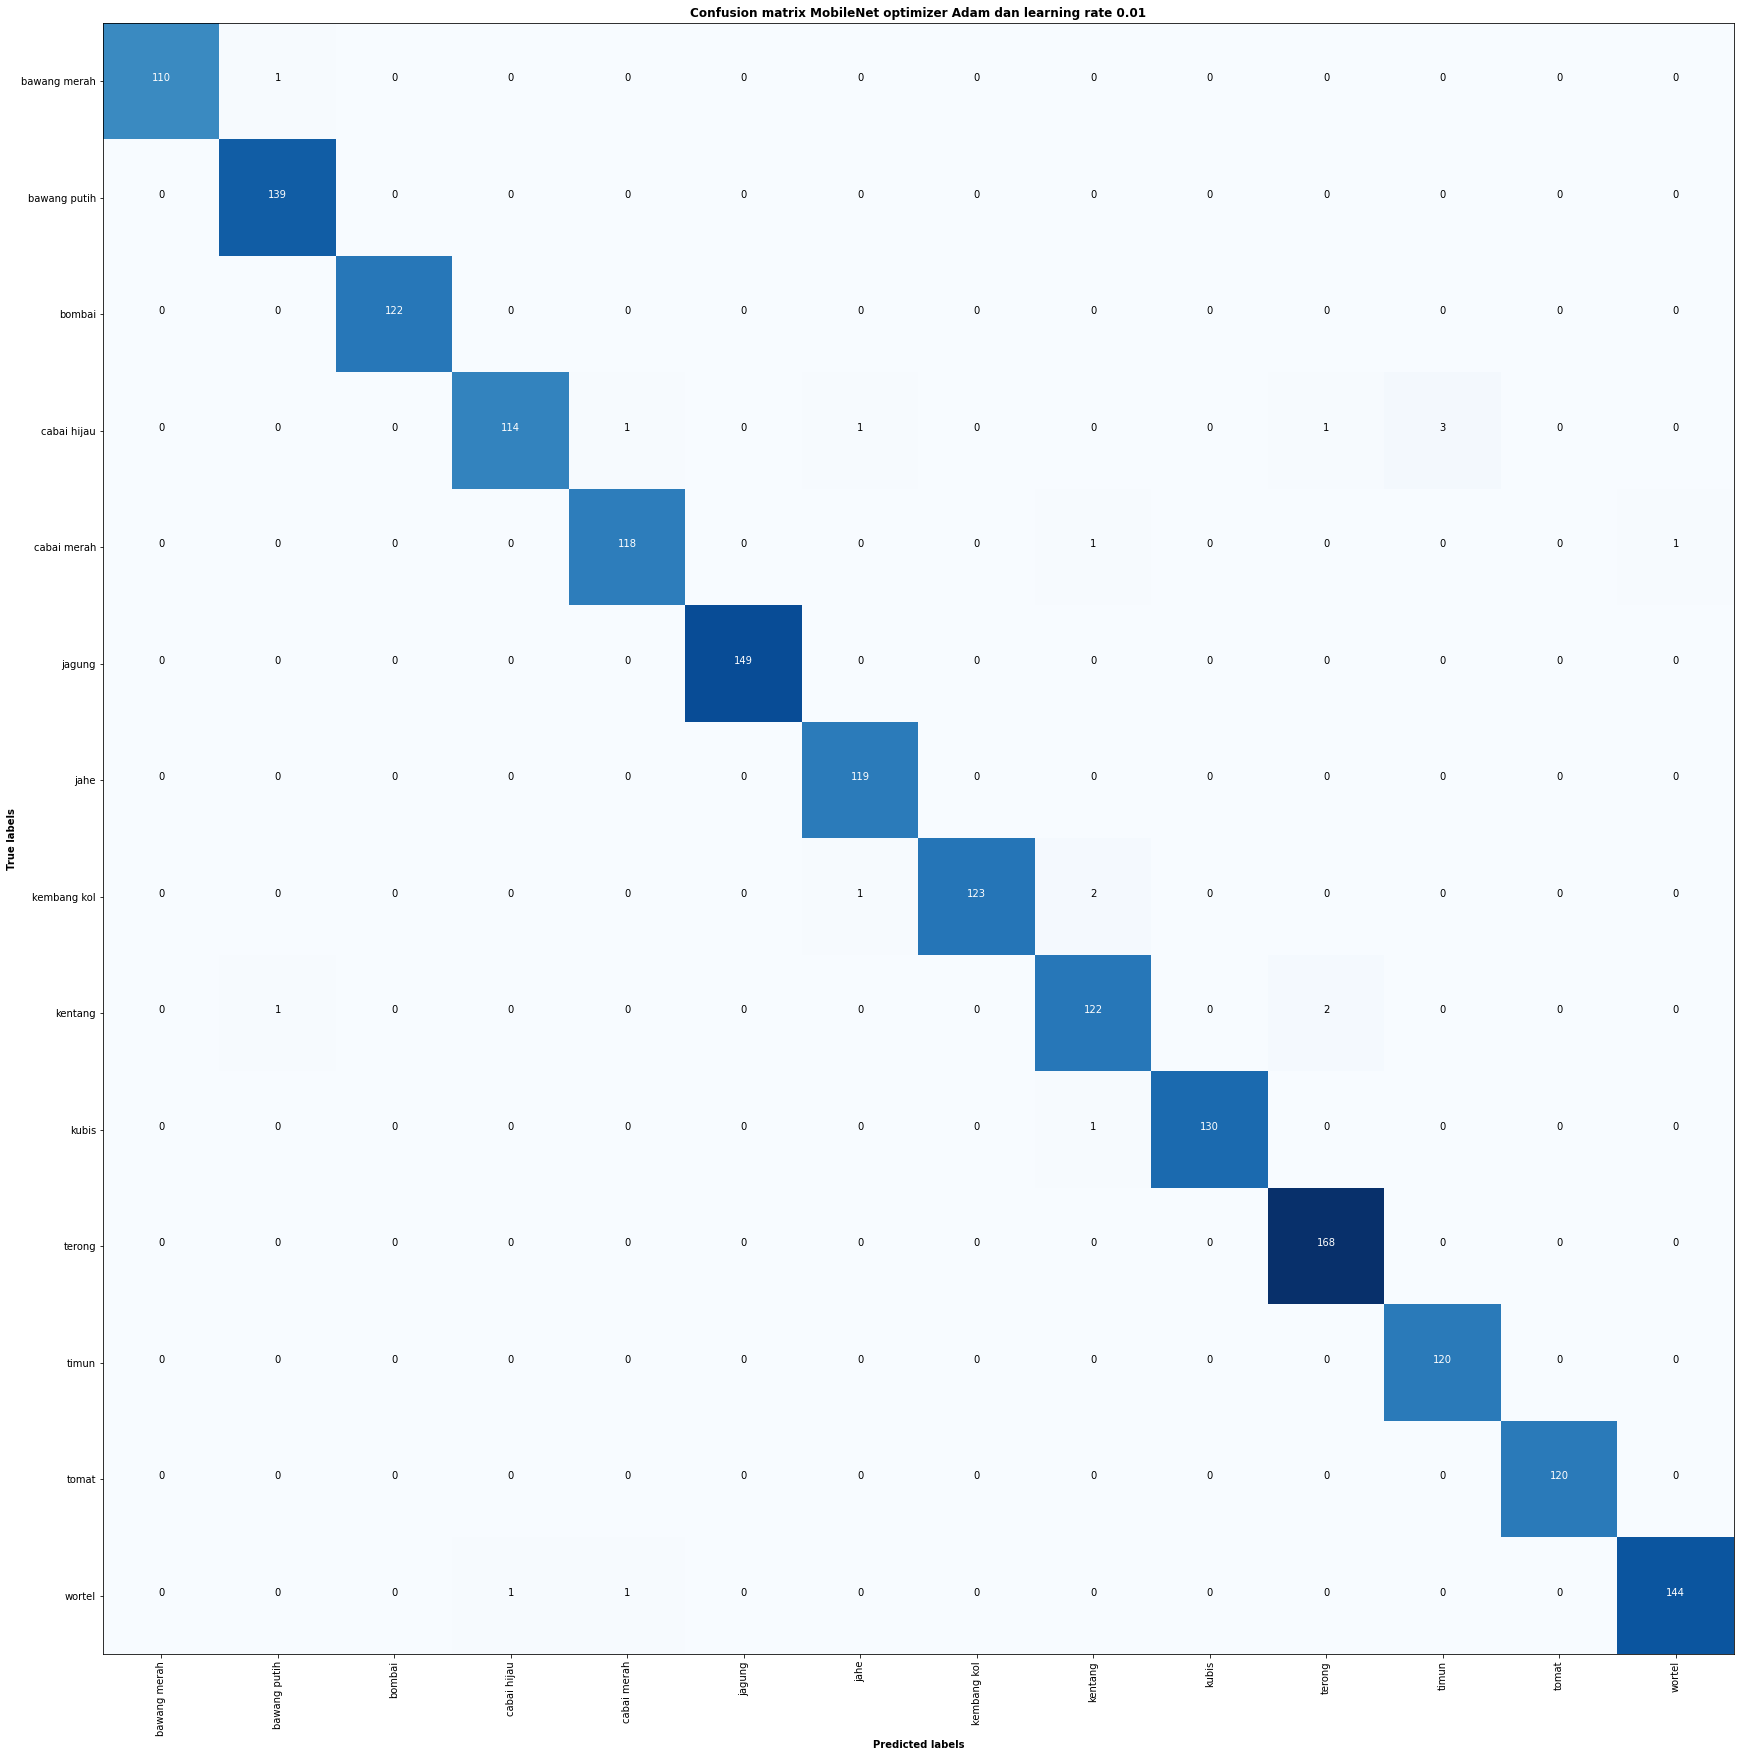

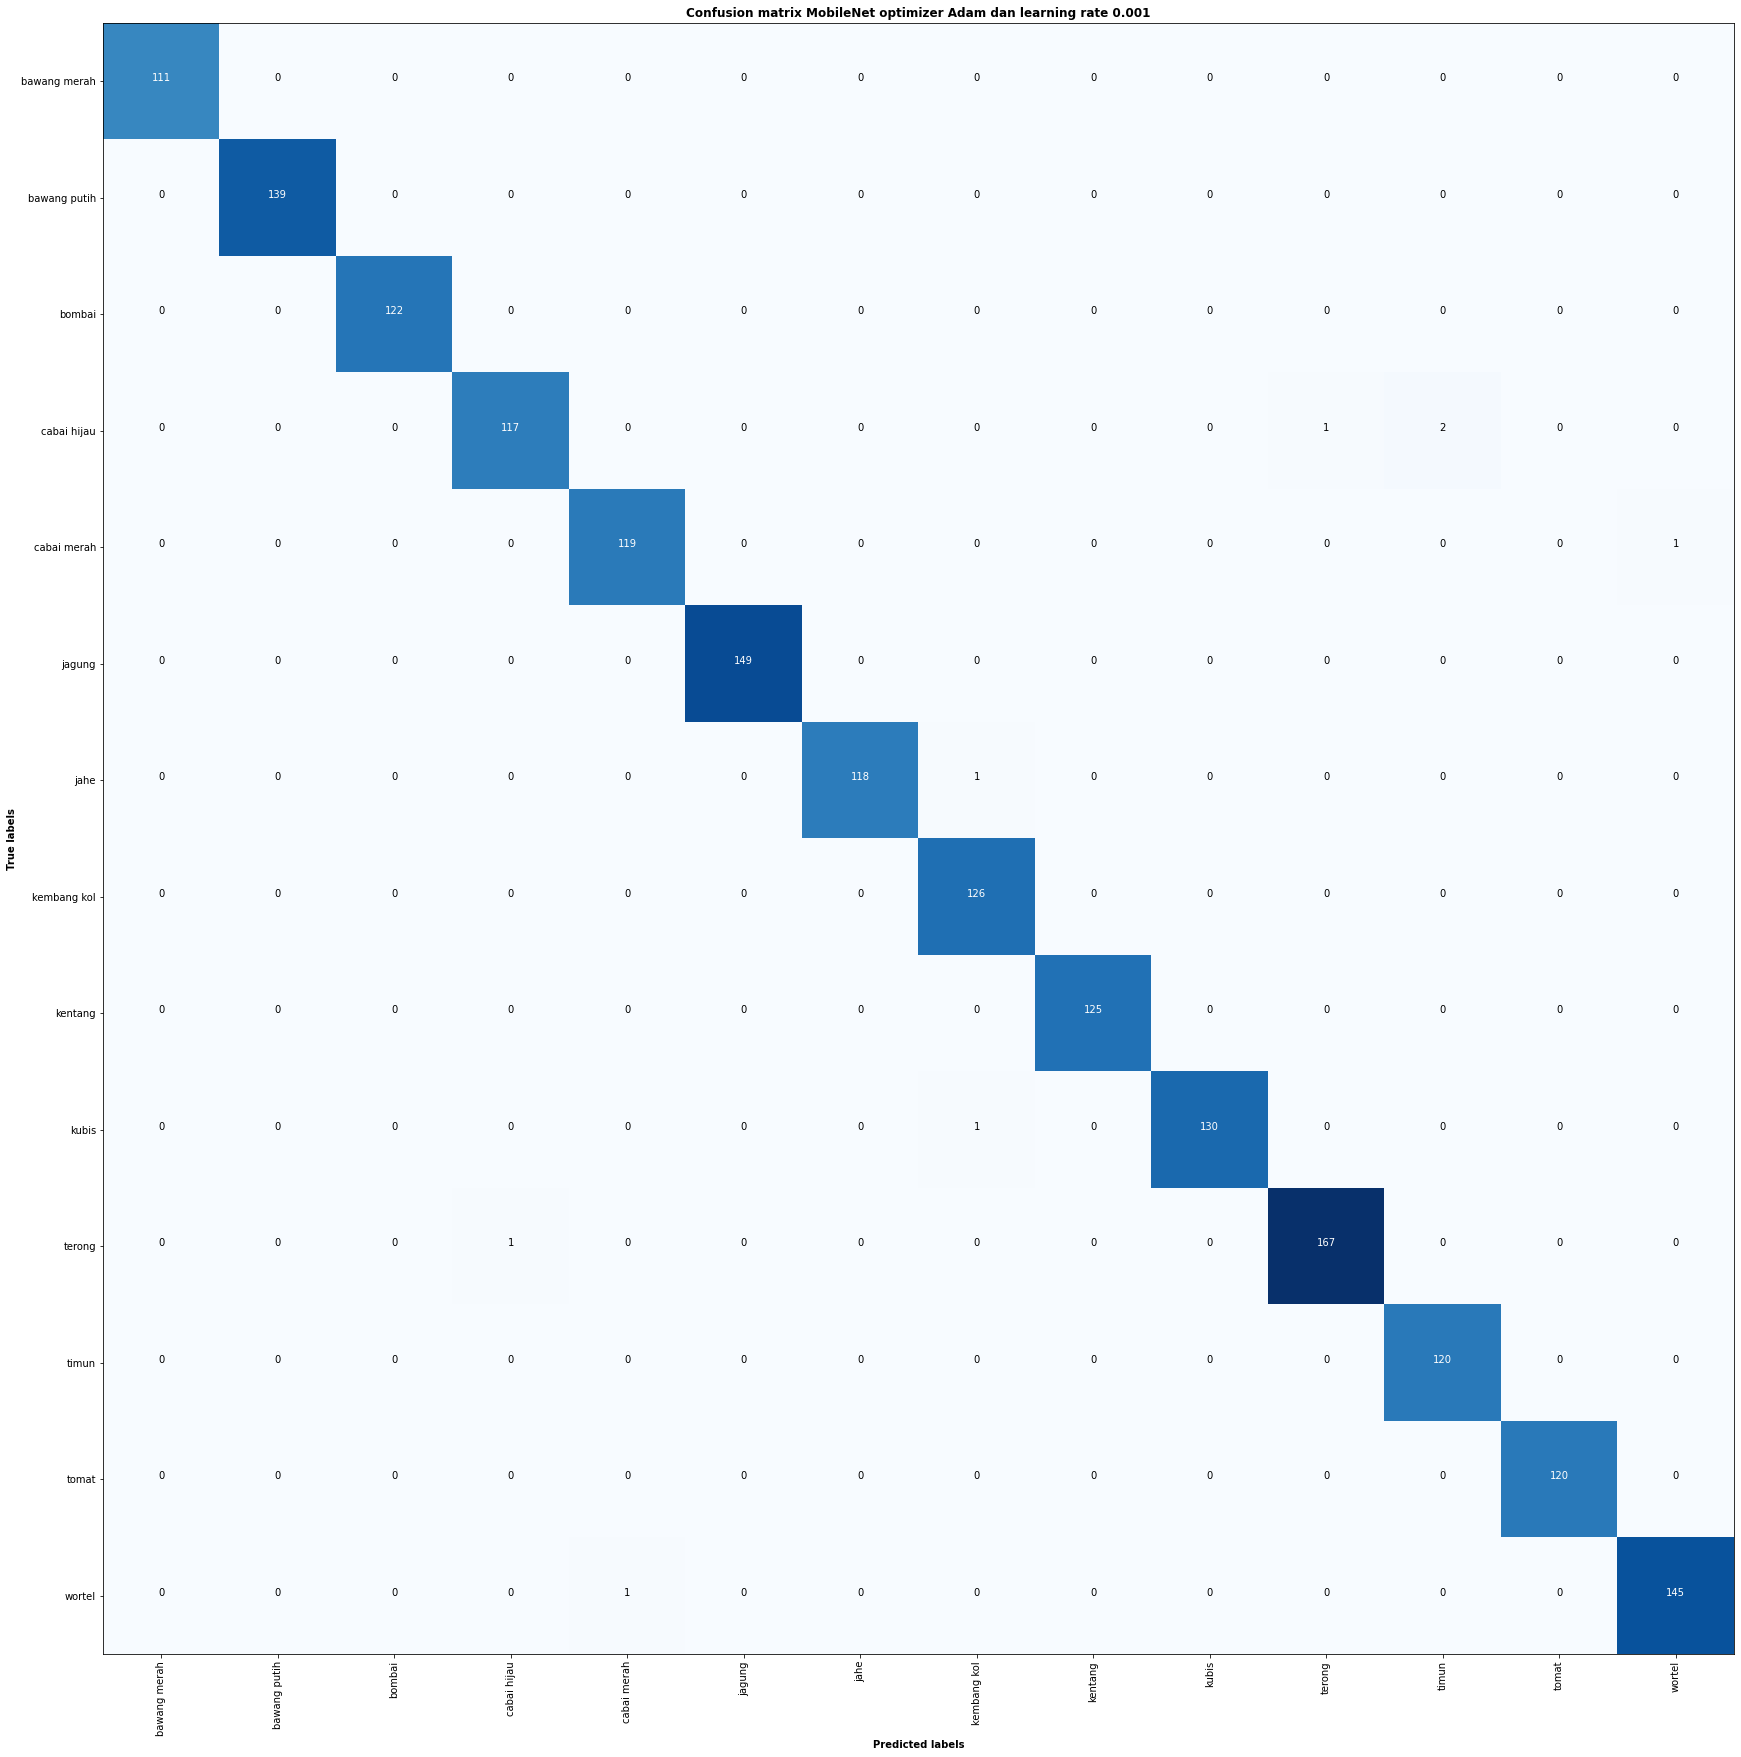

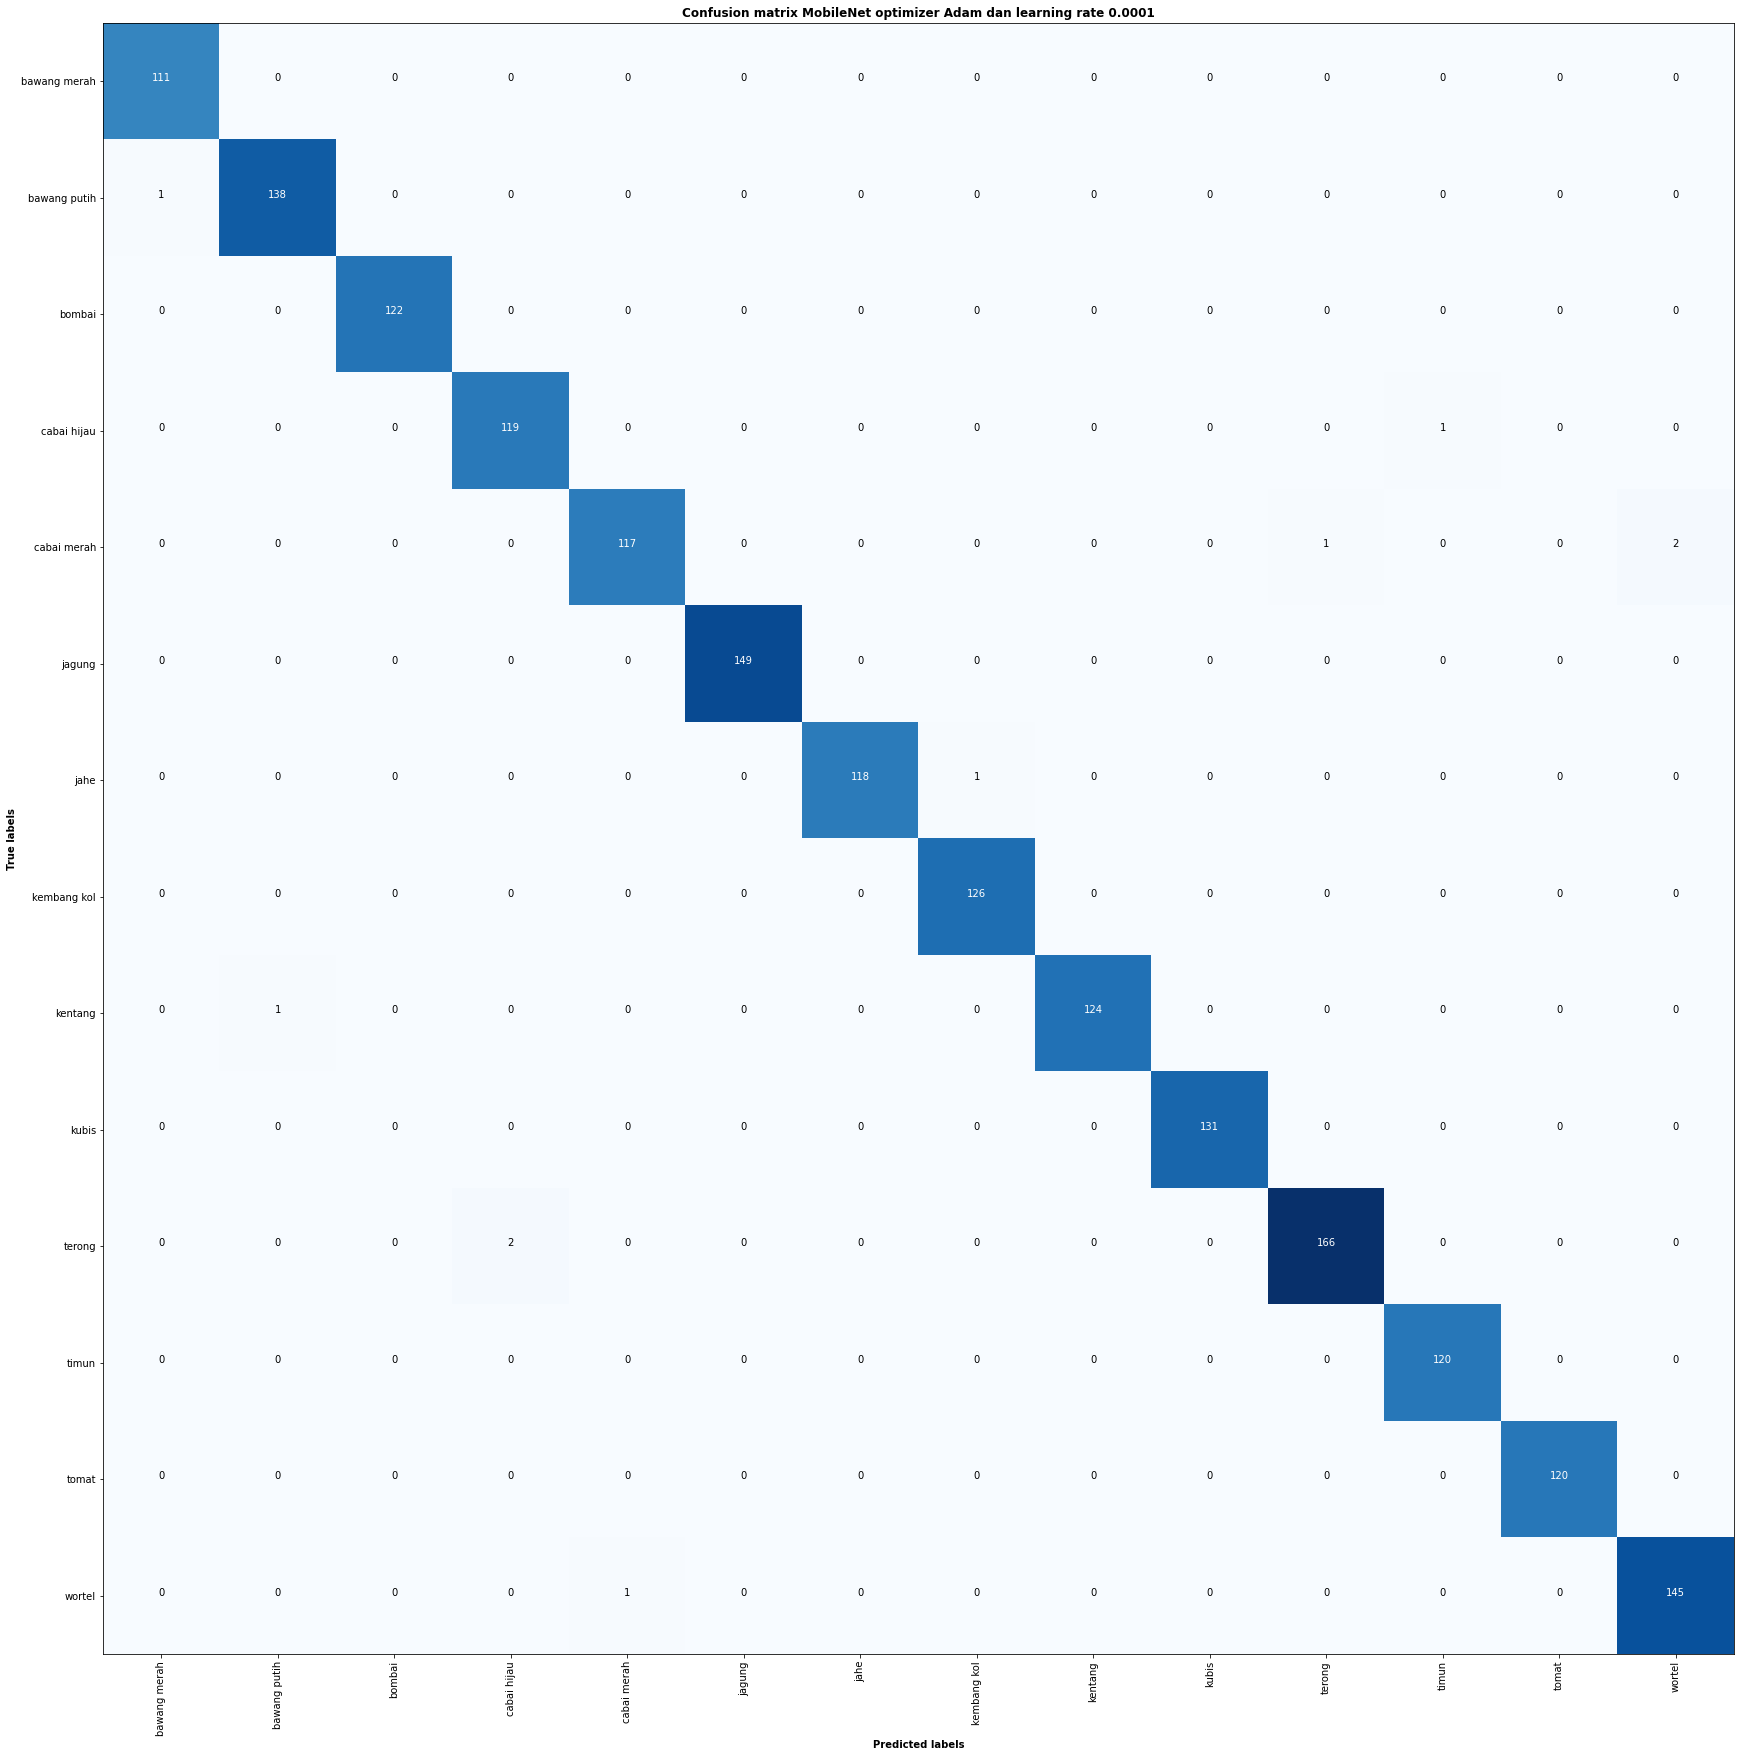

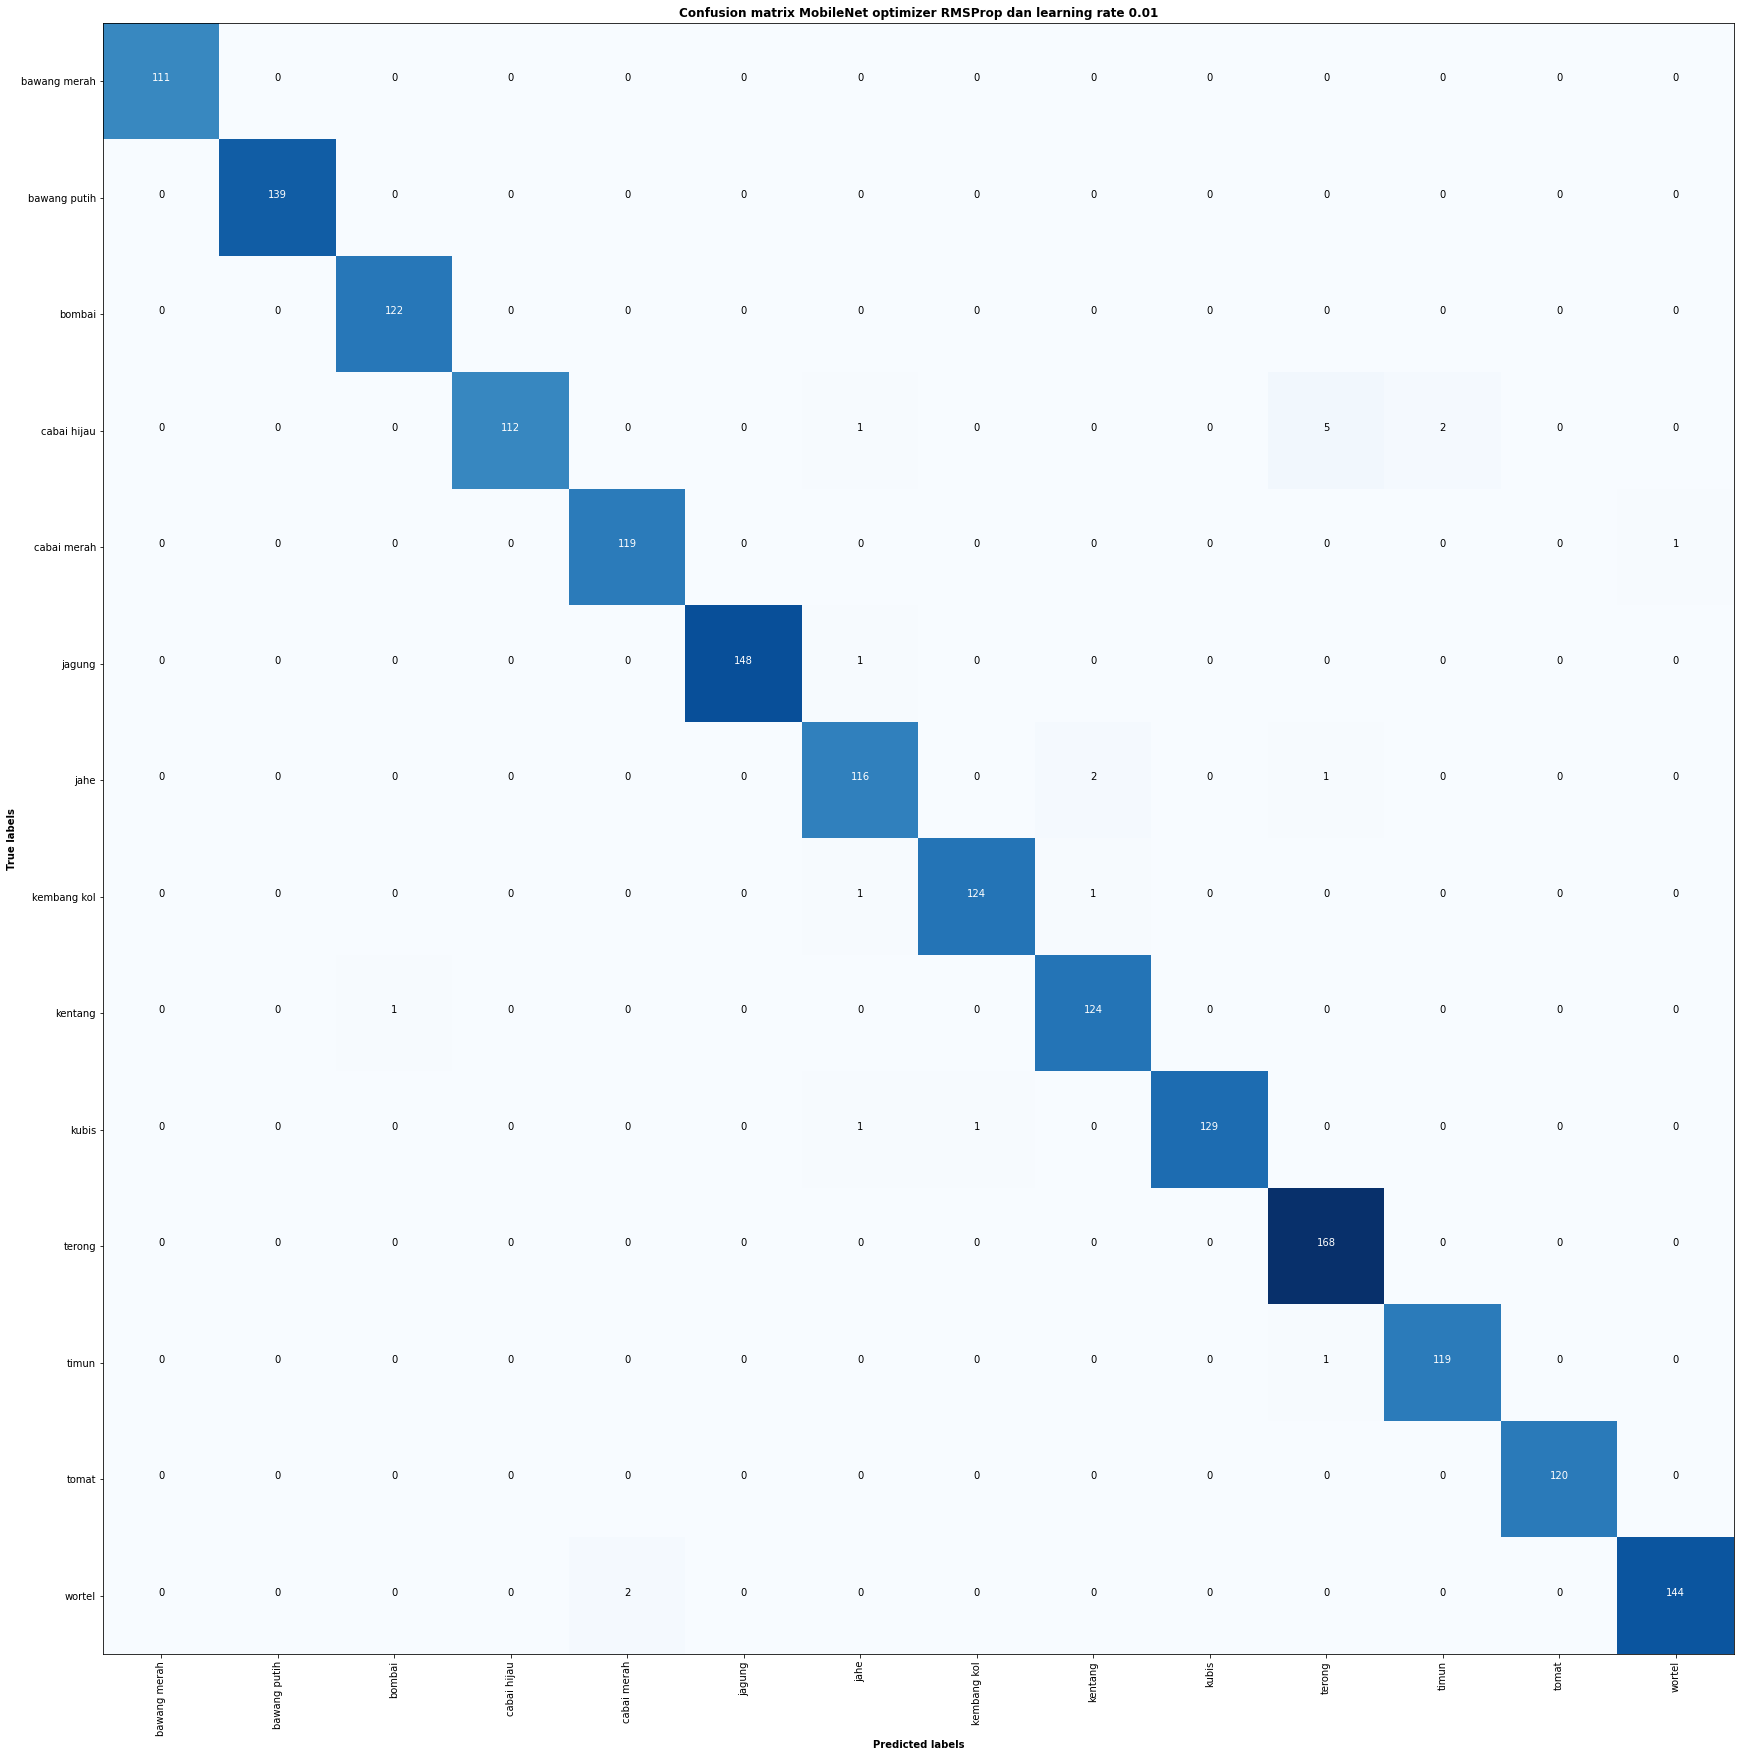

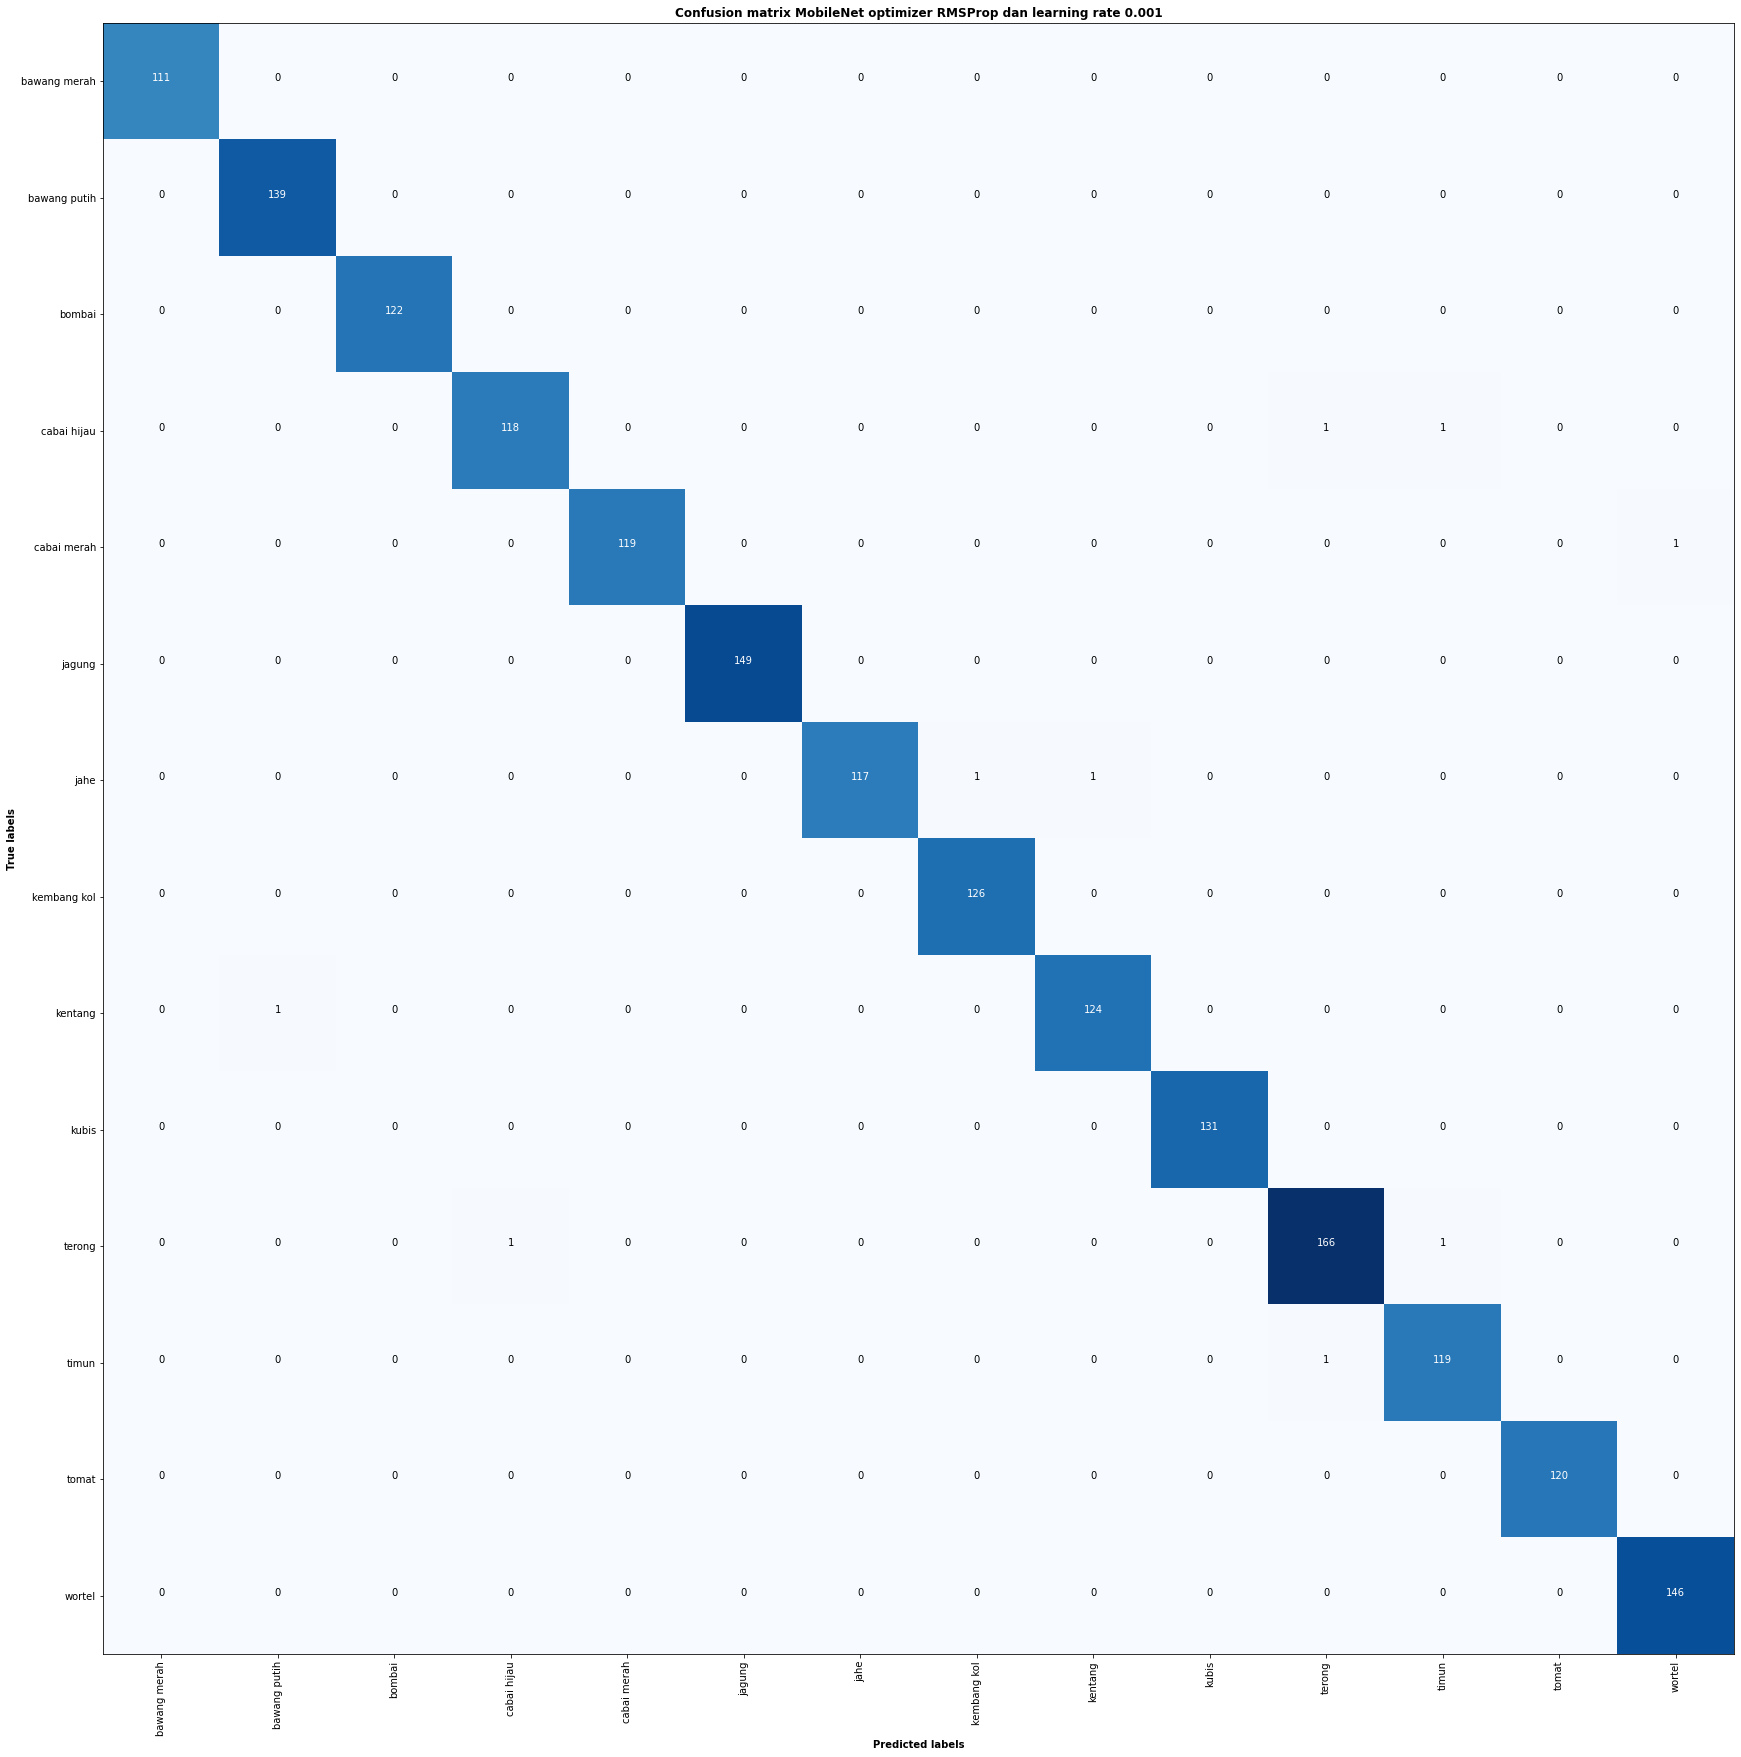

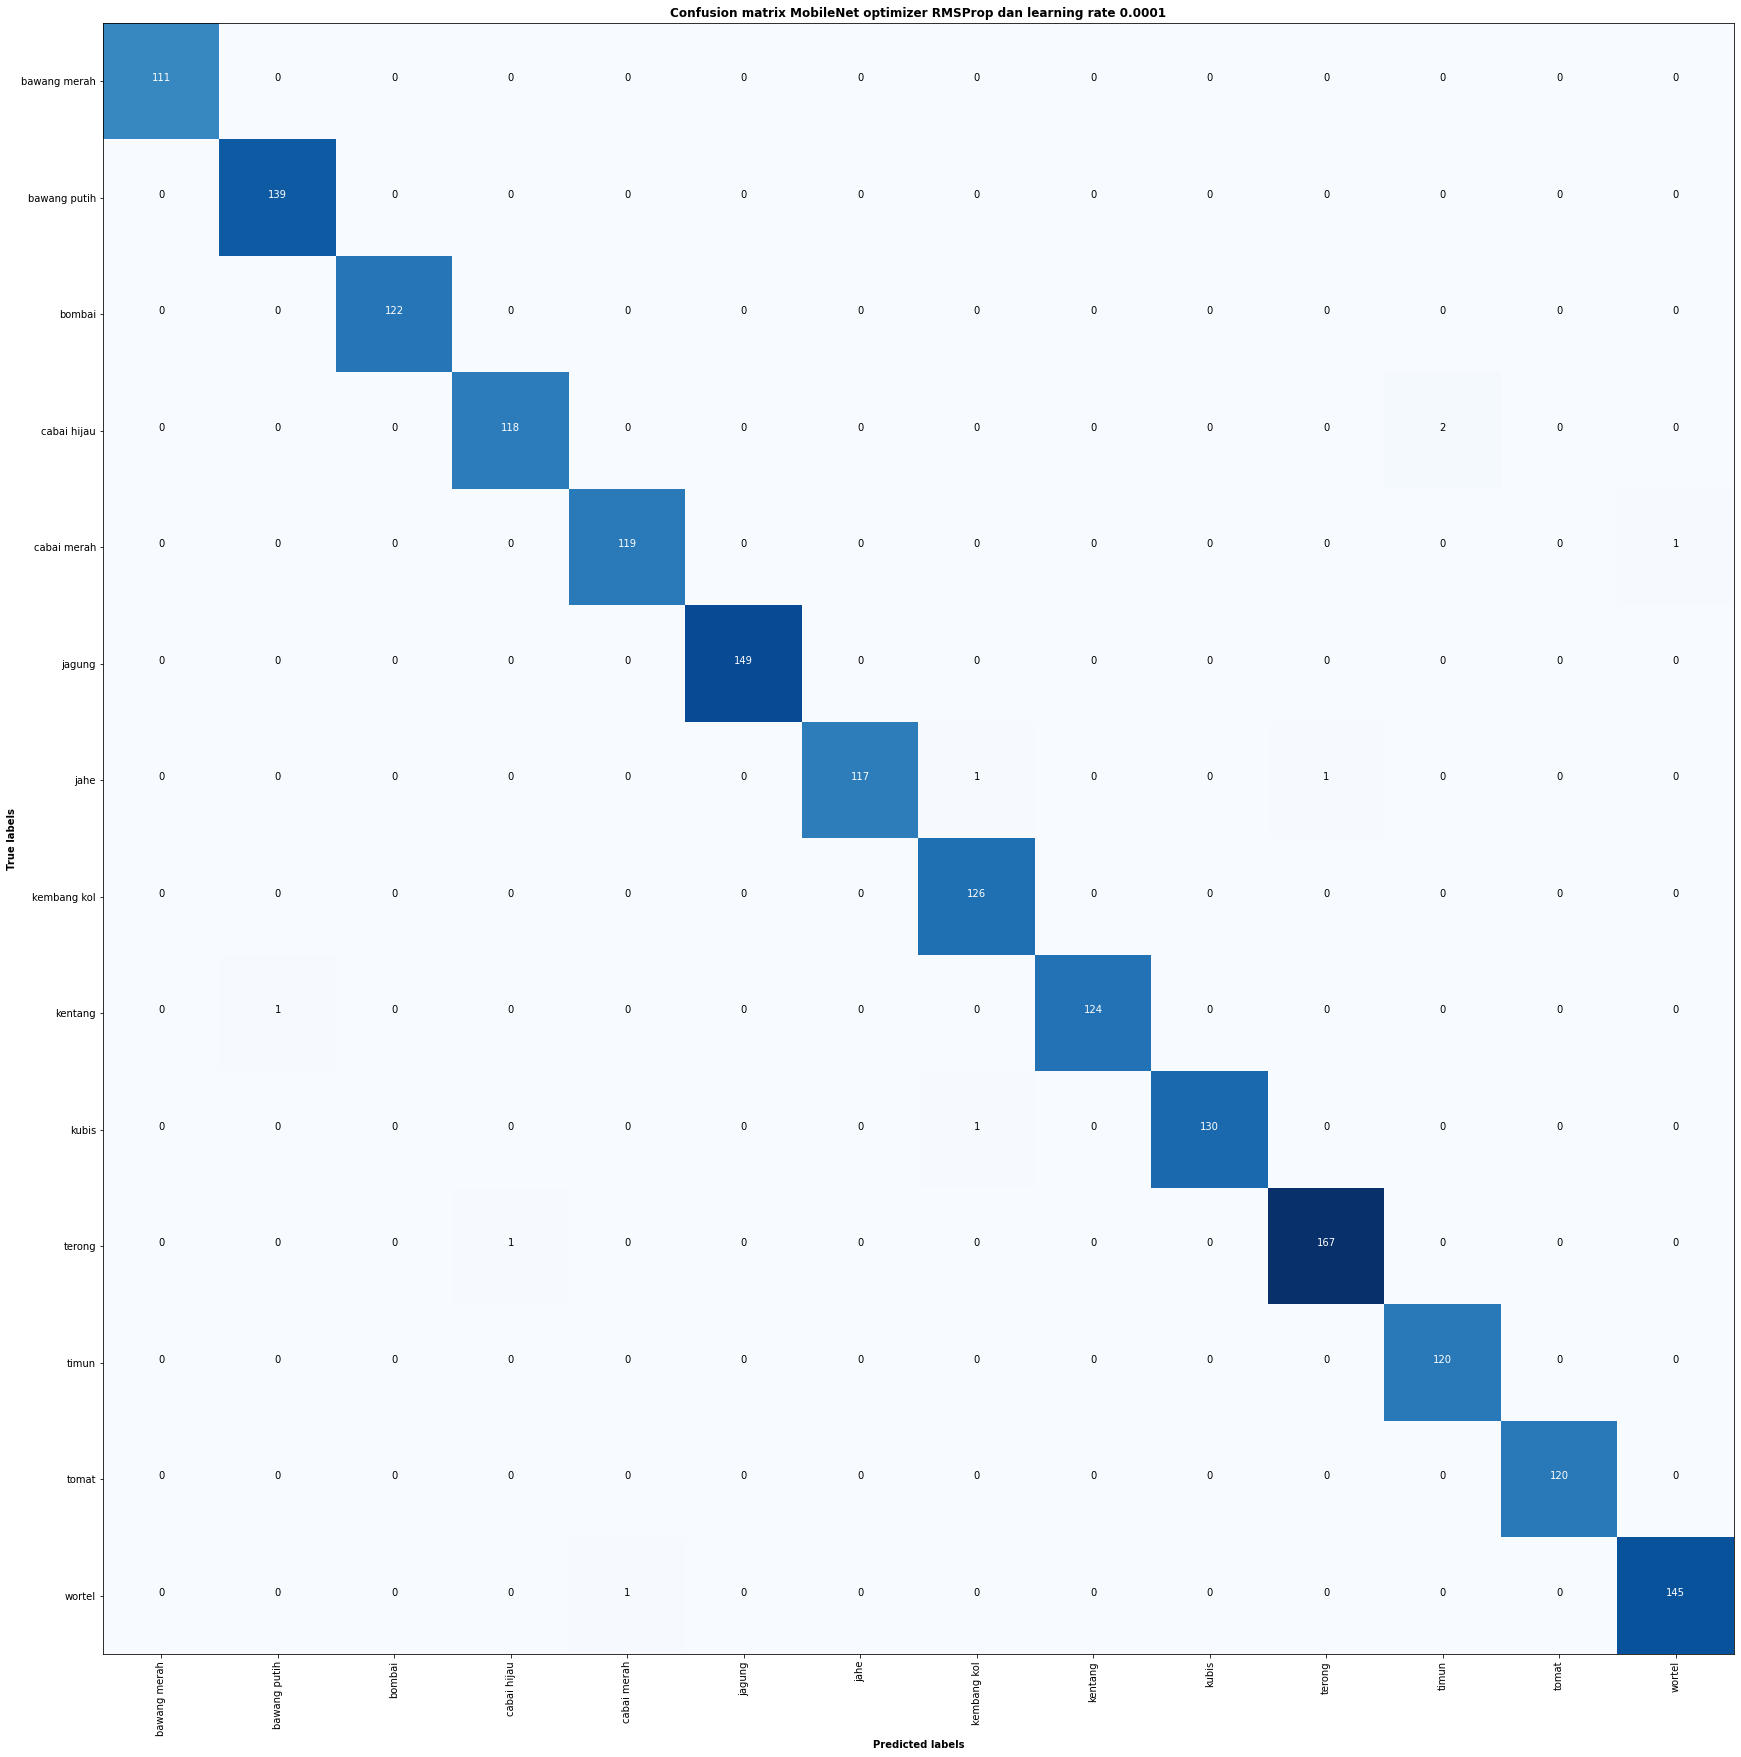

In [ ]:
# Visualisasi menggunakan confusion matrix
for (x, y, z) in (zip(res_predict, opt, lr)):
  preds = np.argmax(x, axis=1) # mengubah matrix ke array
  plot_confusion_matrix(confusion_matrix(true_classes, preds), class_labels, f"MobileNet optimizer {y} dan learning rate {z}")

#### 6.3.2 Visualisasi Model VGG

In [ ]:
res_predict = [pred_vgg_adam1_70_30, pred_vgg_adam2_70_30, pred_vgg_adam3_70_30, pred_vgg_rmsprop1_70_30, pred_vgg_rmsprop2_70_30, pred_vgg_rmsprop3_70_30]
for (x, y, z) in (zip(res_predict, opt, lr)):
  print(f"\n++++++++++++++++++++++++ Model VGG ++++++++++++++++++++++++")
  print(f"++++++++++ optimizer {y} dan learning rate {z} ++++++++++\n")

  preds = np.argmax(x, axis=1) # mengubah matrix ke array
  print(classification_report(true_classes, preds, target_names=class_labels))



++++++++++++++++++++++++ Model VGG ++++++++++++++++++++++++
++++++++++ optimizer Adam dan learning rate 0.01 ++++++++++

              precision    recall  f1-score   support

bawang merah       0.97      1.00      0.99       111
bawang putih       1.00      0.98      0.99       139
      bombai       0.98      1.00      0.99       122
 cabai hijau       0.98      0.86      0.92       120
 cabai merah       0.97      0.81      0.88       120
      jagung       0.99      0.99      0.99       149
        jahe       0.97      0.97      0.97       119
 kembang kol       0.98      0.98      0.98       126
     kentang       0.94      0.98      0.96       125
       kubis       0.98      0.98      0.98       131
      terong       0.89      0.98      0.93       168
       timun       0.95      0.92      0.93       120
       tomat       0.96      0.97      0.97       120
      wortel       0.88      0.95      0.91       146

    accuracy                           0.96      1816
   macro avg

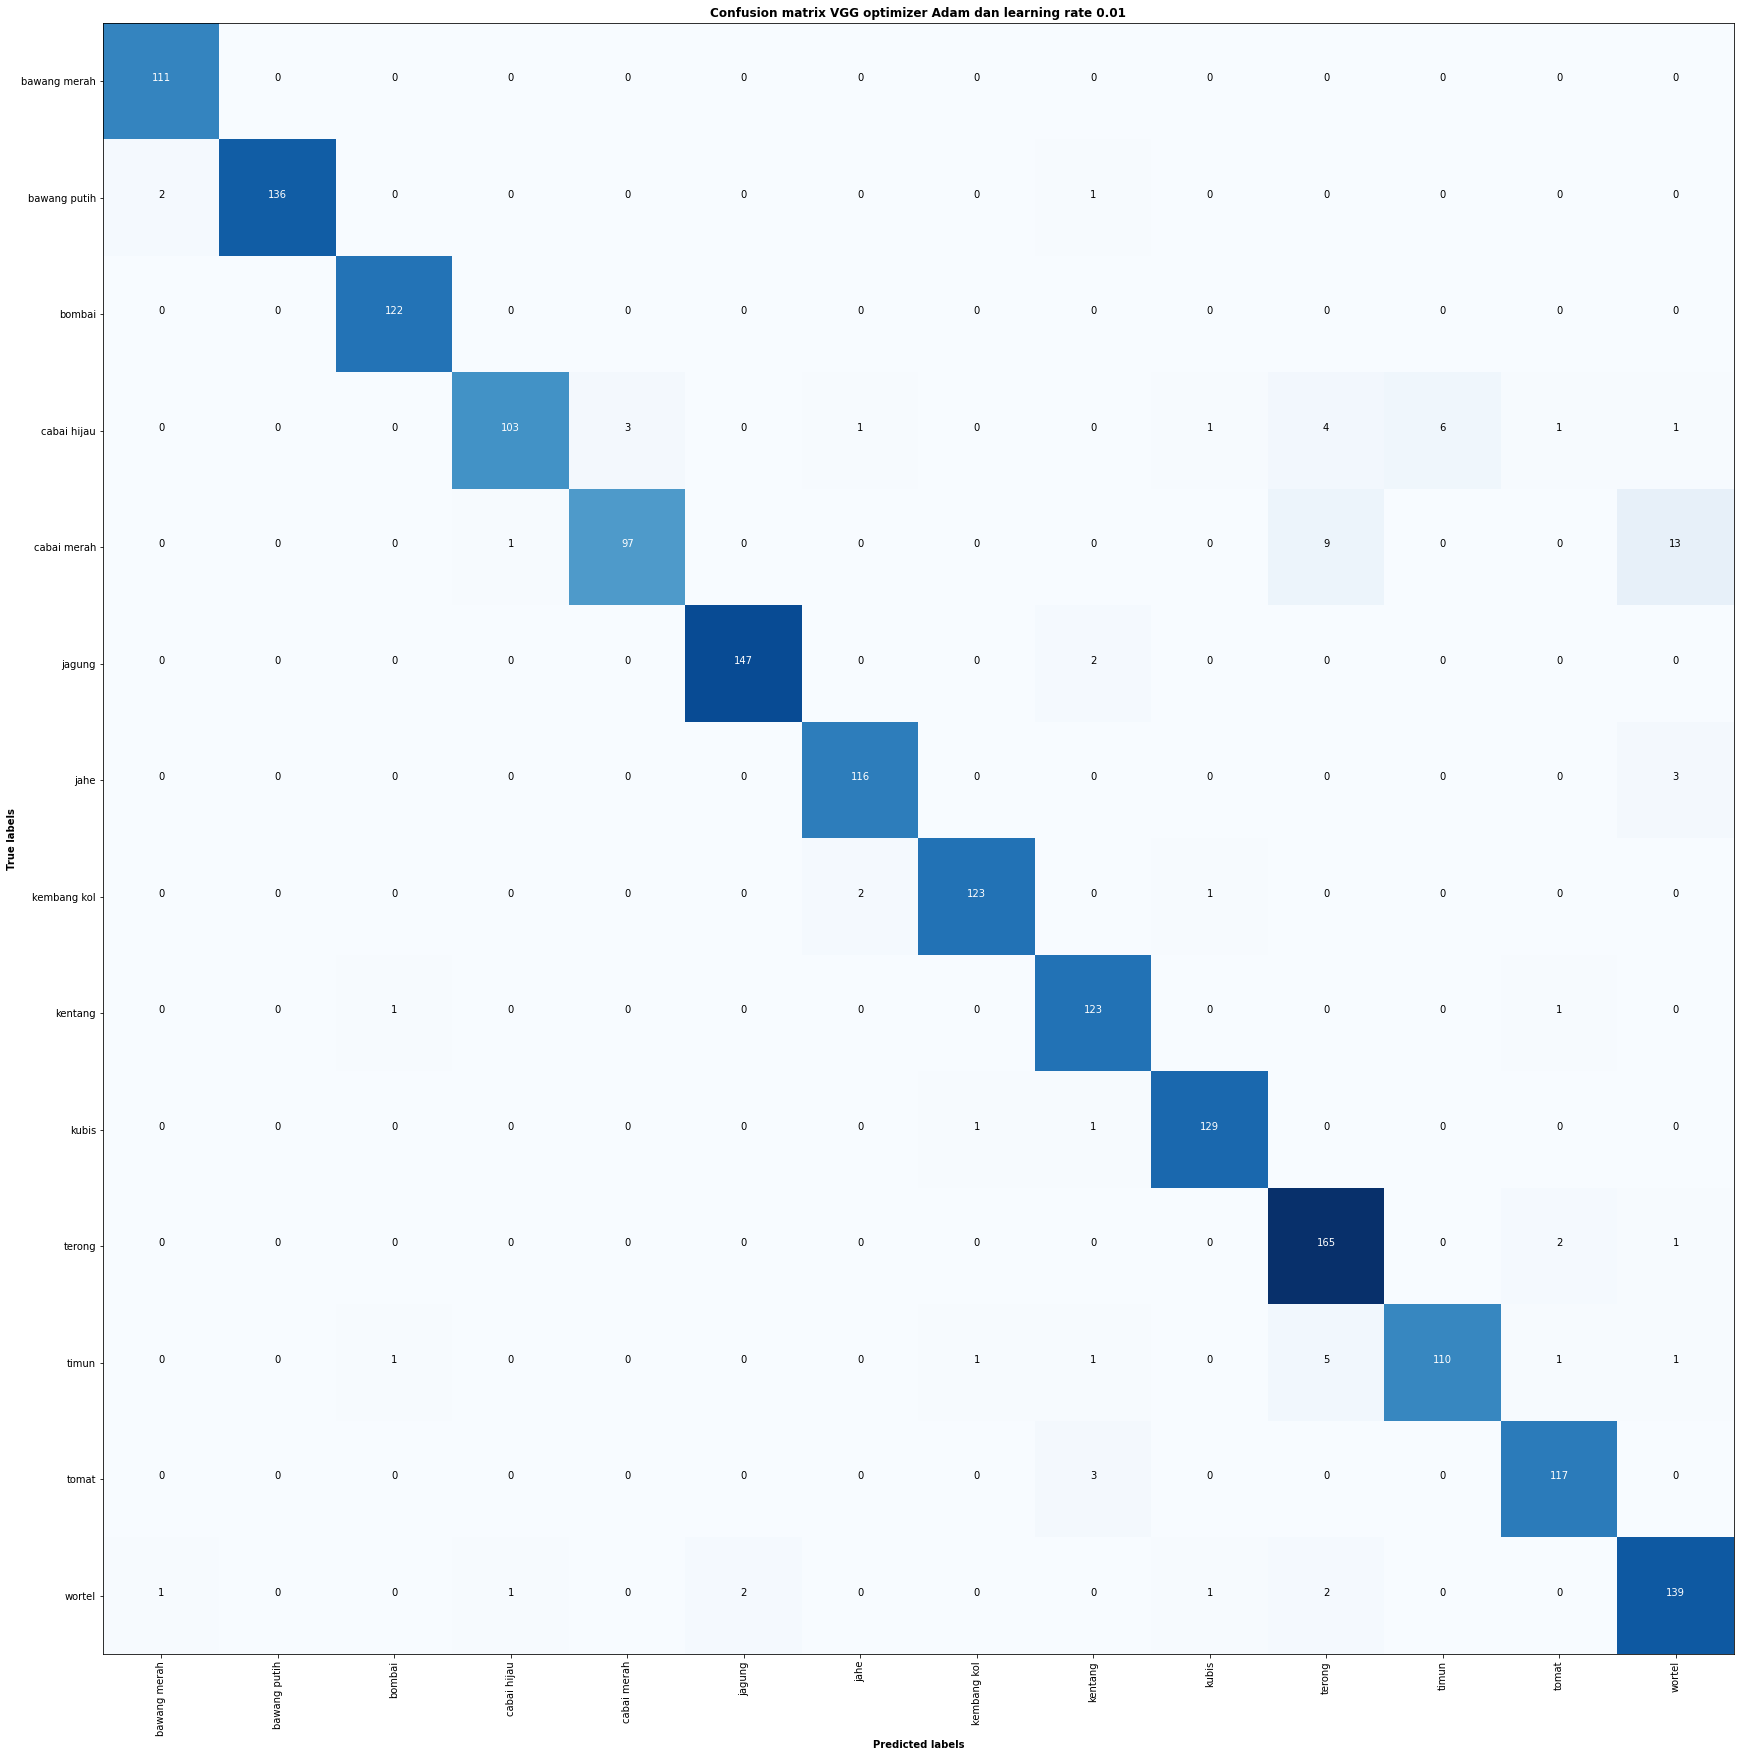

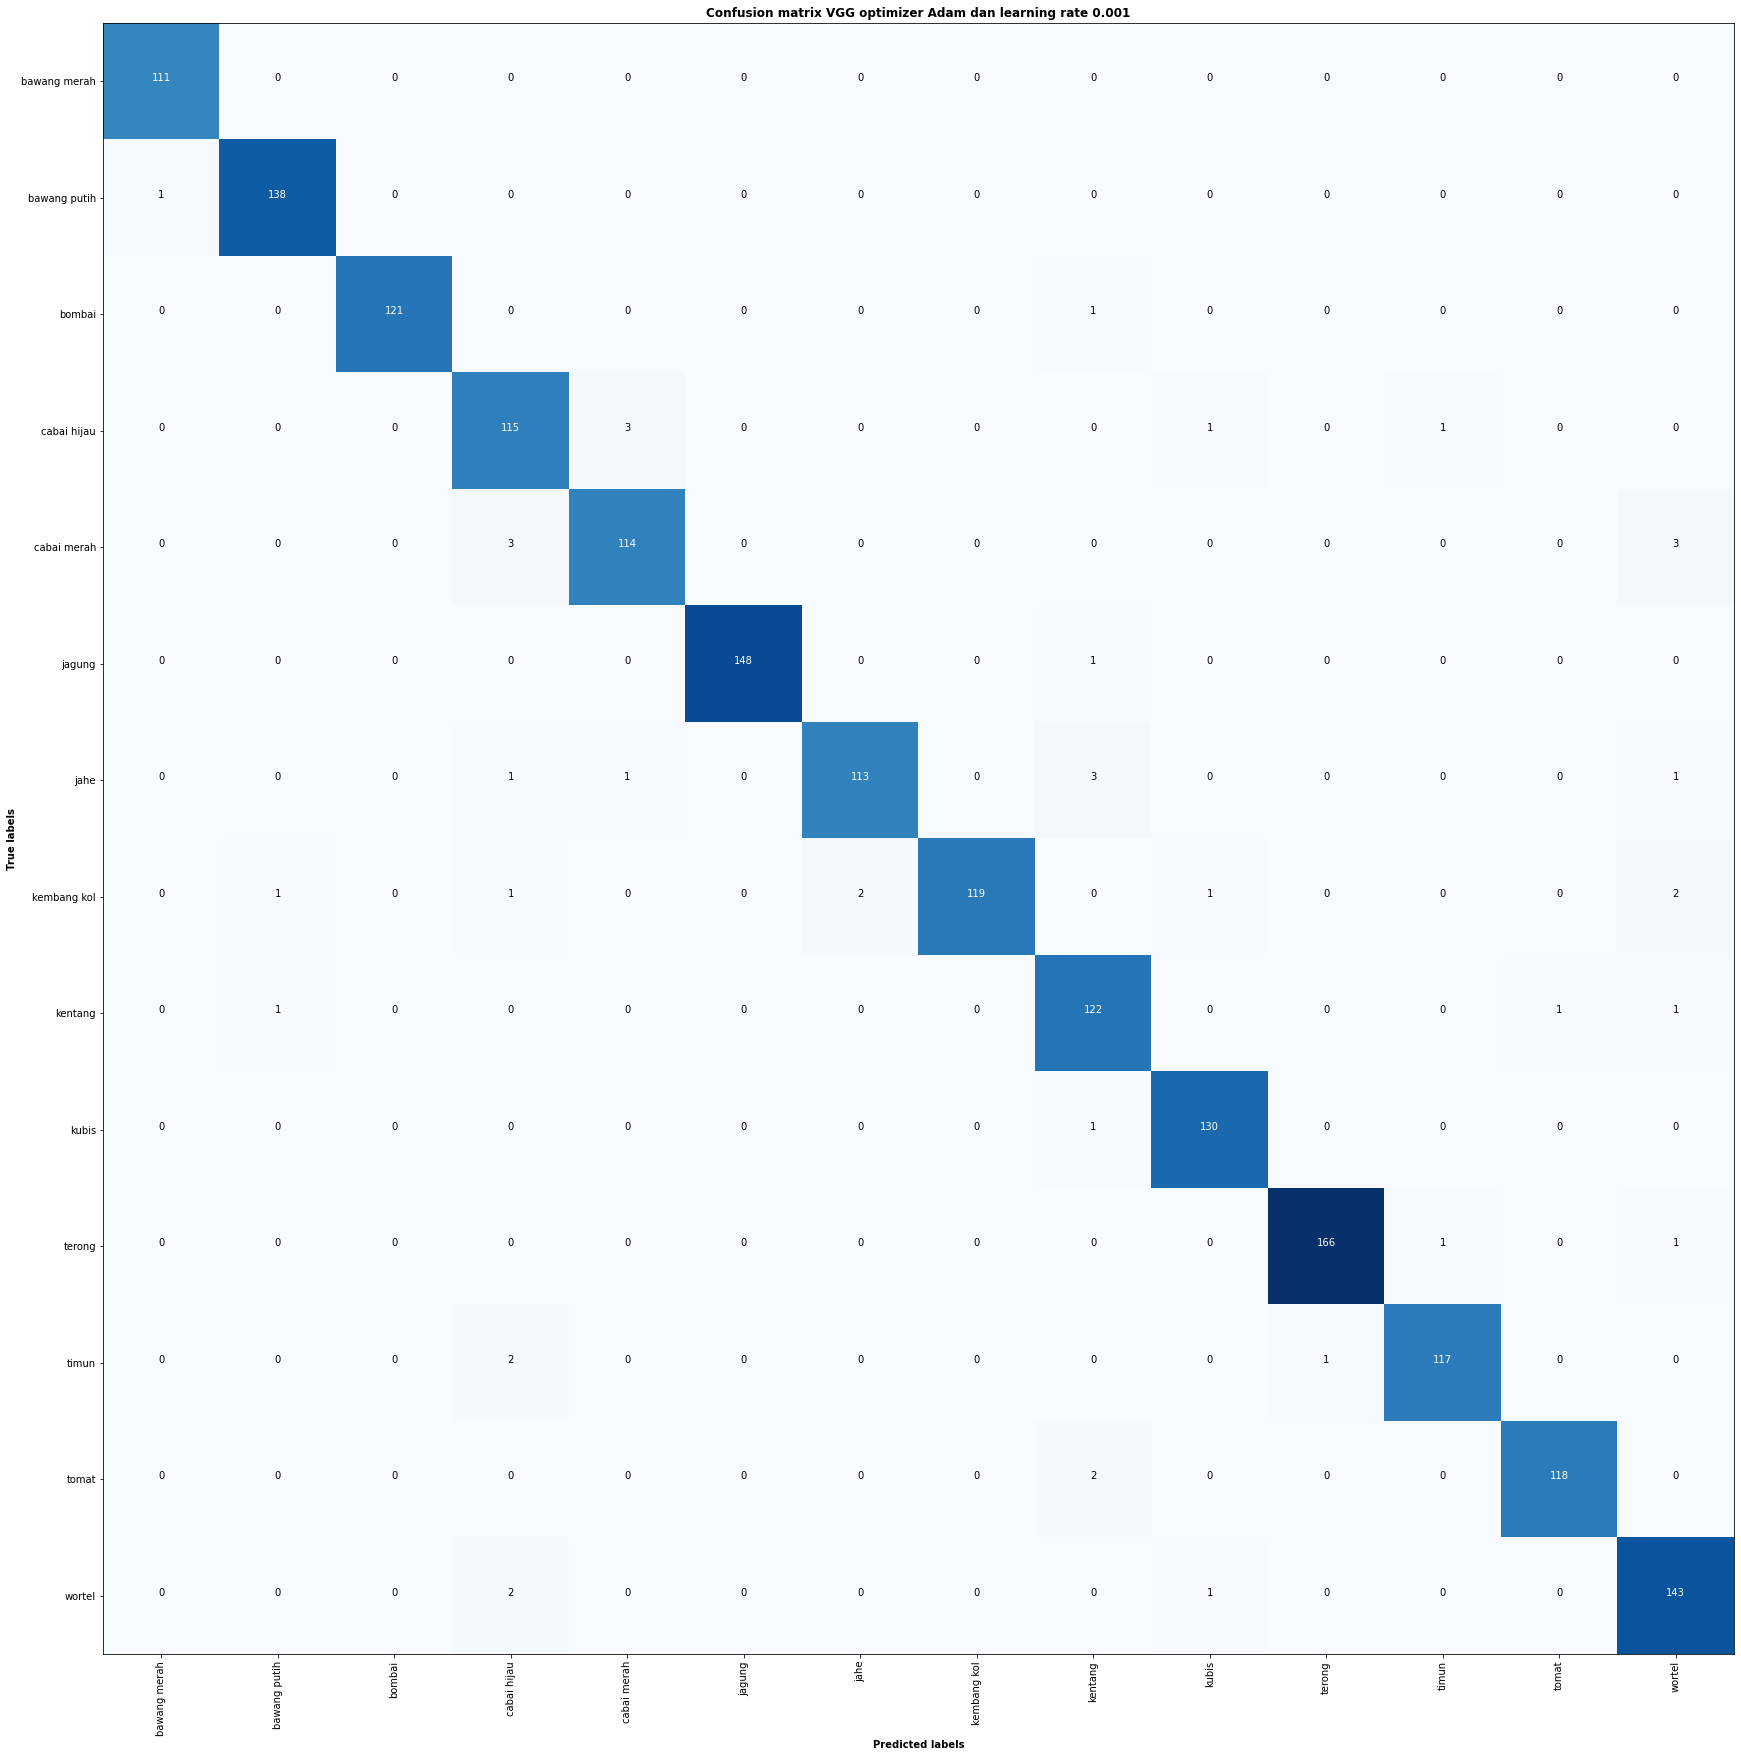

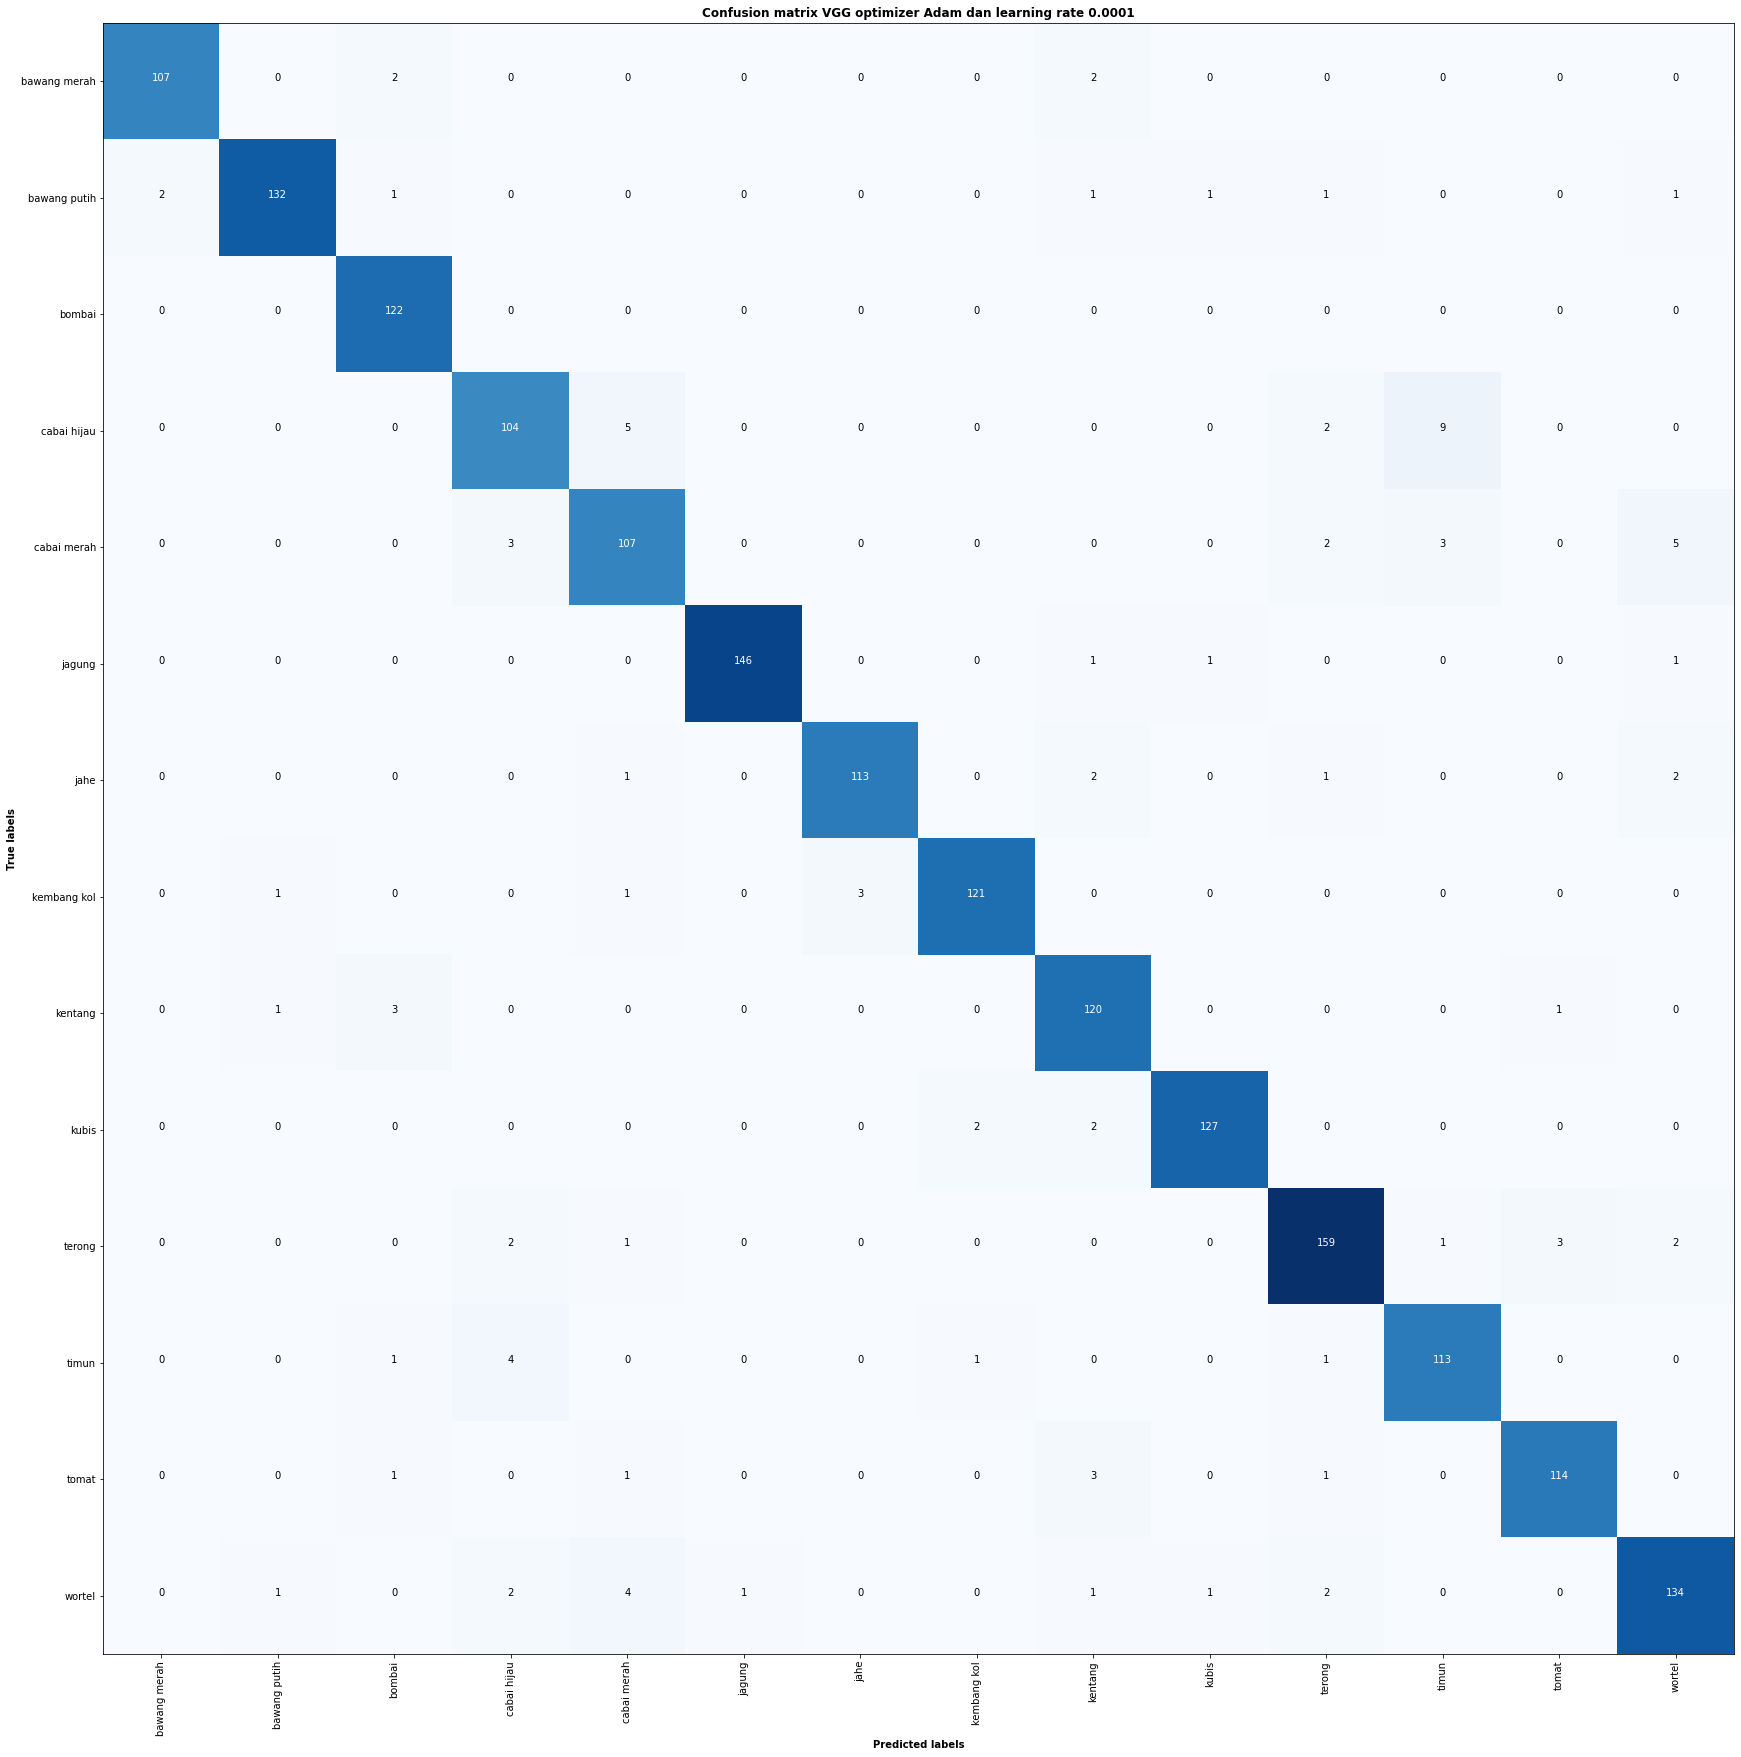

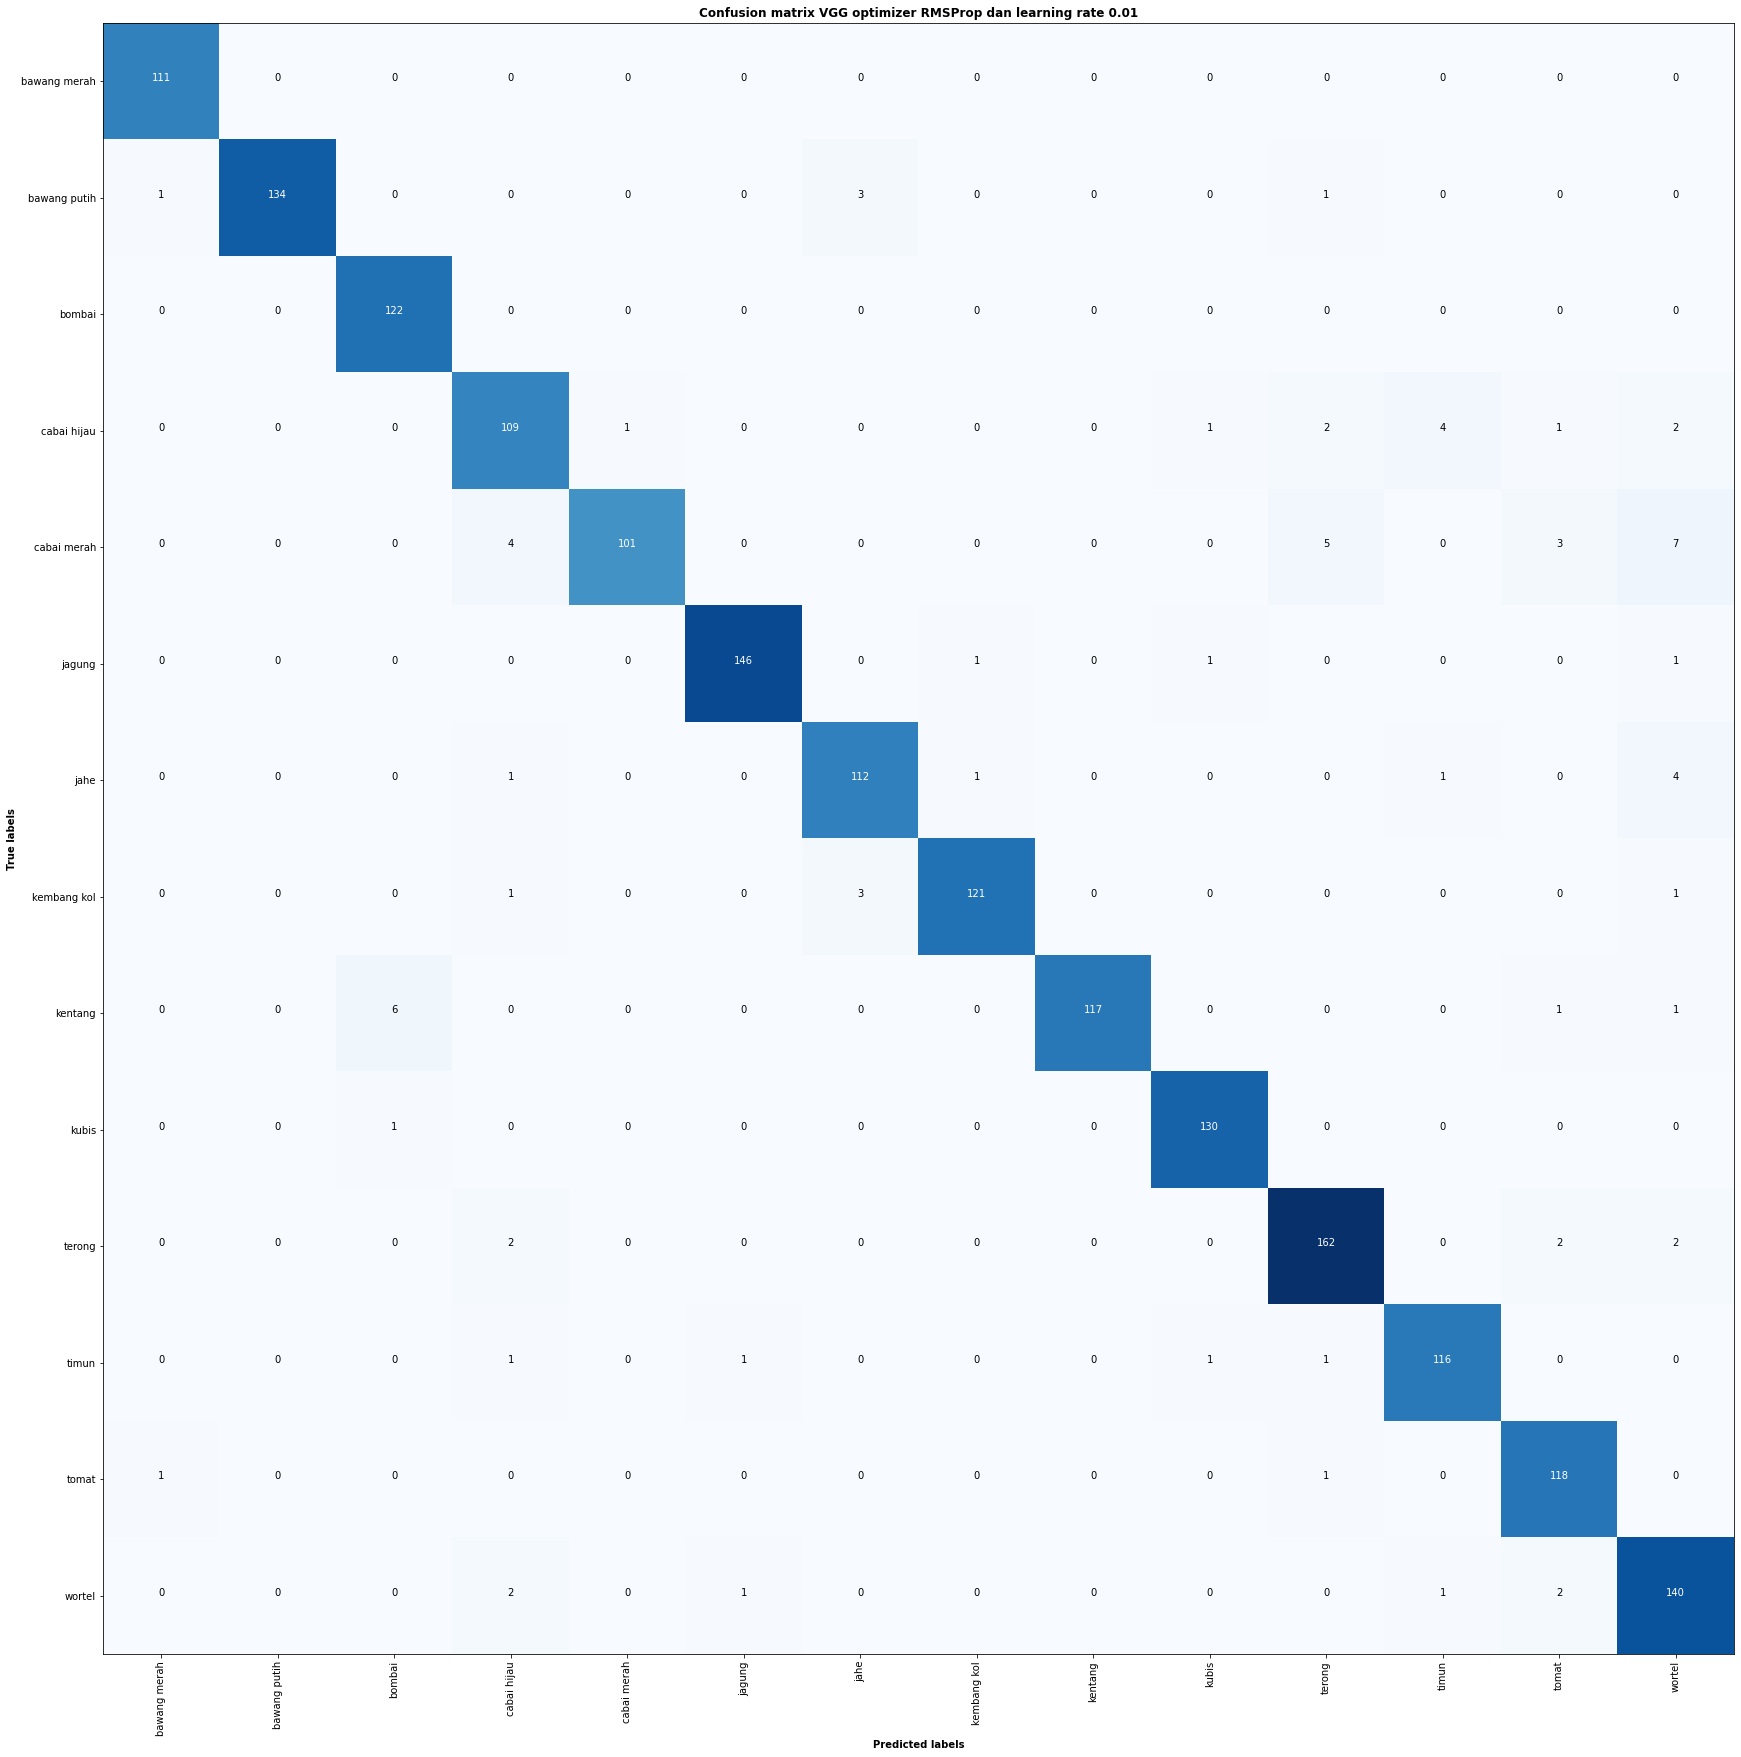

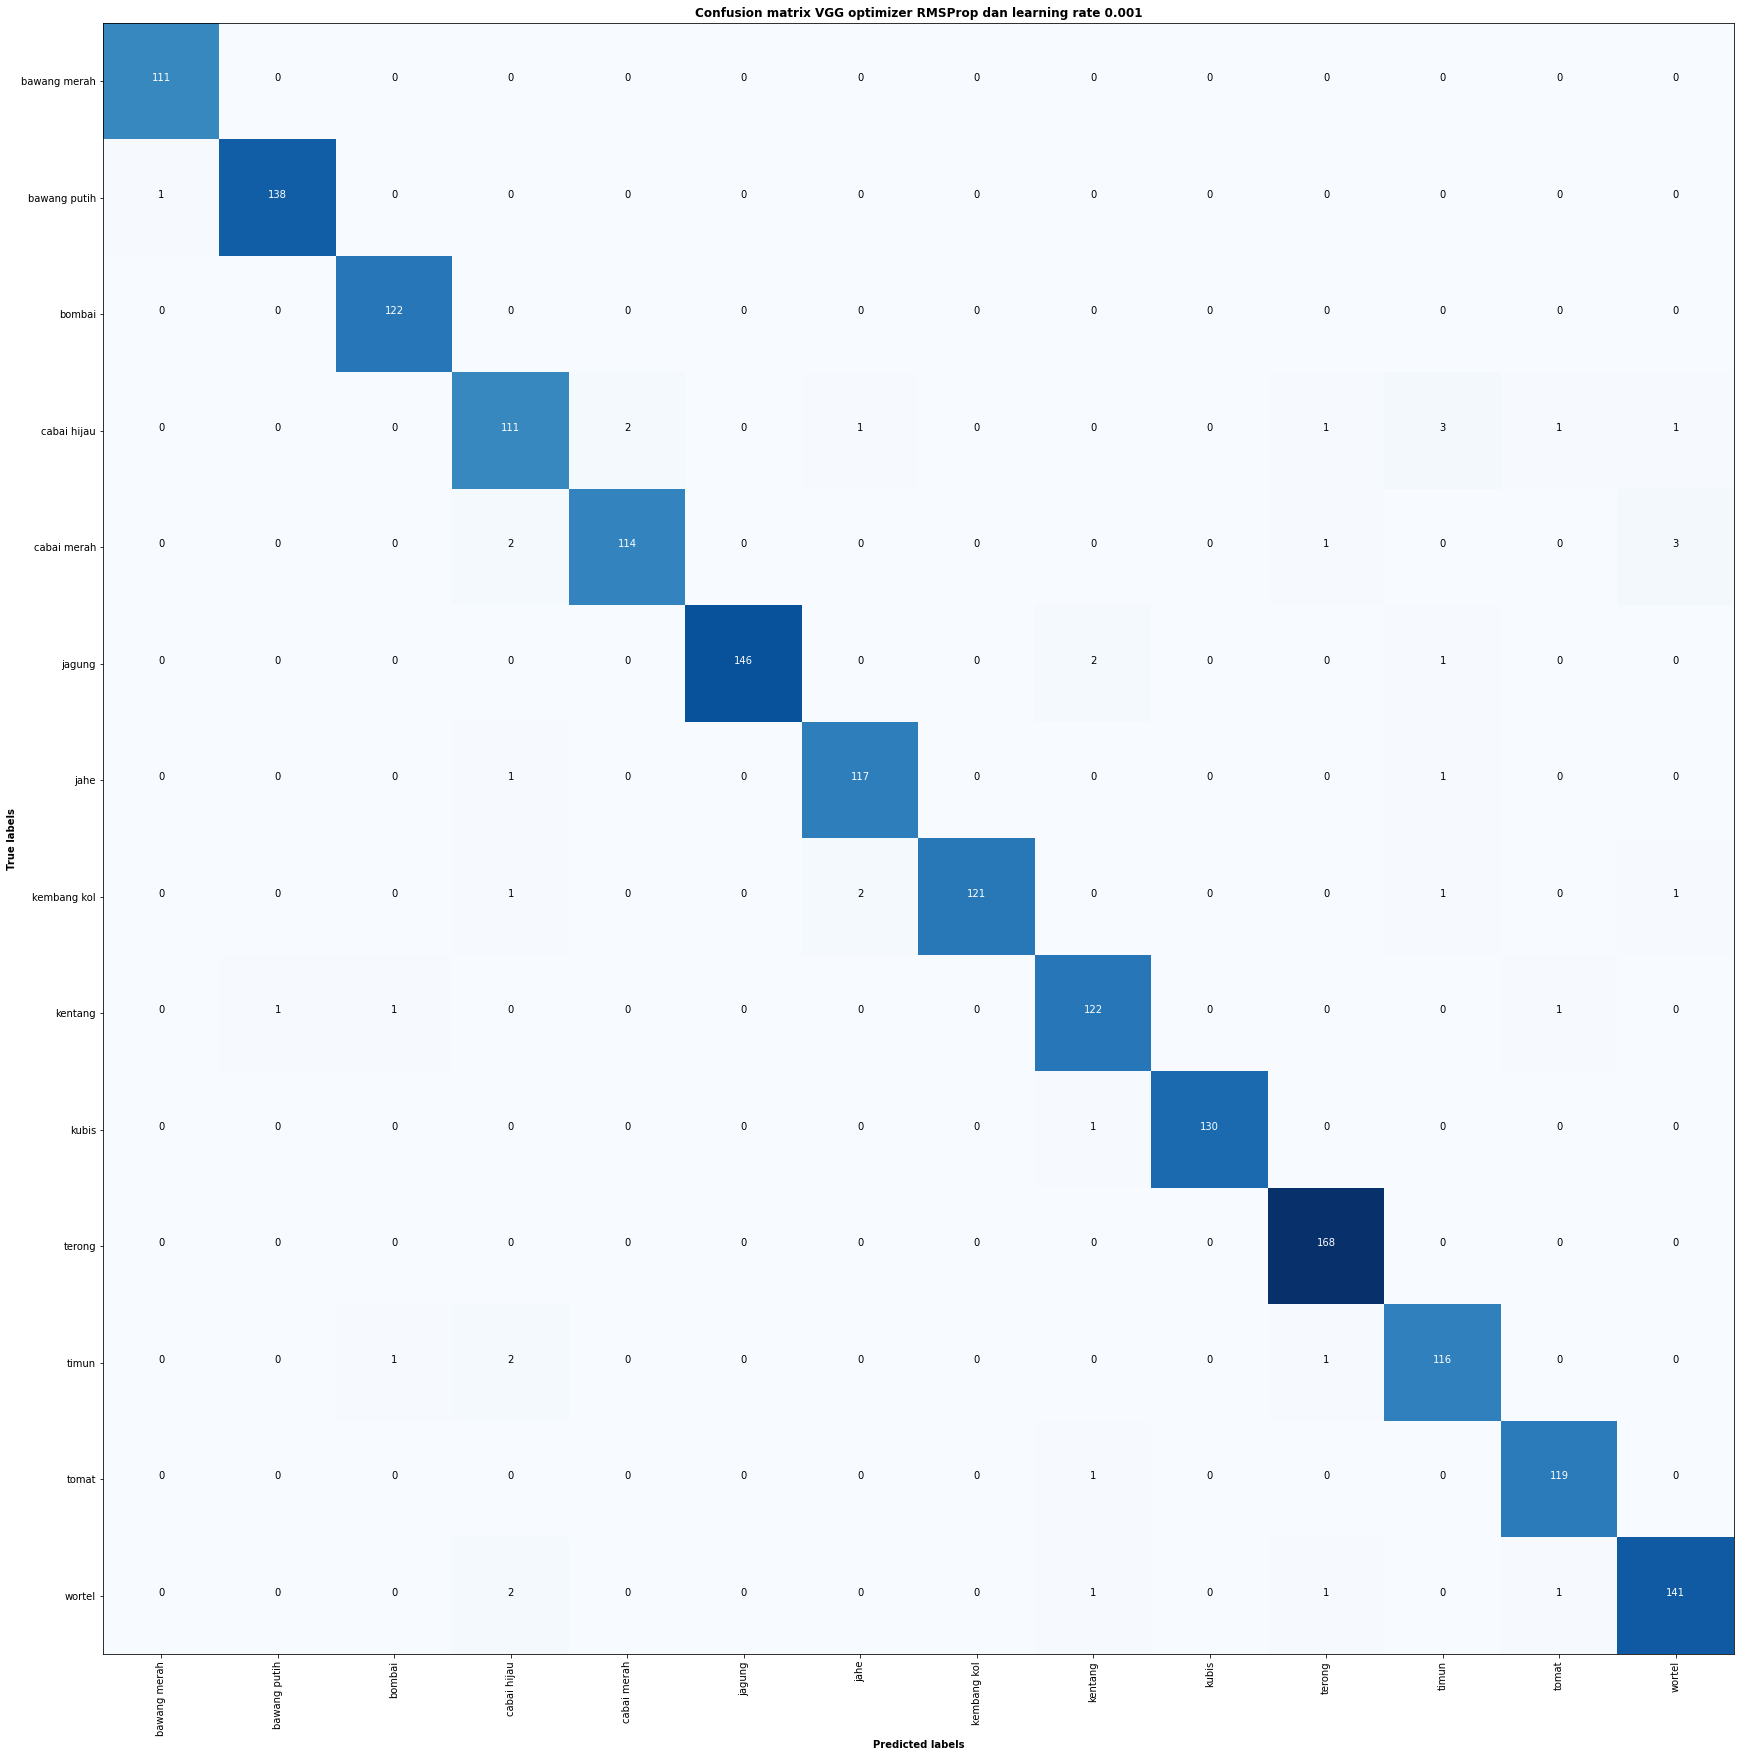

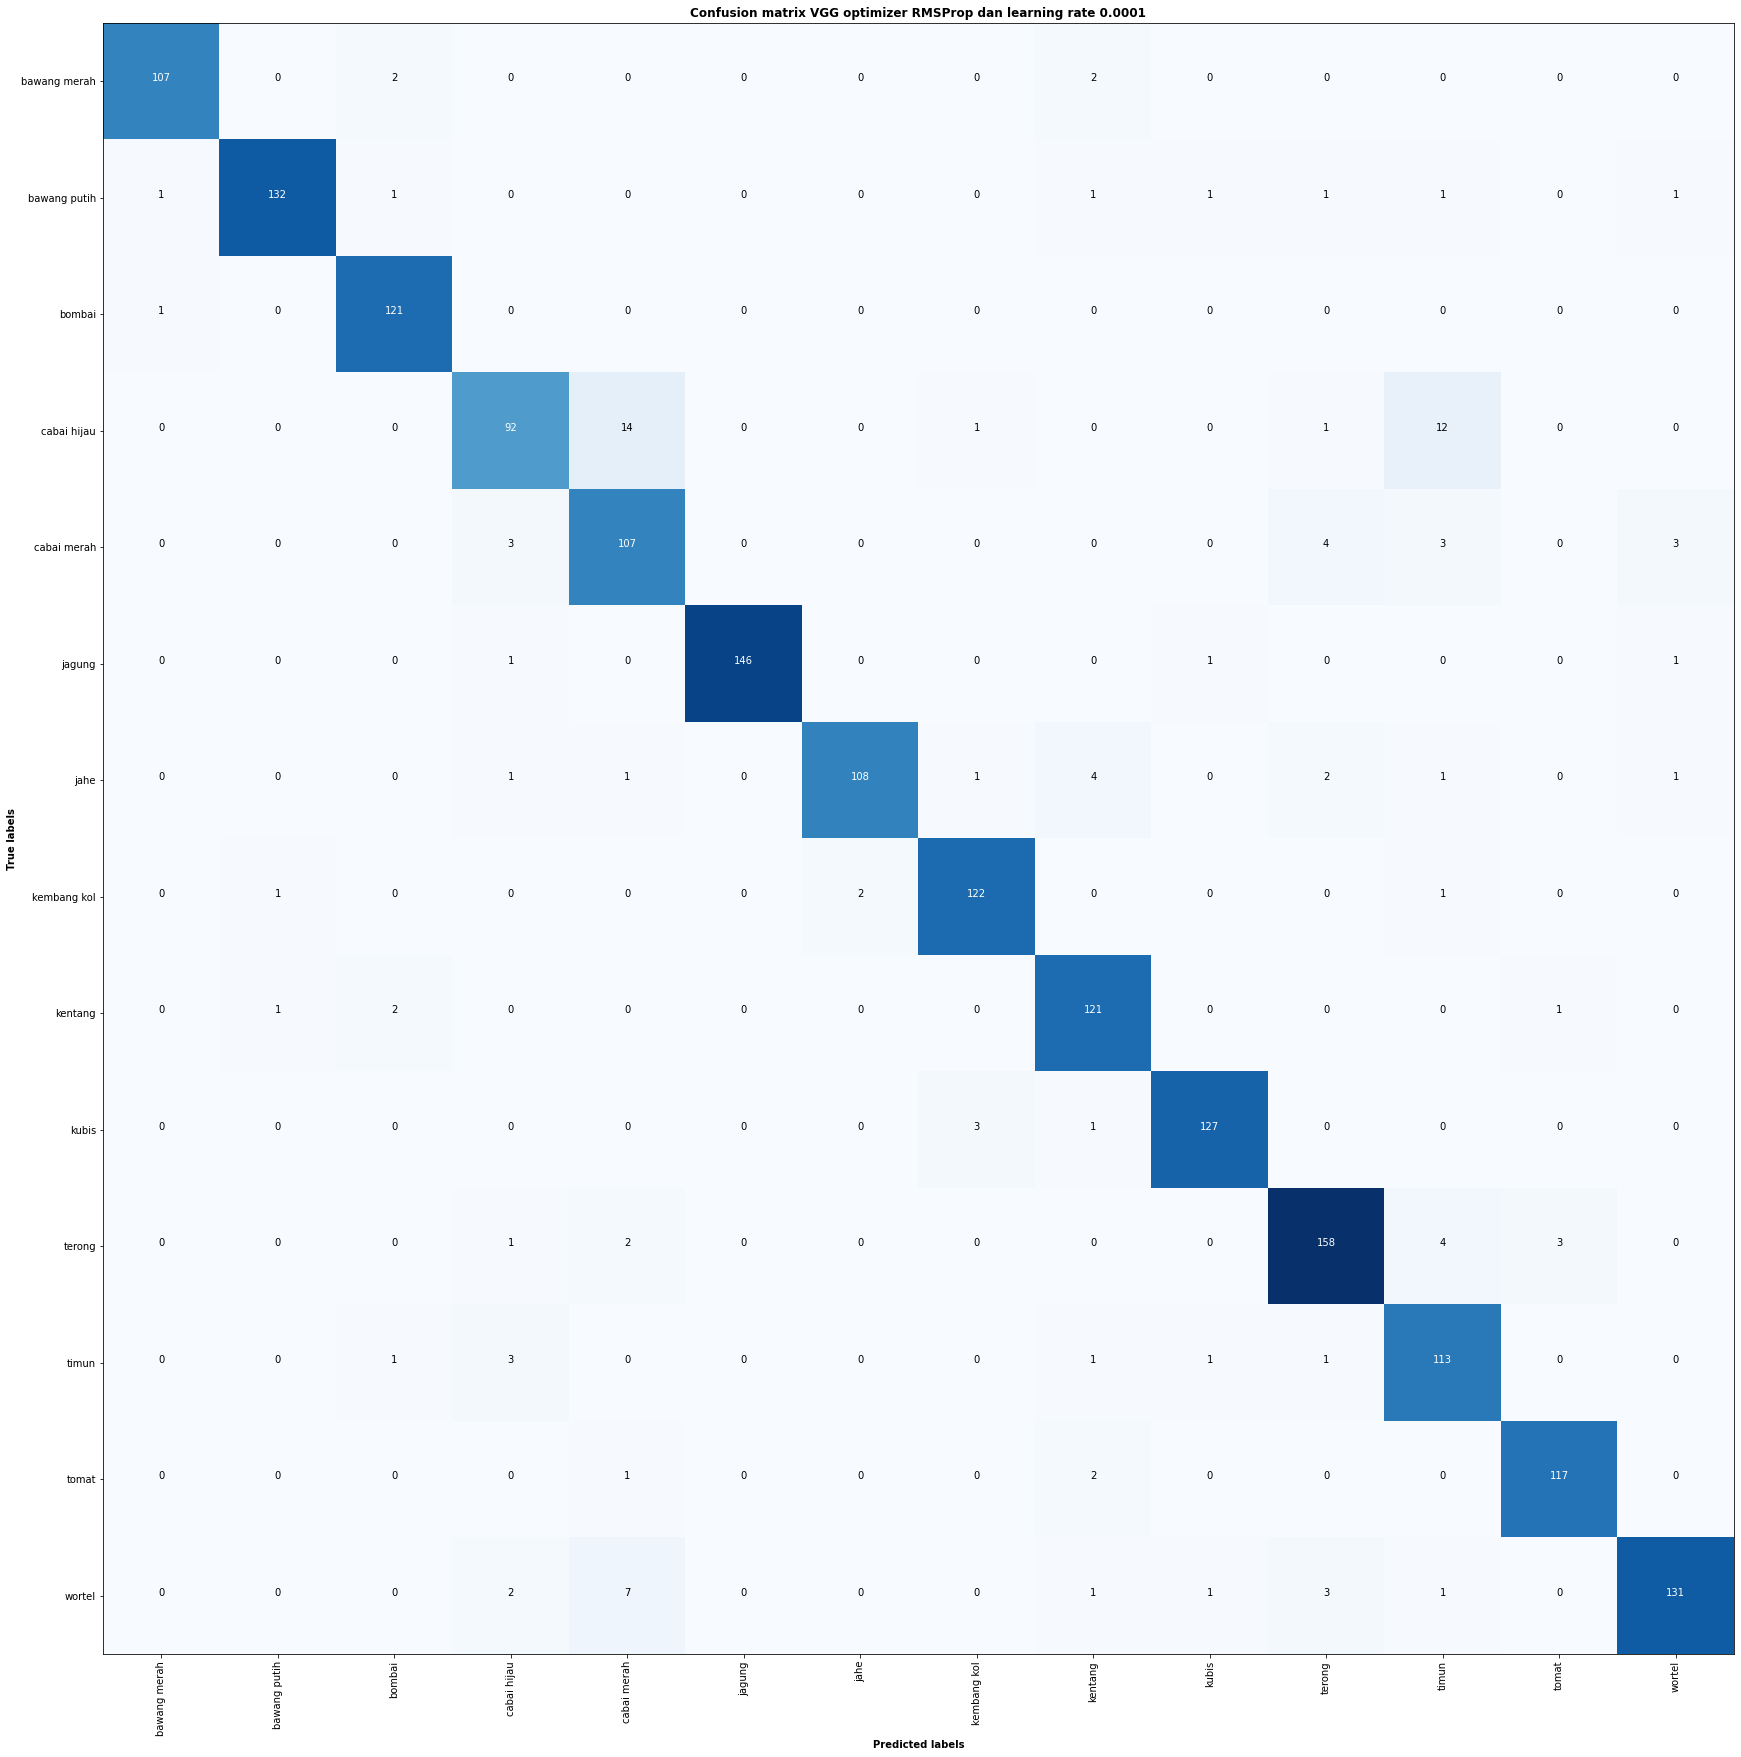

In [ ]:
# Visualisasi menggunakan confusion matrix
for (x, y, z) in (zip(res_predict, opt, lr)):
  preds = np.argmax(x, axis=1) # mengubah matrix ke array
  plot_confusion_matrix(confusion_matrix(true_classes, preds), class_labels, f"VGG optimizer {y} dan learning rate {z}")

#### 6.3.3 Visualisasi Model Resnet

In [ ]:
res_predict = [pred_resnet_adam1_70_30, pred_resnet_adam2_70_30, pred_resnet_adam3_70_30, pred_resnet_rmsprop1_70_30, pred_resnet_rmsprop2_70_30, pred_resnet_rmsprop3_70_30]
for (x, y, z) in (zip(res_predict, opt, lr)):
  print(f"\n++++++++++++++++++++++++ Model ResNet ++++++++++++++++++++++++")
  print(f"++++++++++ optimizer {y} dan learning rate {z} ++++++++++\n")

  preds = np.argmax(x, axis=1) # mengubah matrix ke array
  print(classification_report(true_classes, preds, target_names=class_labels))



++++++++++++++++++++++++ Model ResNet ++++++++++++++++++++++++
++++++++++ optimizer Adam dan learning rate 0.01 ++++++++++

              precision    recall  f1-score   support

bawang merah       0.97      0.99      0.98       111
bawang putih       0.99      0.98      0.98       139
      bombai       1.00      1.00      1.00       122
 cabai hijau       0.82      0.82      0.82       120
 cabai merah       0.87      0.92      0.89       120
      jagung       0.98      0.99      0.99       149
        jahe       0.99      0.91      0.95       119
 kembang kol       0.99      0.98      0.99       126
     kentang       0.98      1.00      0.99       125
       kubis       1.00      0.99      1.00       131
      terong       0.94      0.99      0.97       168
       timun       0.99      0.95      0.97       120
       tomat       1.00      0.97      0.99       120
      wortel       0.97      0.97      0.97       146

    accuracy                           0.96      1816
   macro 

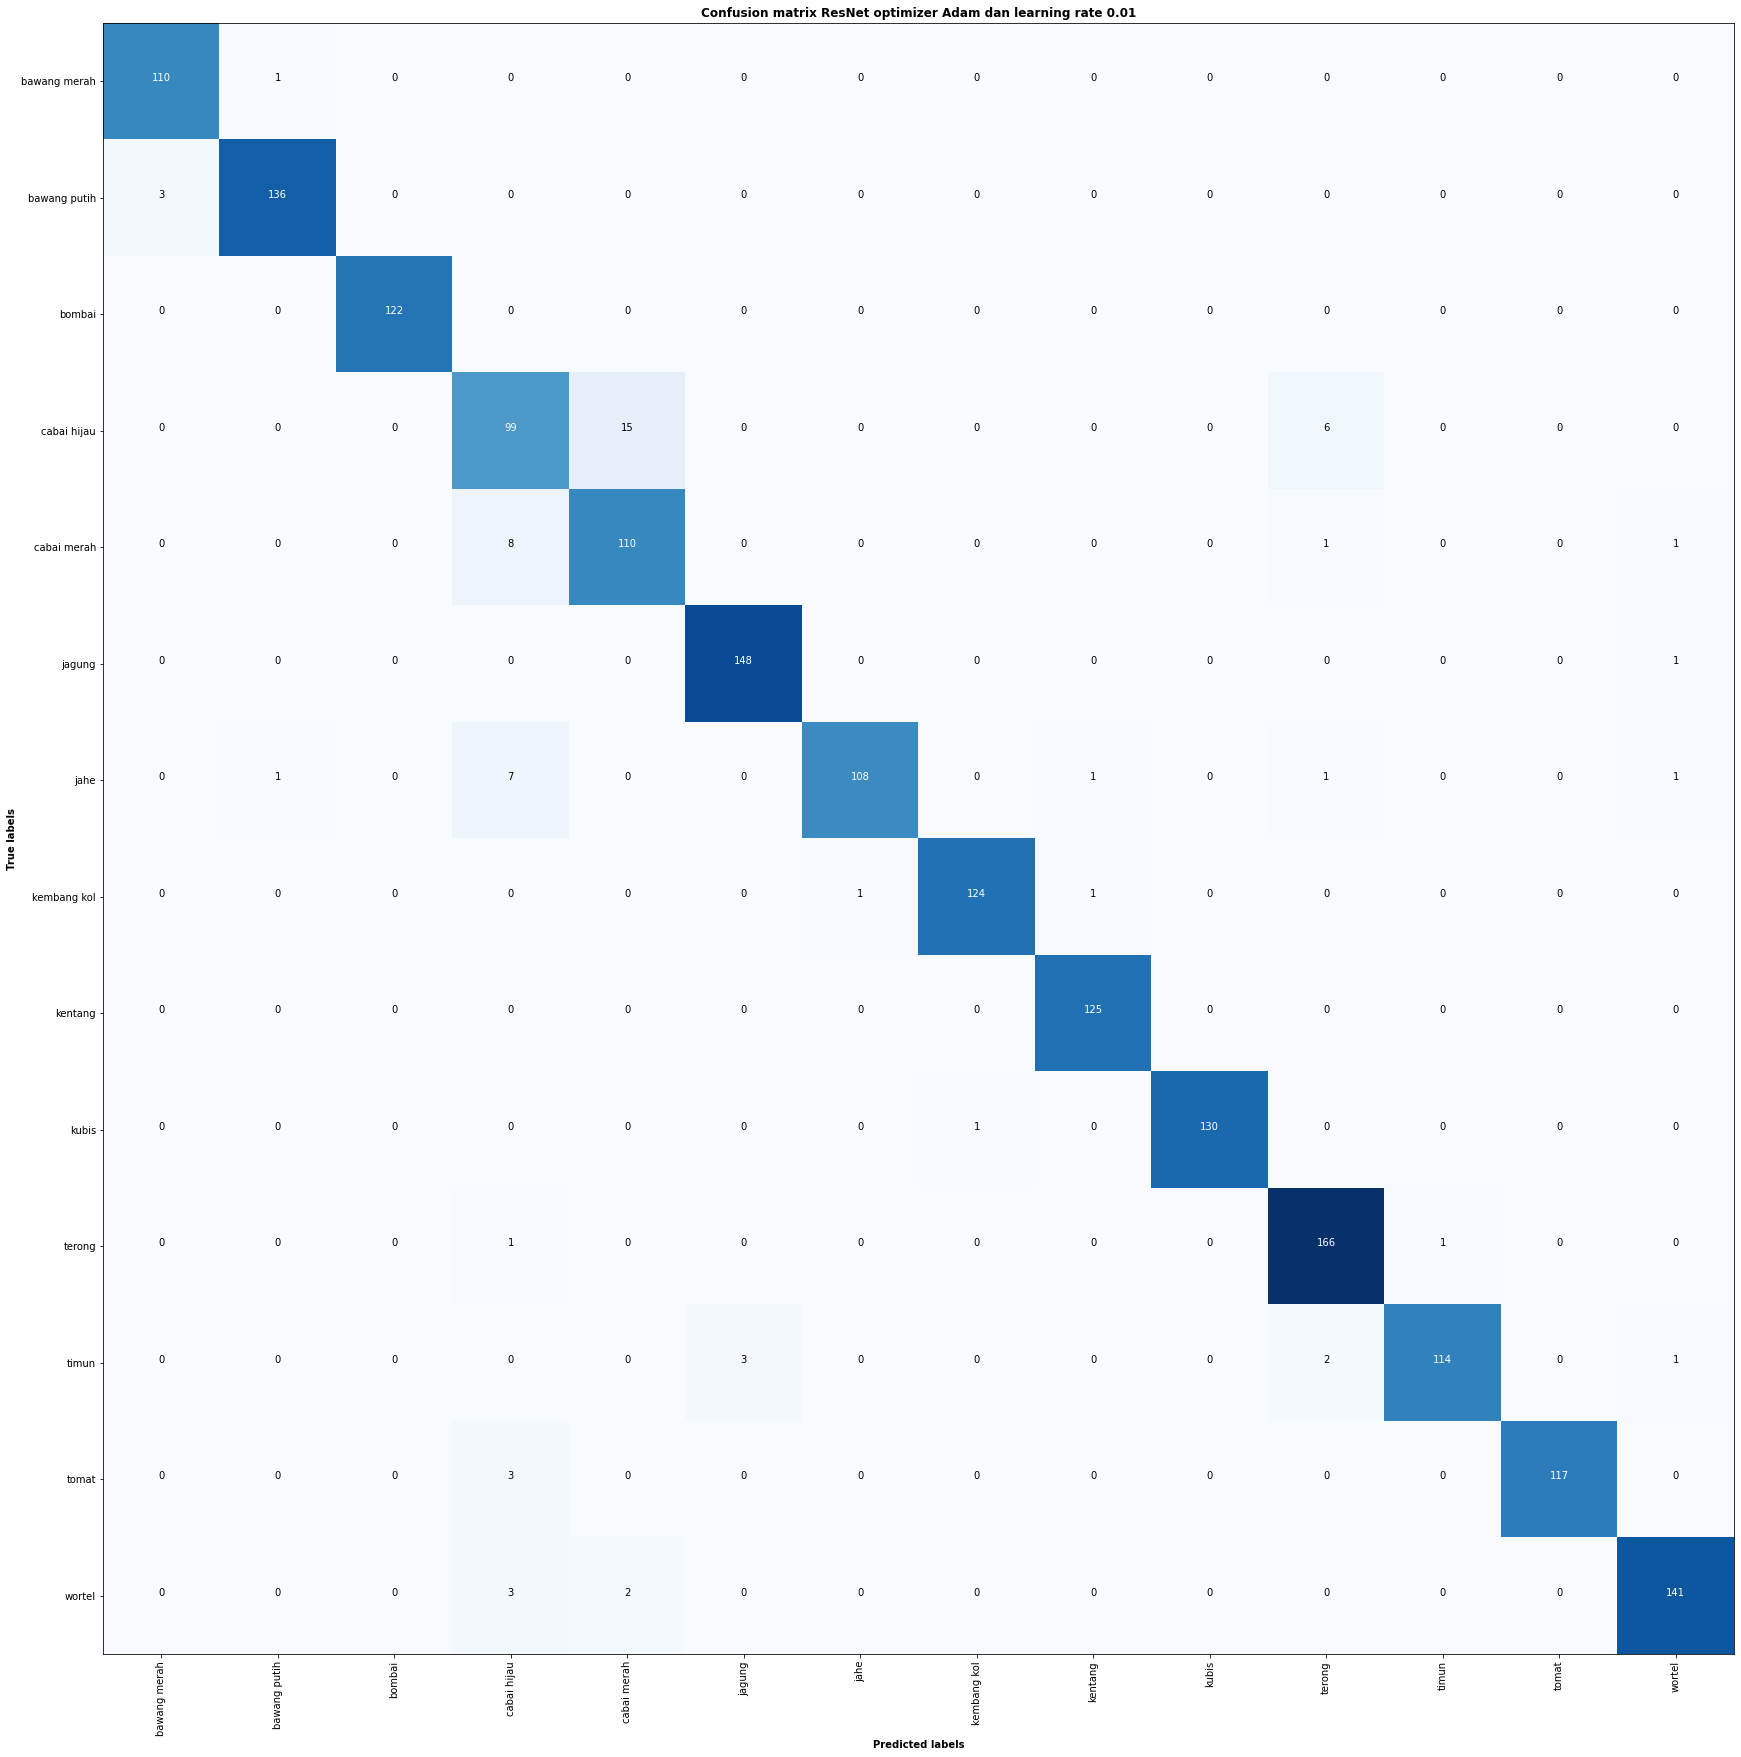

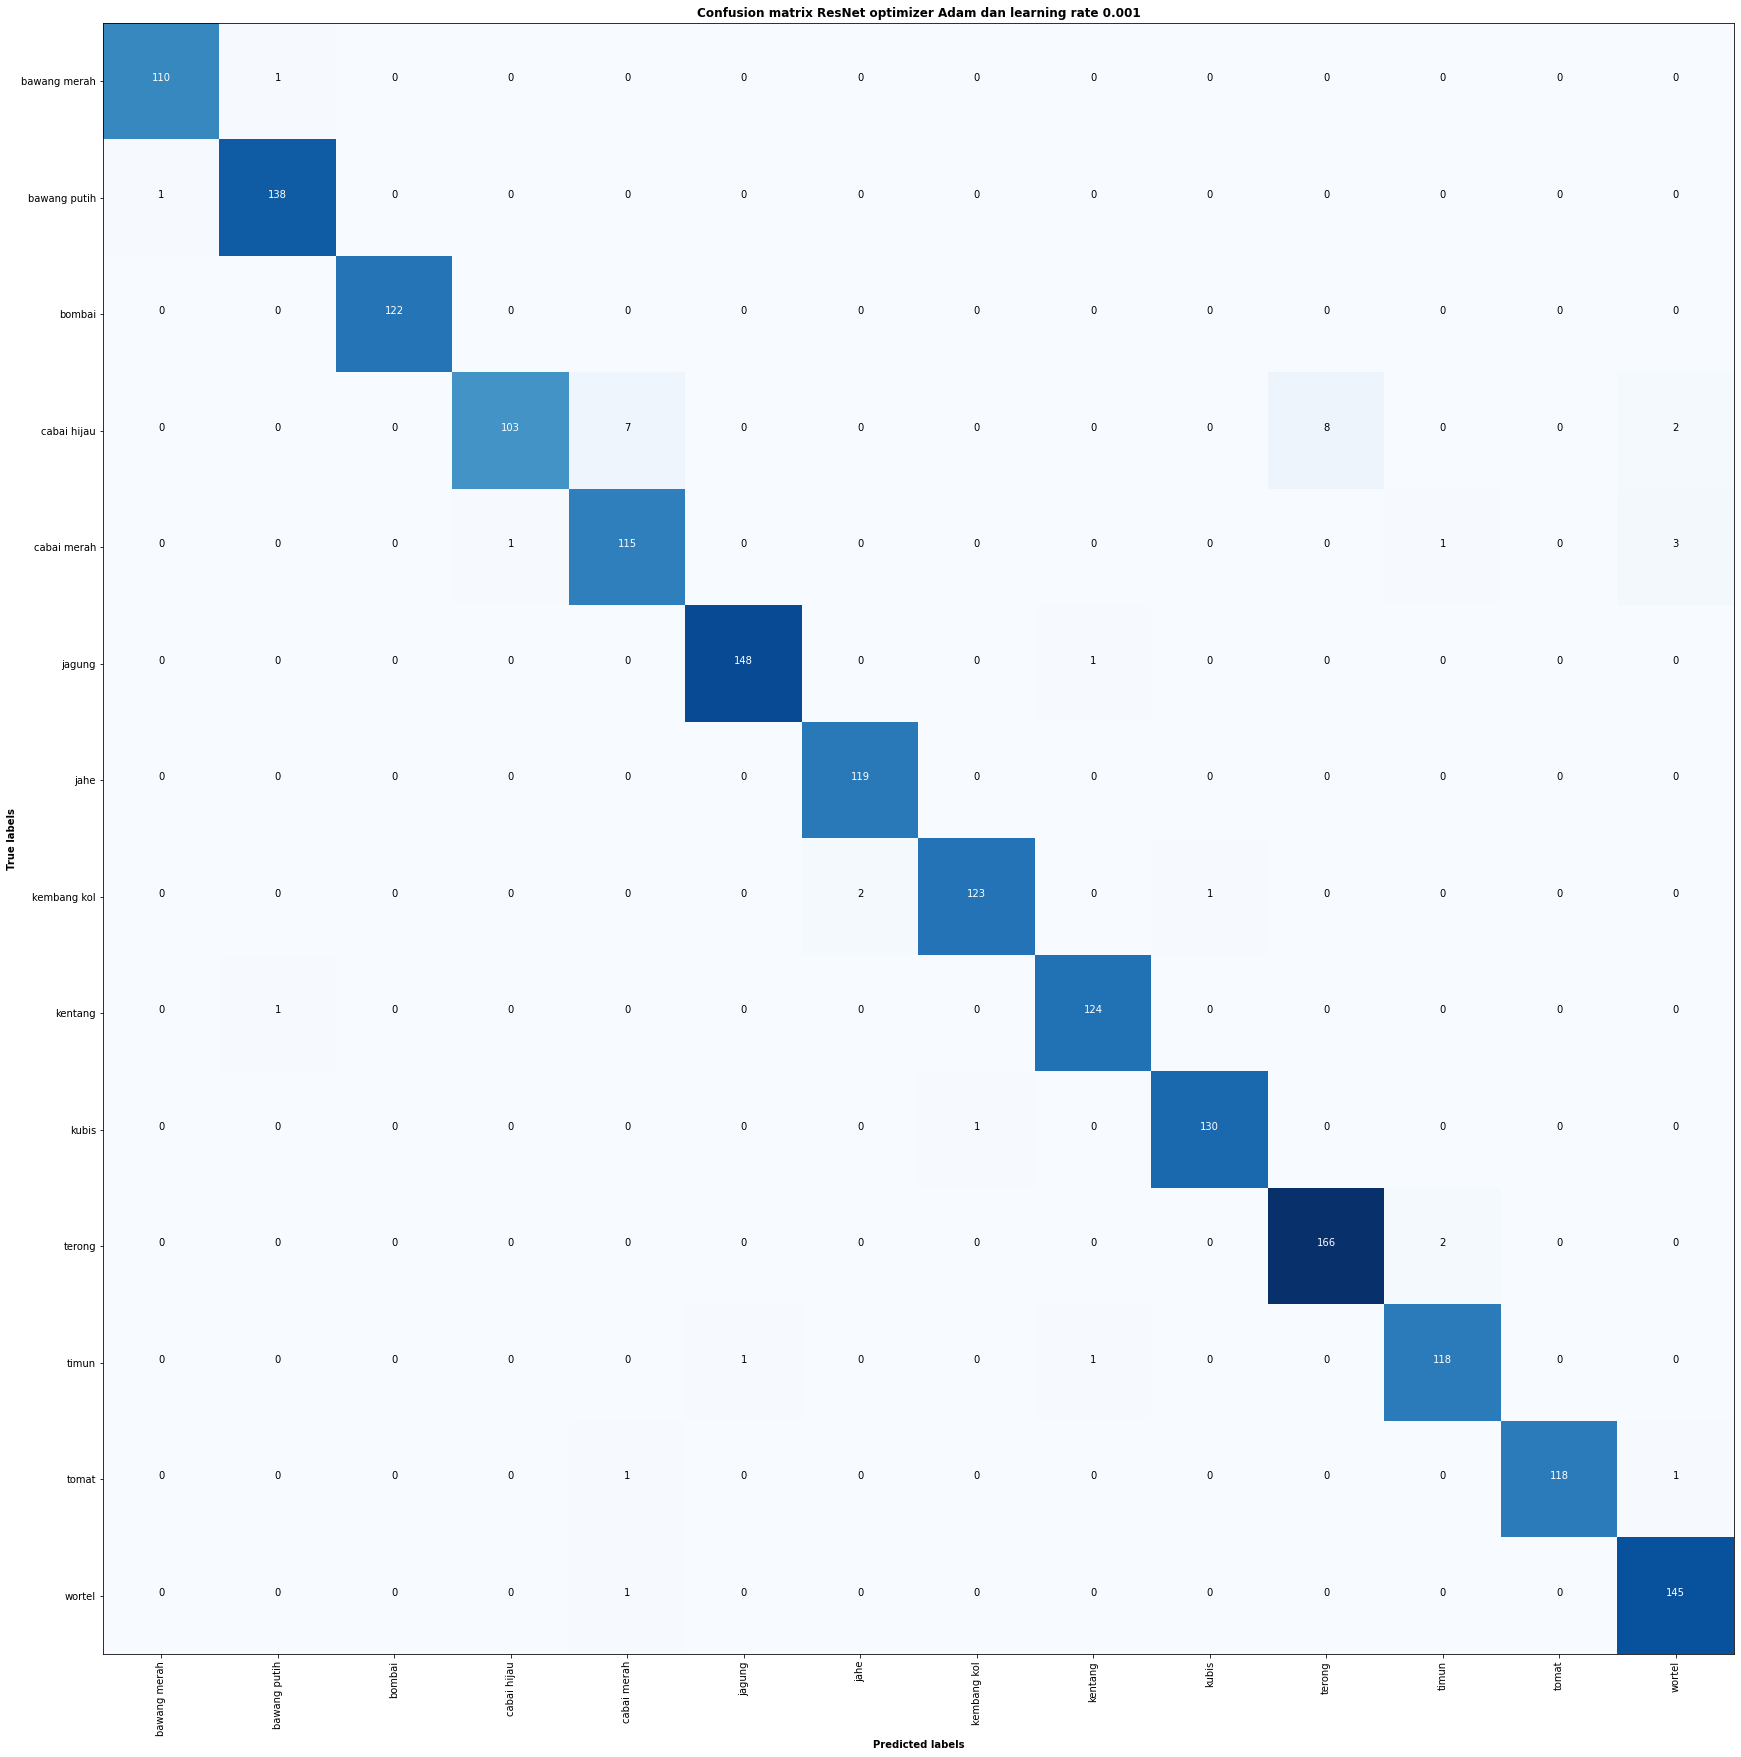

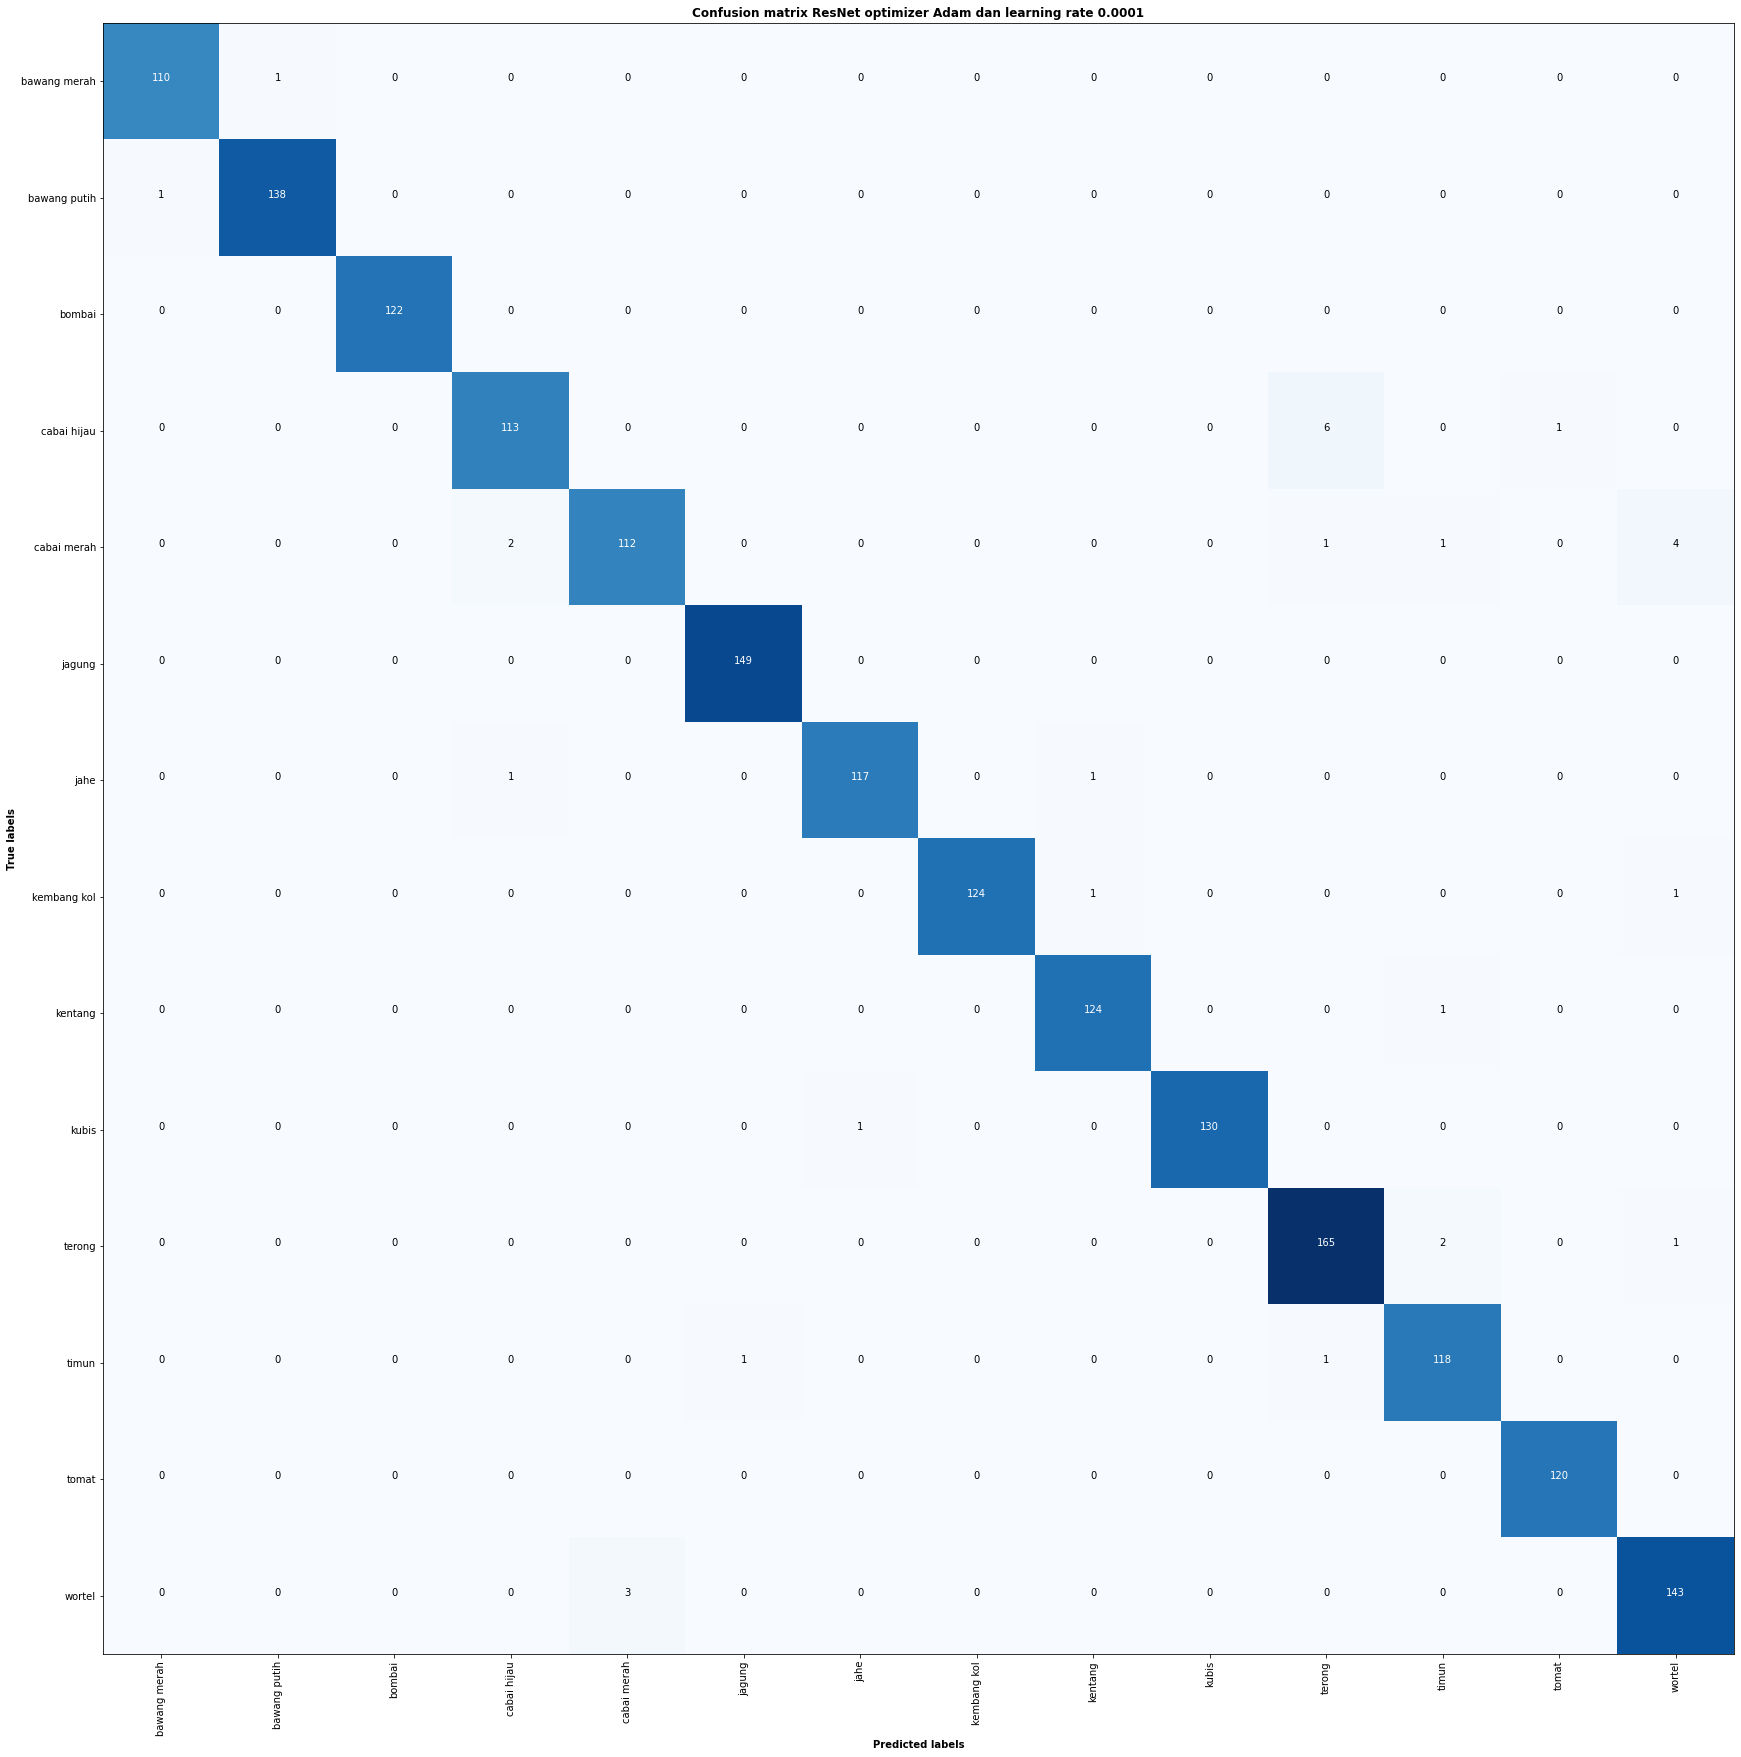

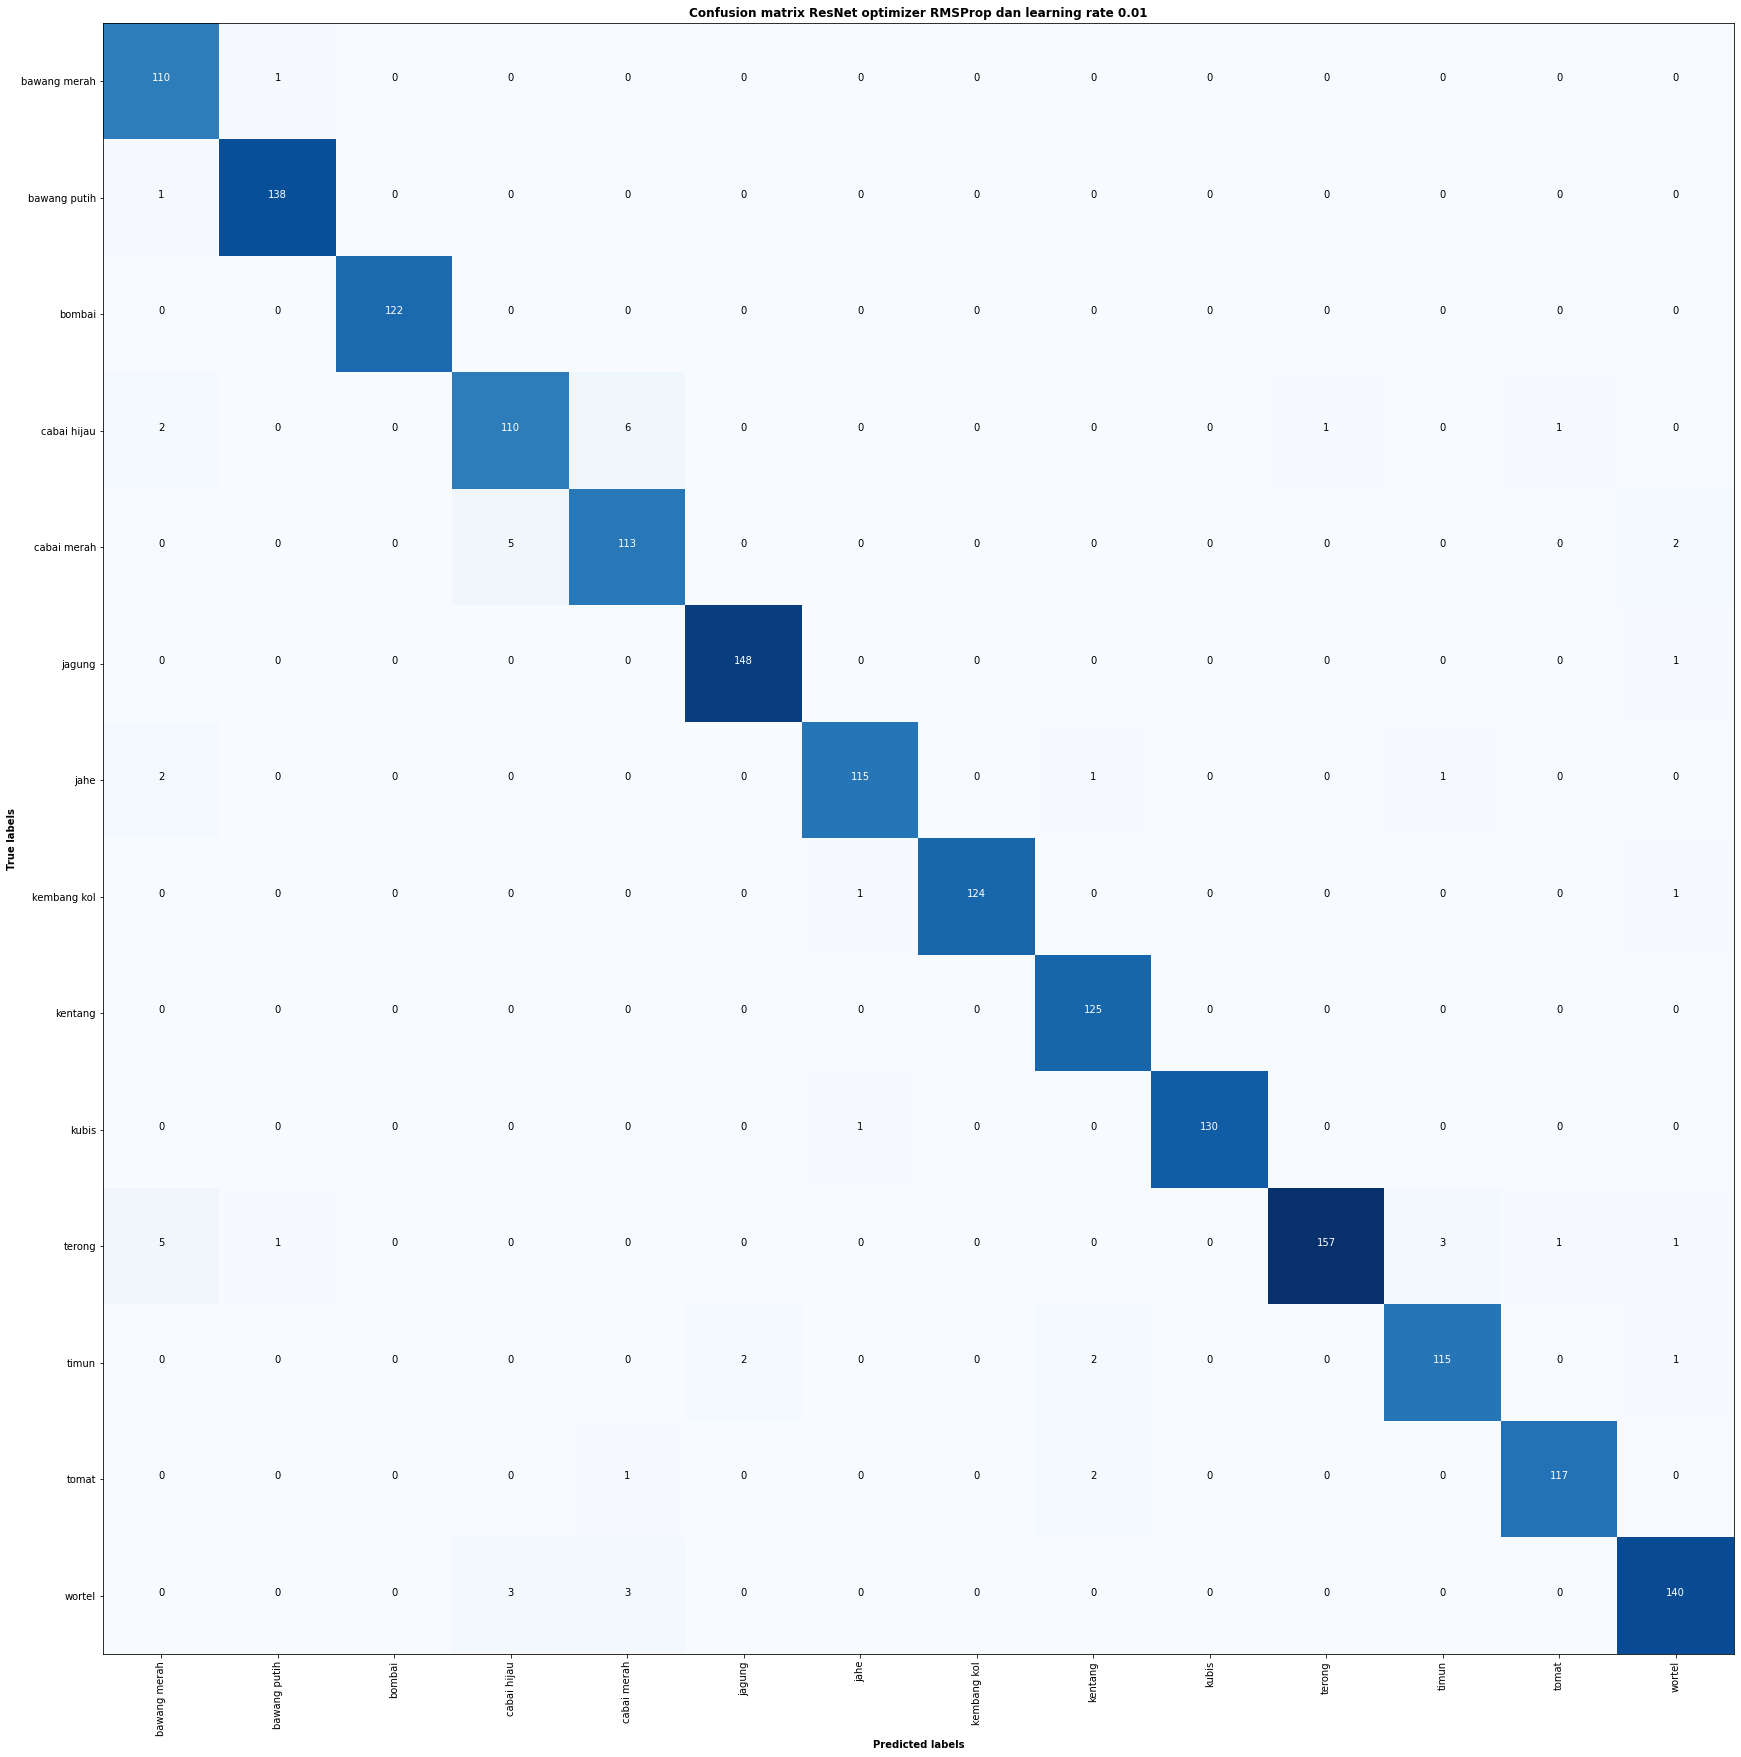

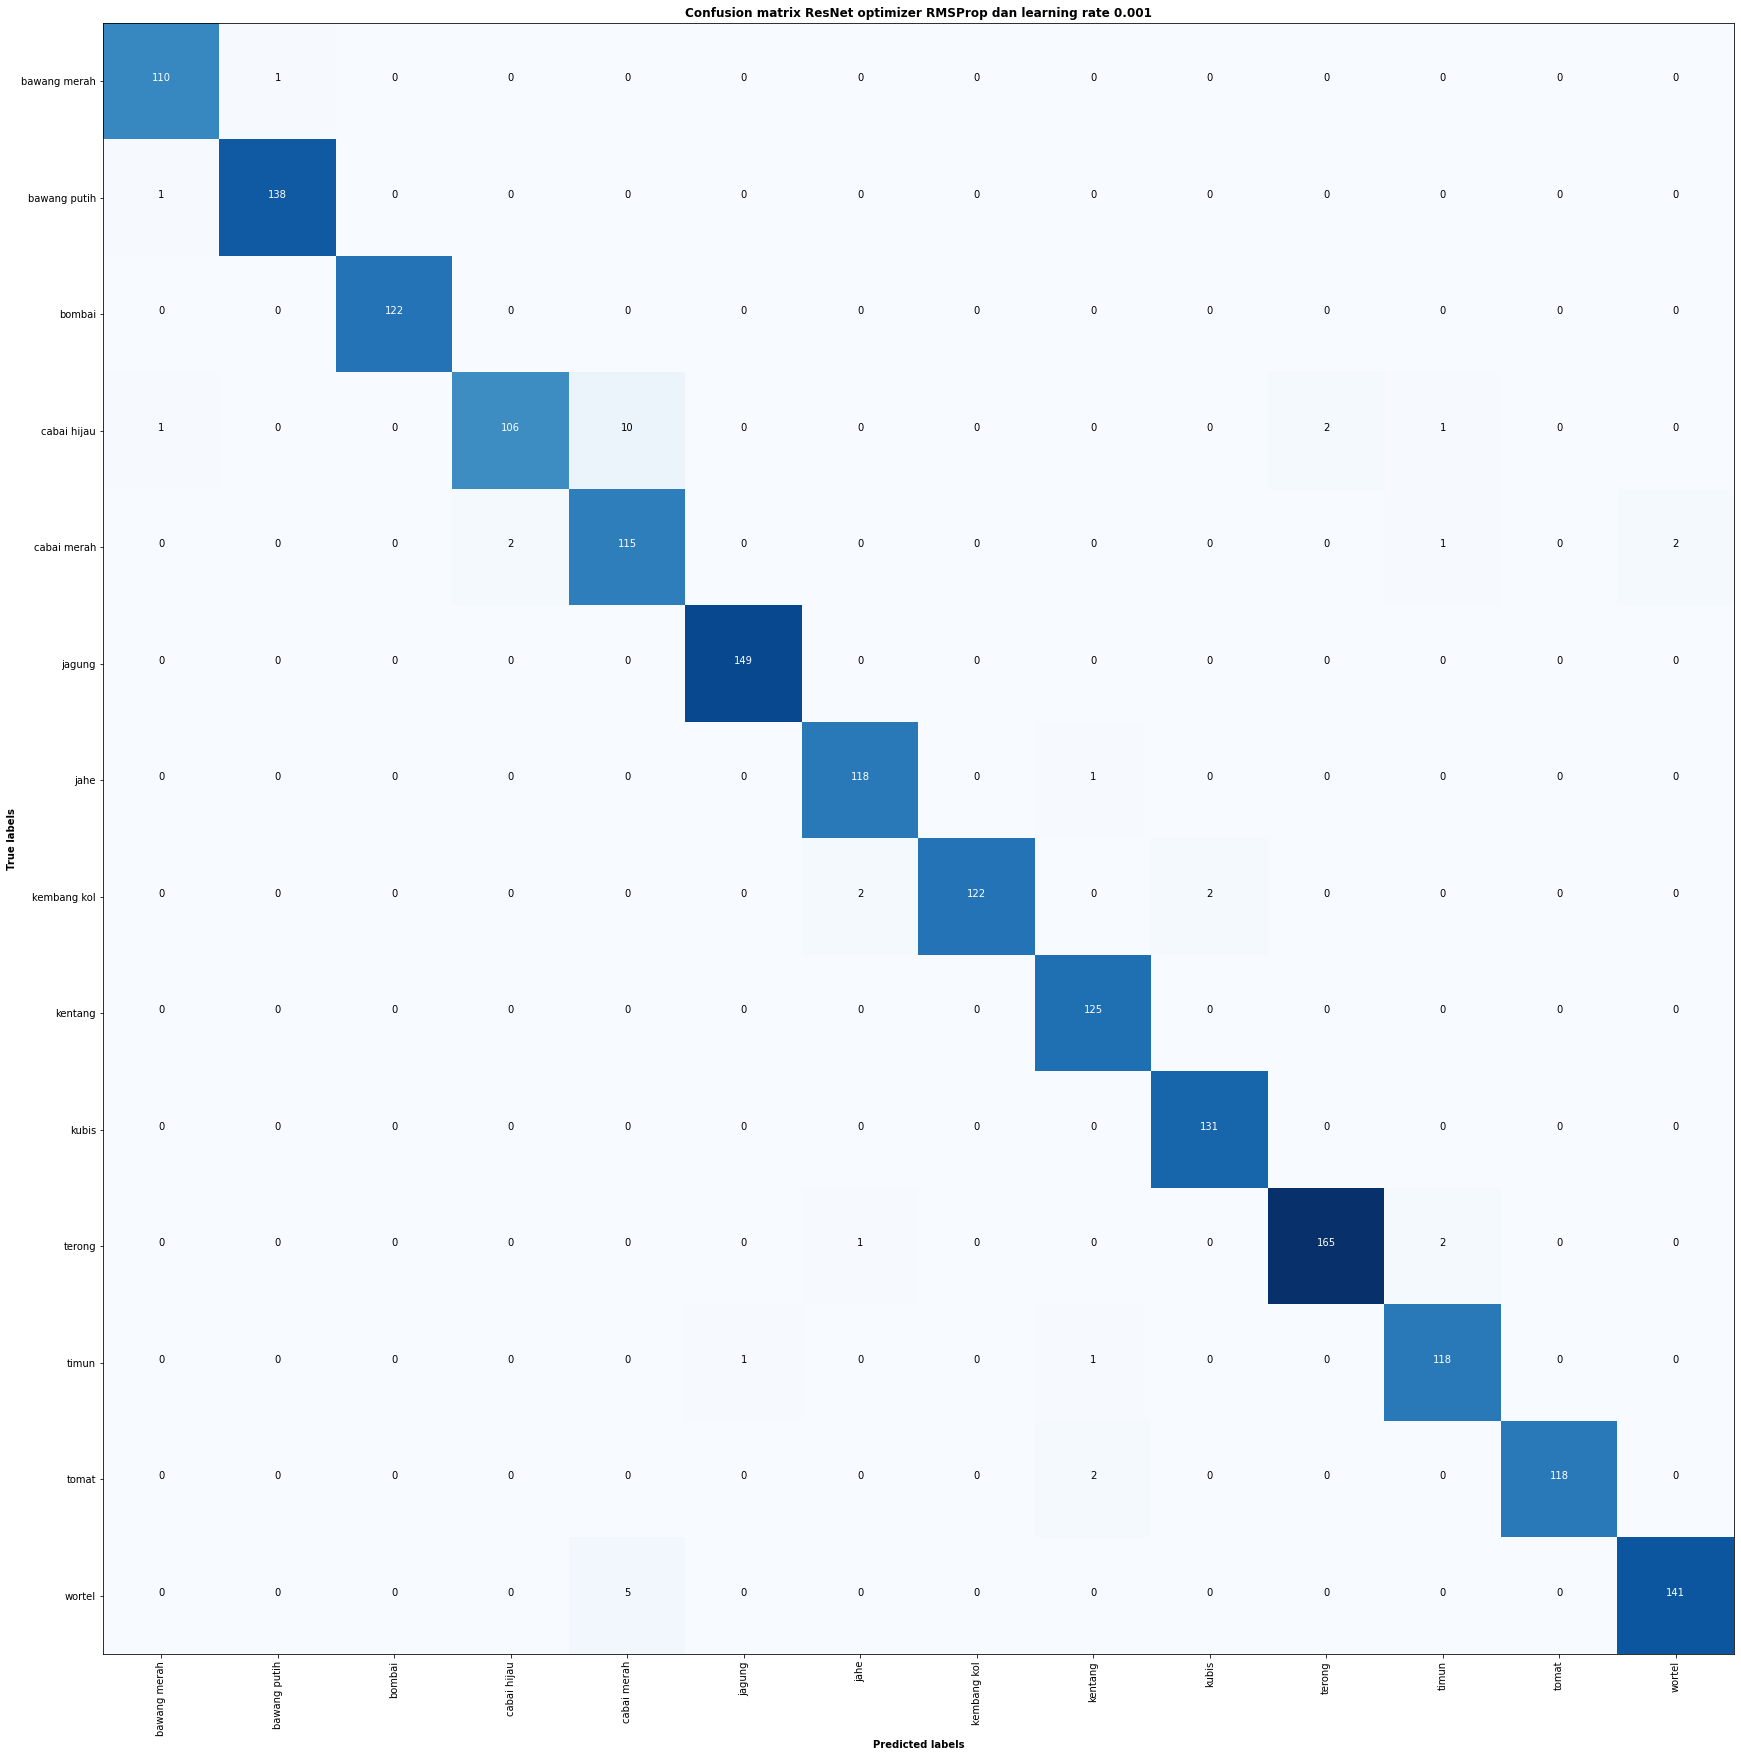

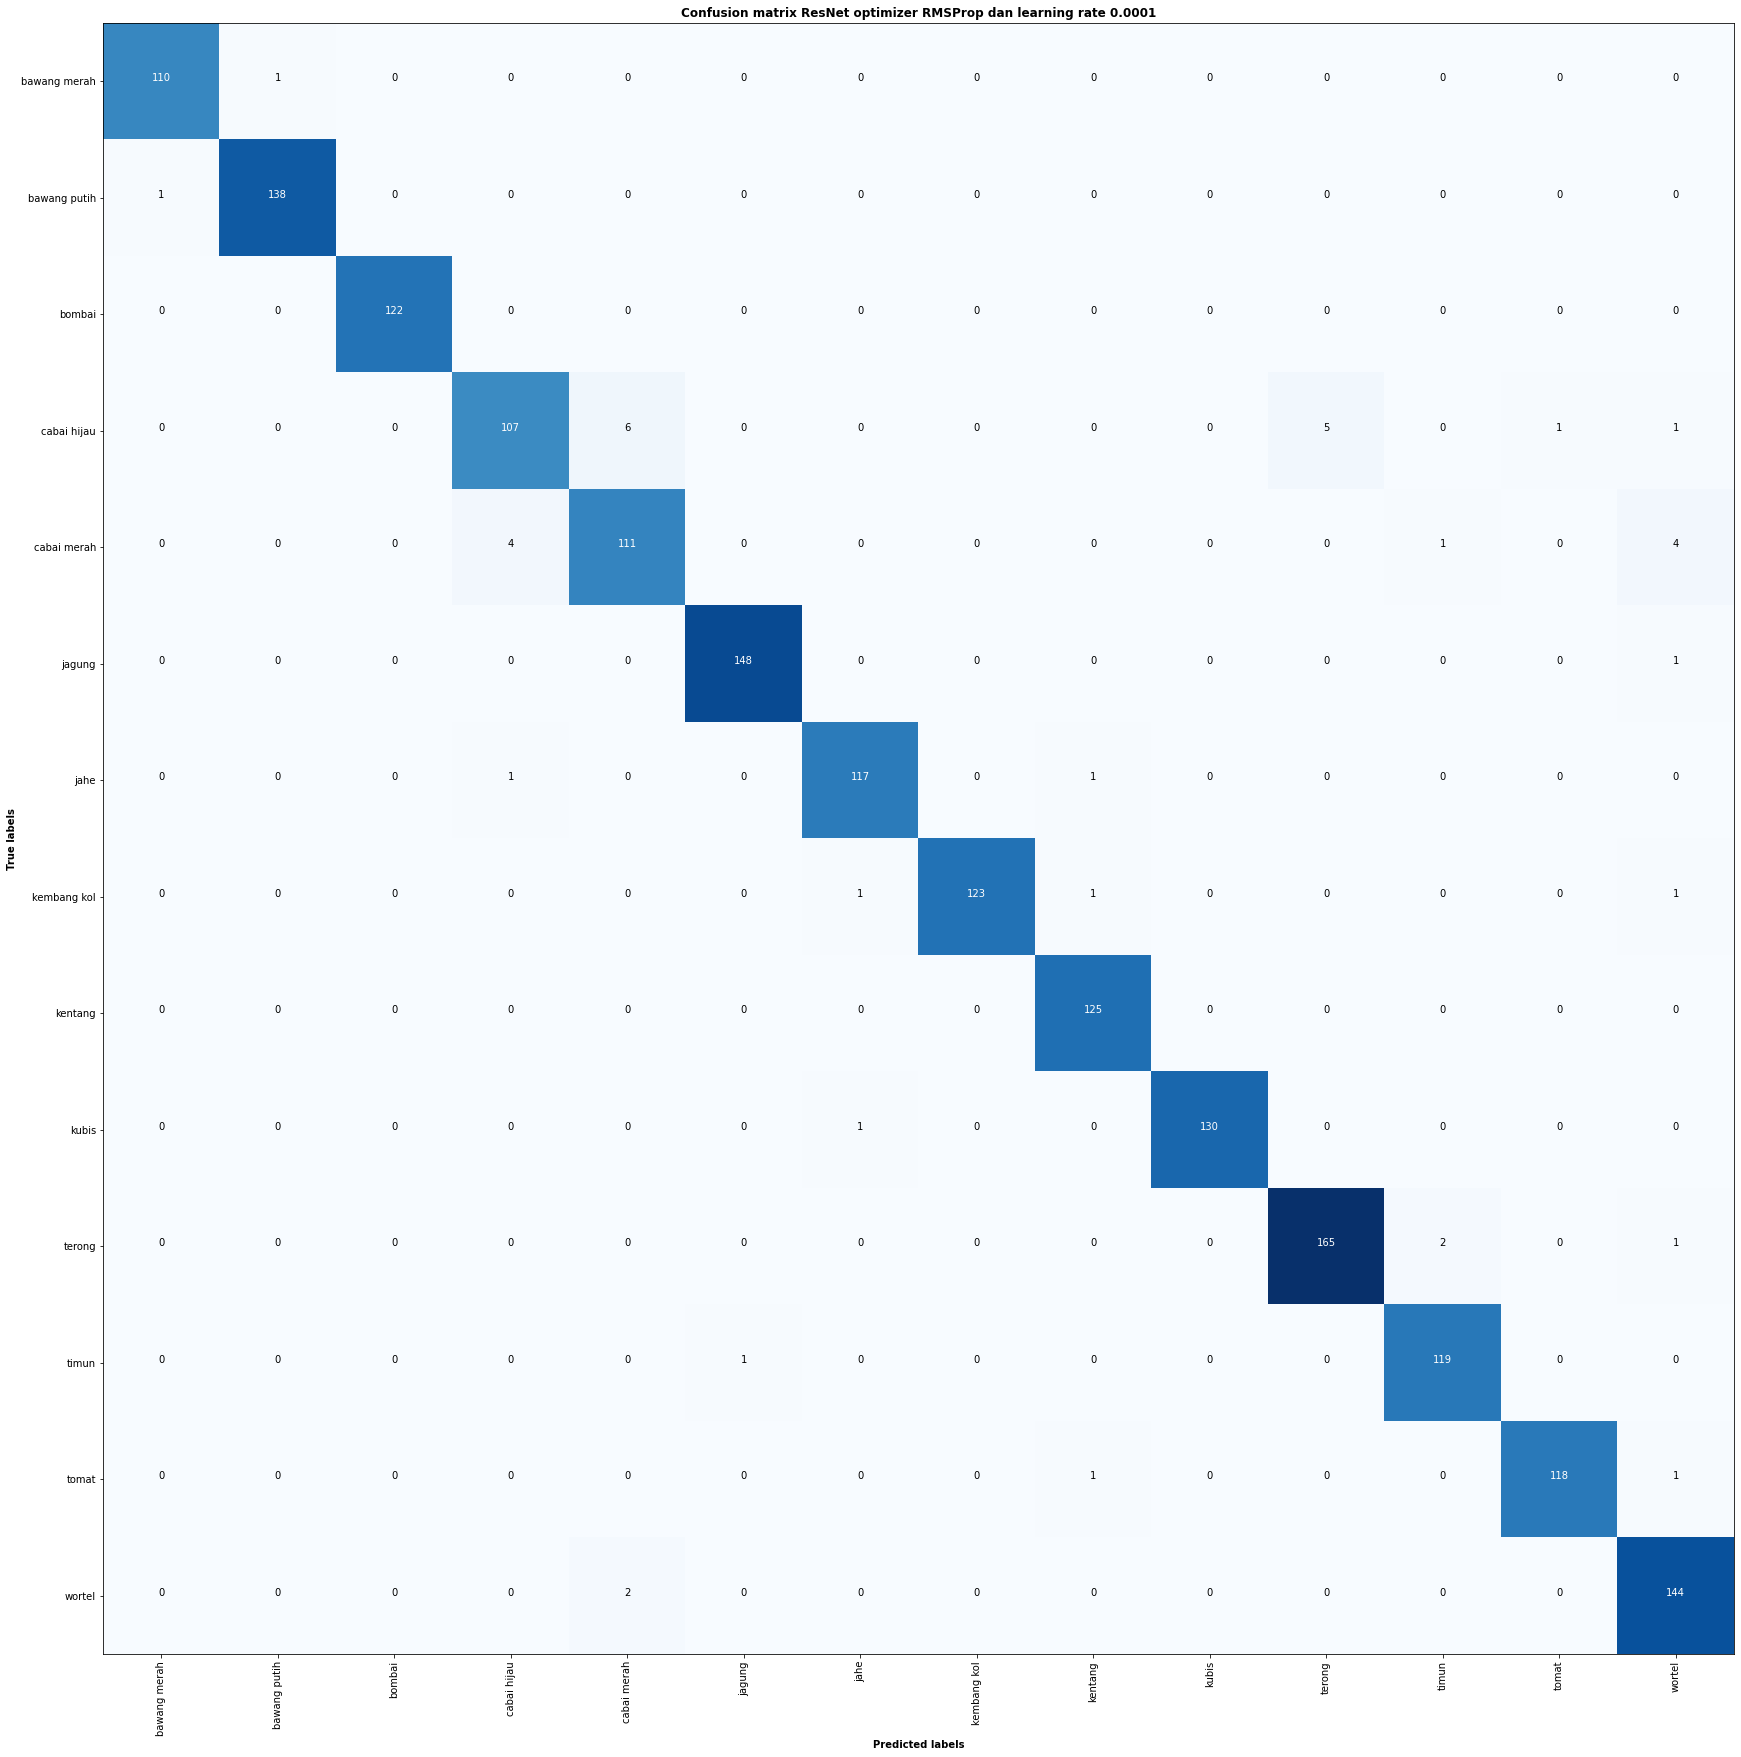

In [ ]:
# Visualisasi menggunakan confusion matrix
for (x, y, z) in (zip(res_predict, opt, lr)):
  preds = np.argmax(x, axis=1) # mengubah matrix ke array
  plot_confusion_matrix(confusion_matrix(true_classes, preds), class_labels, f"ResNet optimizer {y} dan learning rate {z}")

#### 6.3.5 Visualisasi Model Rancangan Sendiri

In [ ]:
res_predict = [pred_own_adam1_70_30, pred_own_adam2_70_30, pred_own_adam3_70_30, pred_own_rmsprop1_70_30, pred_own_rmsprop2_70_30, pred_own_rmsprop3_70_30]
for (x, y, z) in (zip(res_predict, opt, lr)):
  print(f"\n++++++++++++++++++++++++ Model OWN ++++++++++++++++++++++++")
  print(f"++++++++++ optimizer {y} dan learning rate {z} ++++++++++\n")

  preds = np.argmax(x, axis=1) # mengubah matrix ke array
  print(classification_report(true_classes, preds, target_names=class_labels))



++++++++++++++++++++++++ Model OWN ++++++++++++++++++++++++
++++++++++ optimizer Adam dan learning rate 0.01 ++++++++++

              precision    recall  f1-score   support

bawang merah       0.81      0.54      0.65       111
bawang putih       1.00      0.65      0.79       139
      bombai       0.74      0.69      0.71       122
 cabai hijau       1.00      0.42      0.60       120
 cabai merah       0.95      0.43      0.59       120
      jagung       0.19      0.99      0.32       149
        jahe       0.87      0.45      0.60       119
 kembang kol       0.86      0.71      0.78       126
     kentang       0.98      0.47      0.64       125
       kubis       0.98      0.66      0.79       131
      terong       0.96      0.78      0.86       168
       timun       0.98      0.48      0.65       120
       tomat       0.97      0.62      0.76       120
      wortel       0.98      0.55      0.71       146

    accuracy                           0.61      1816
   macro avg

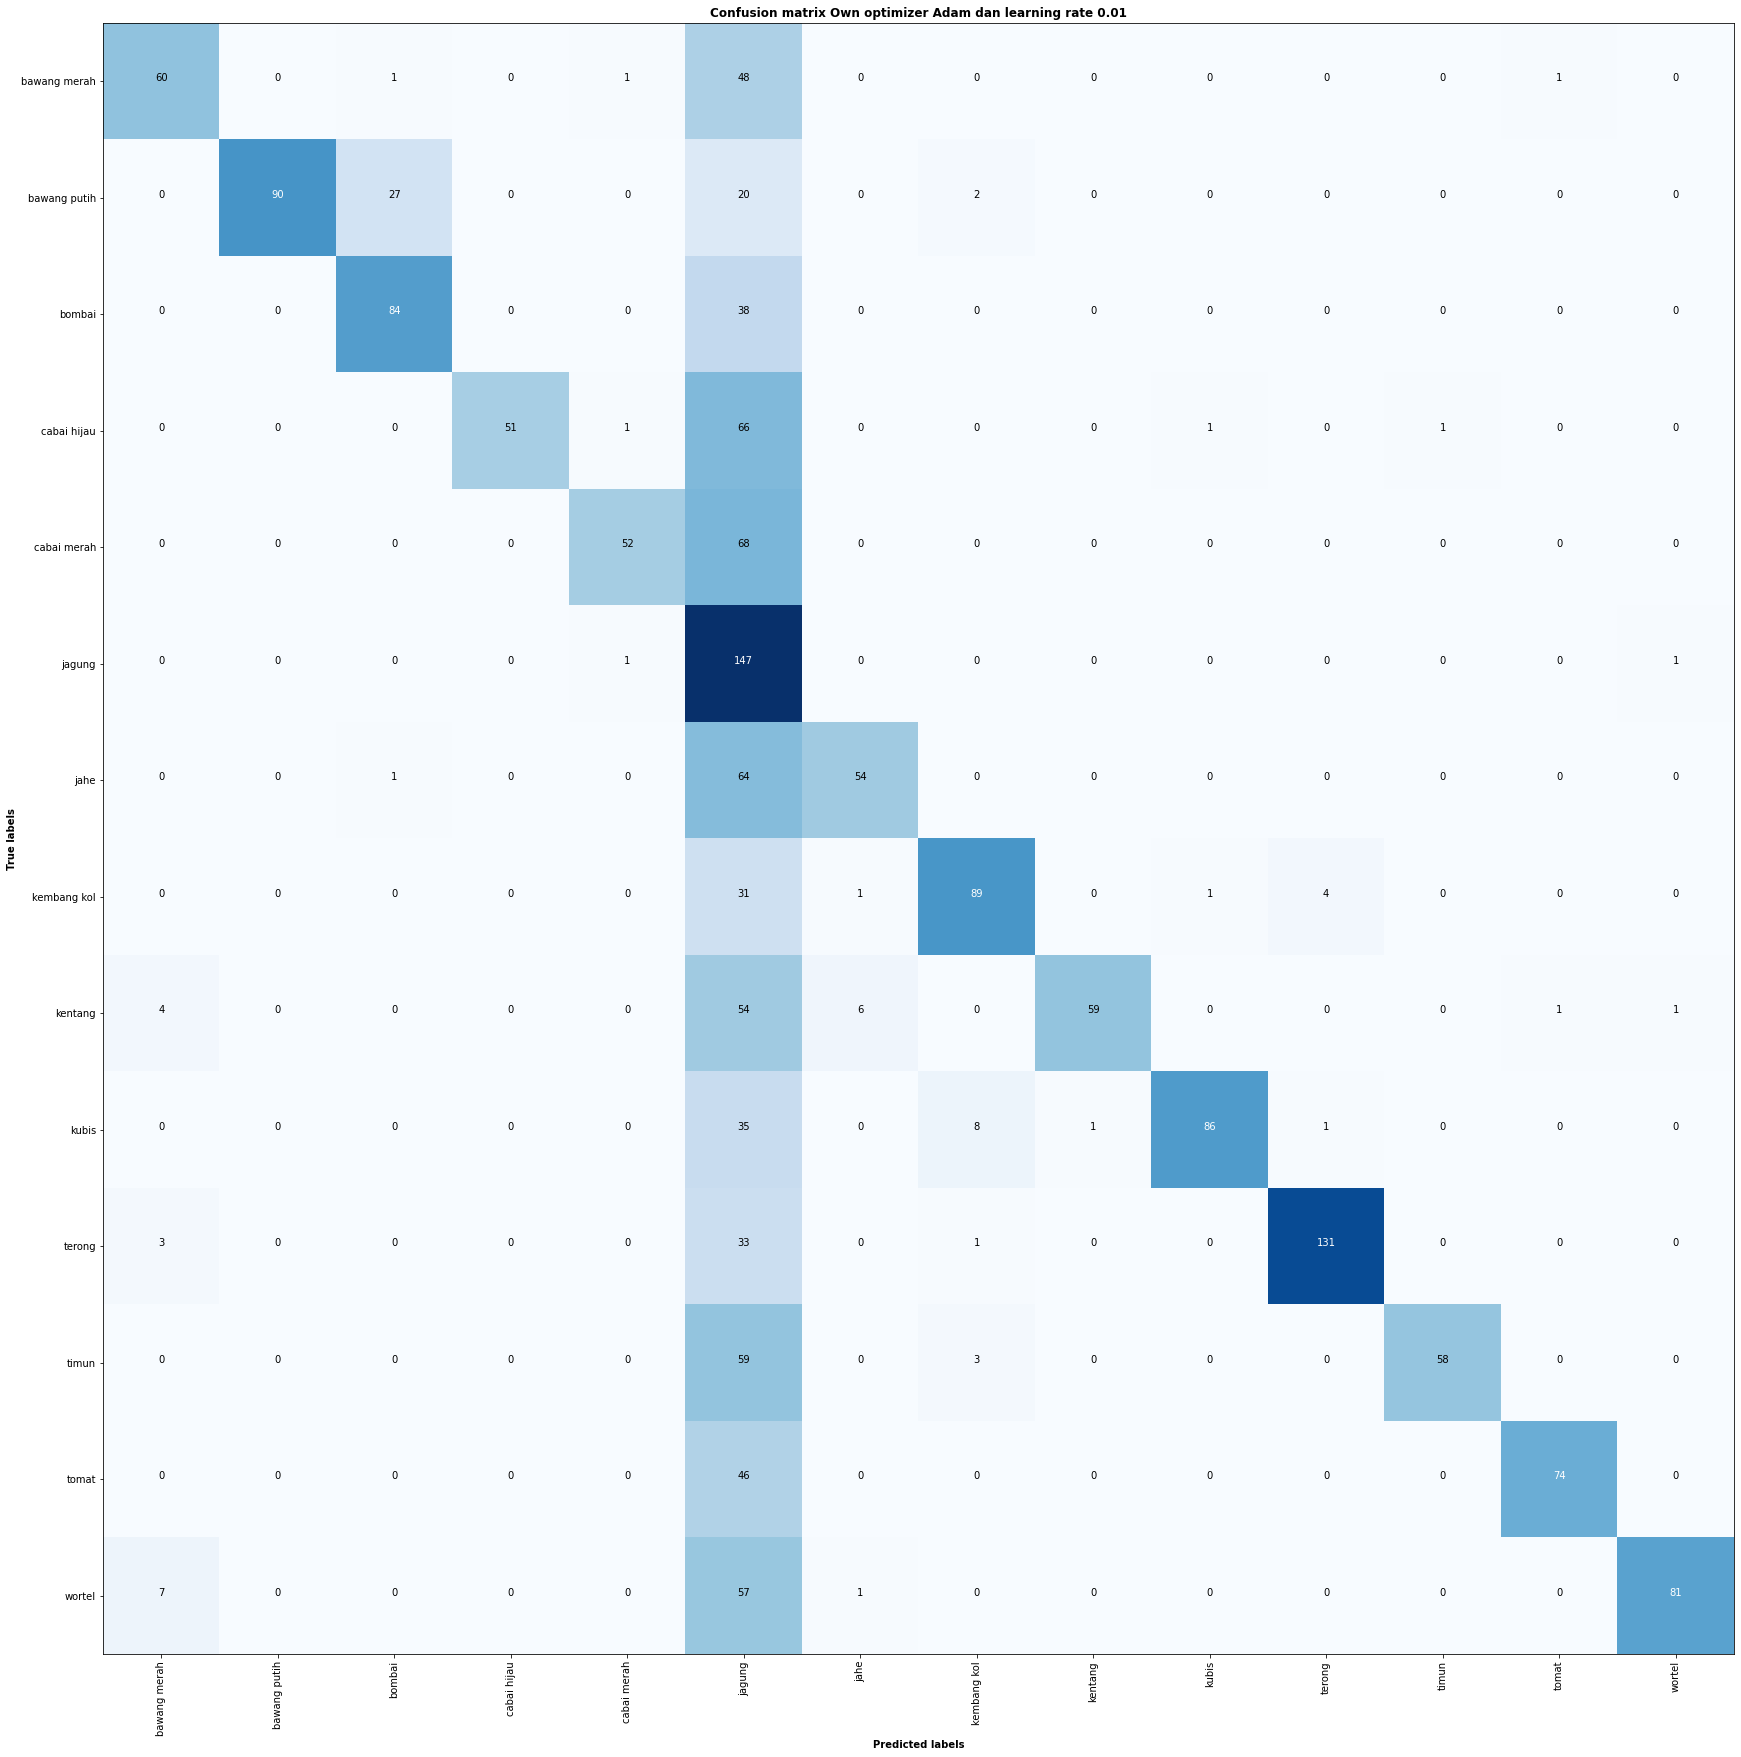

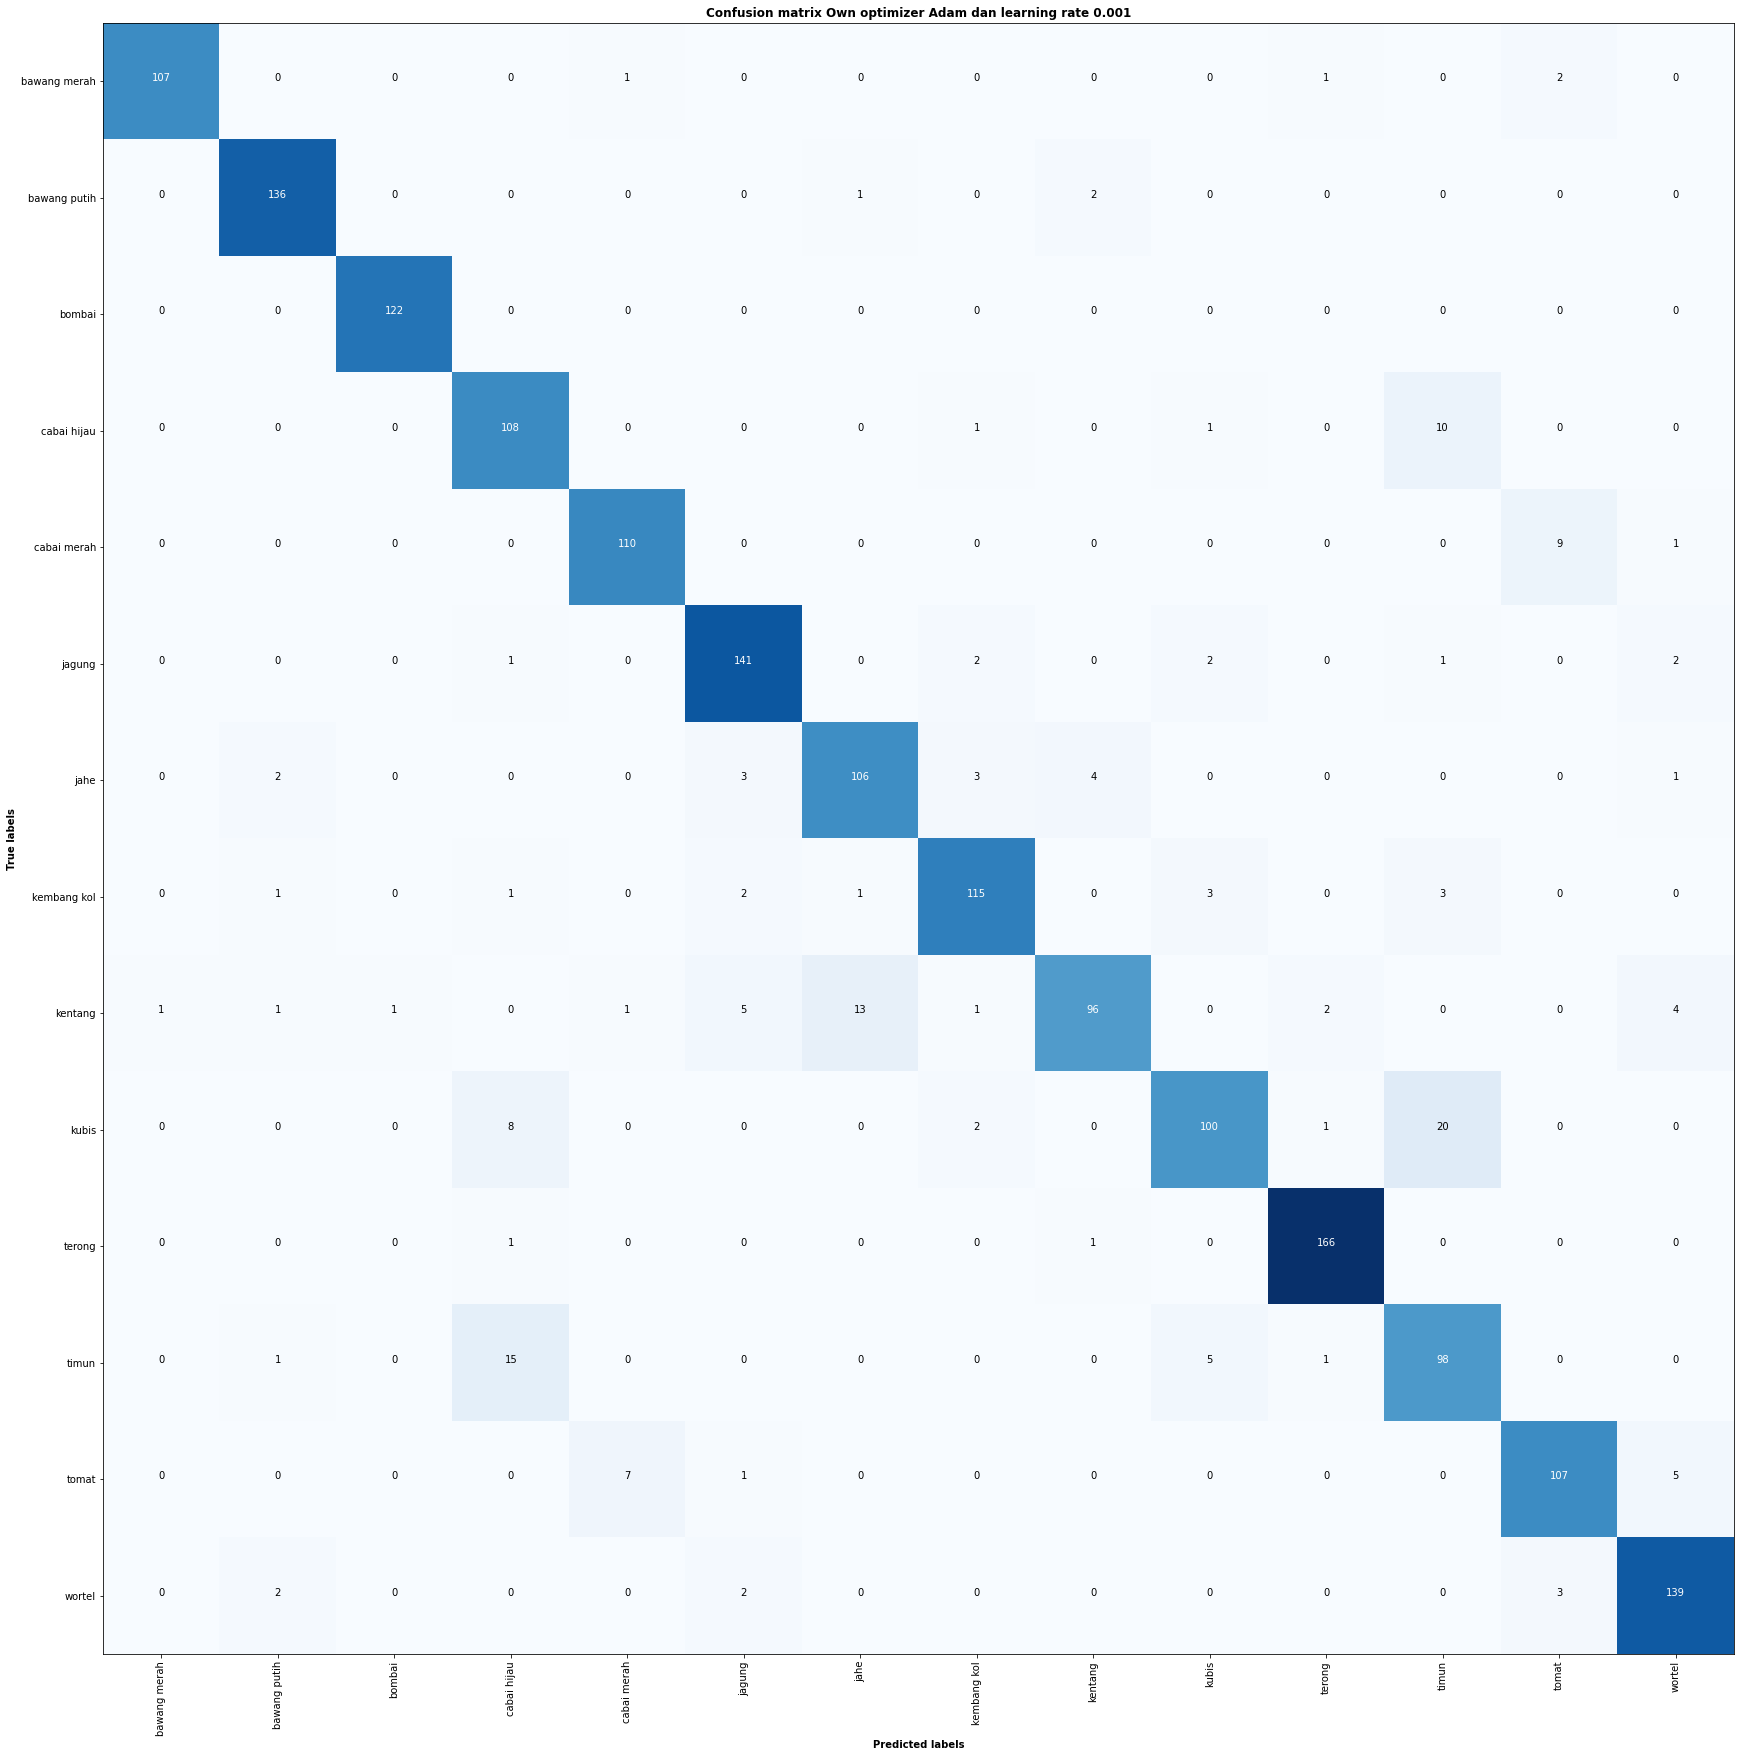

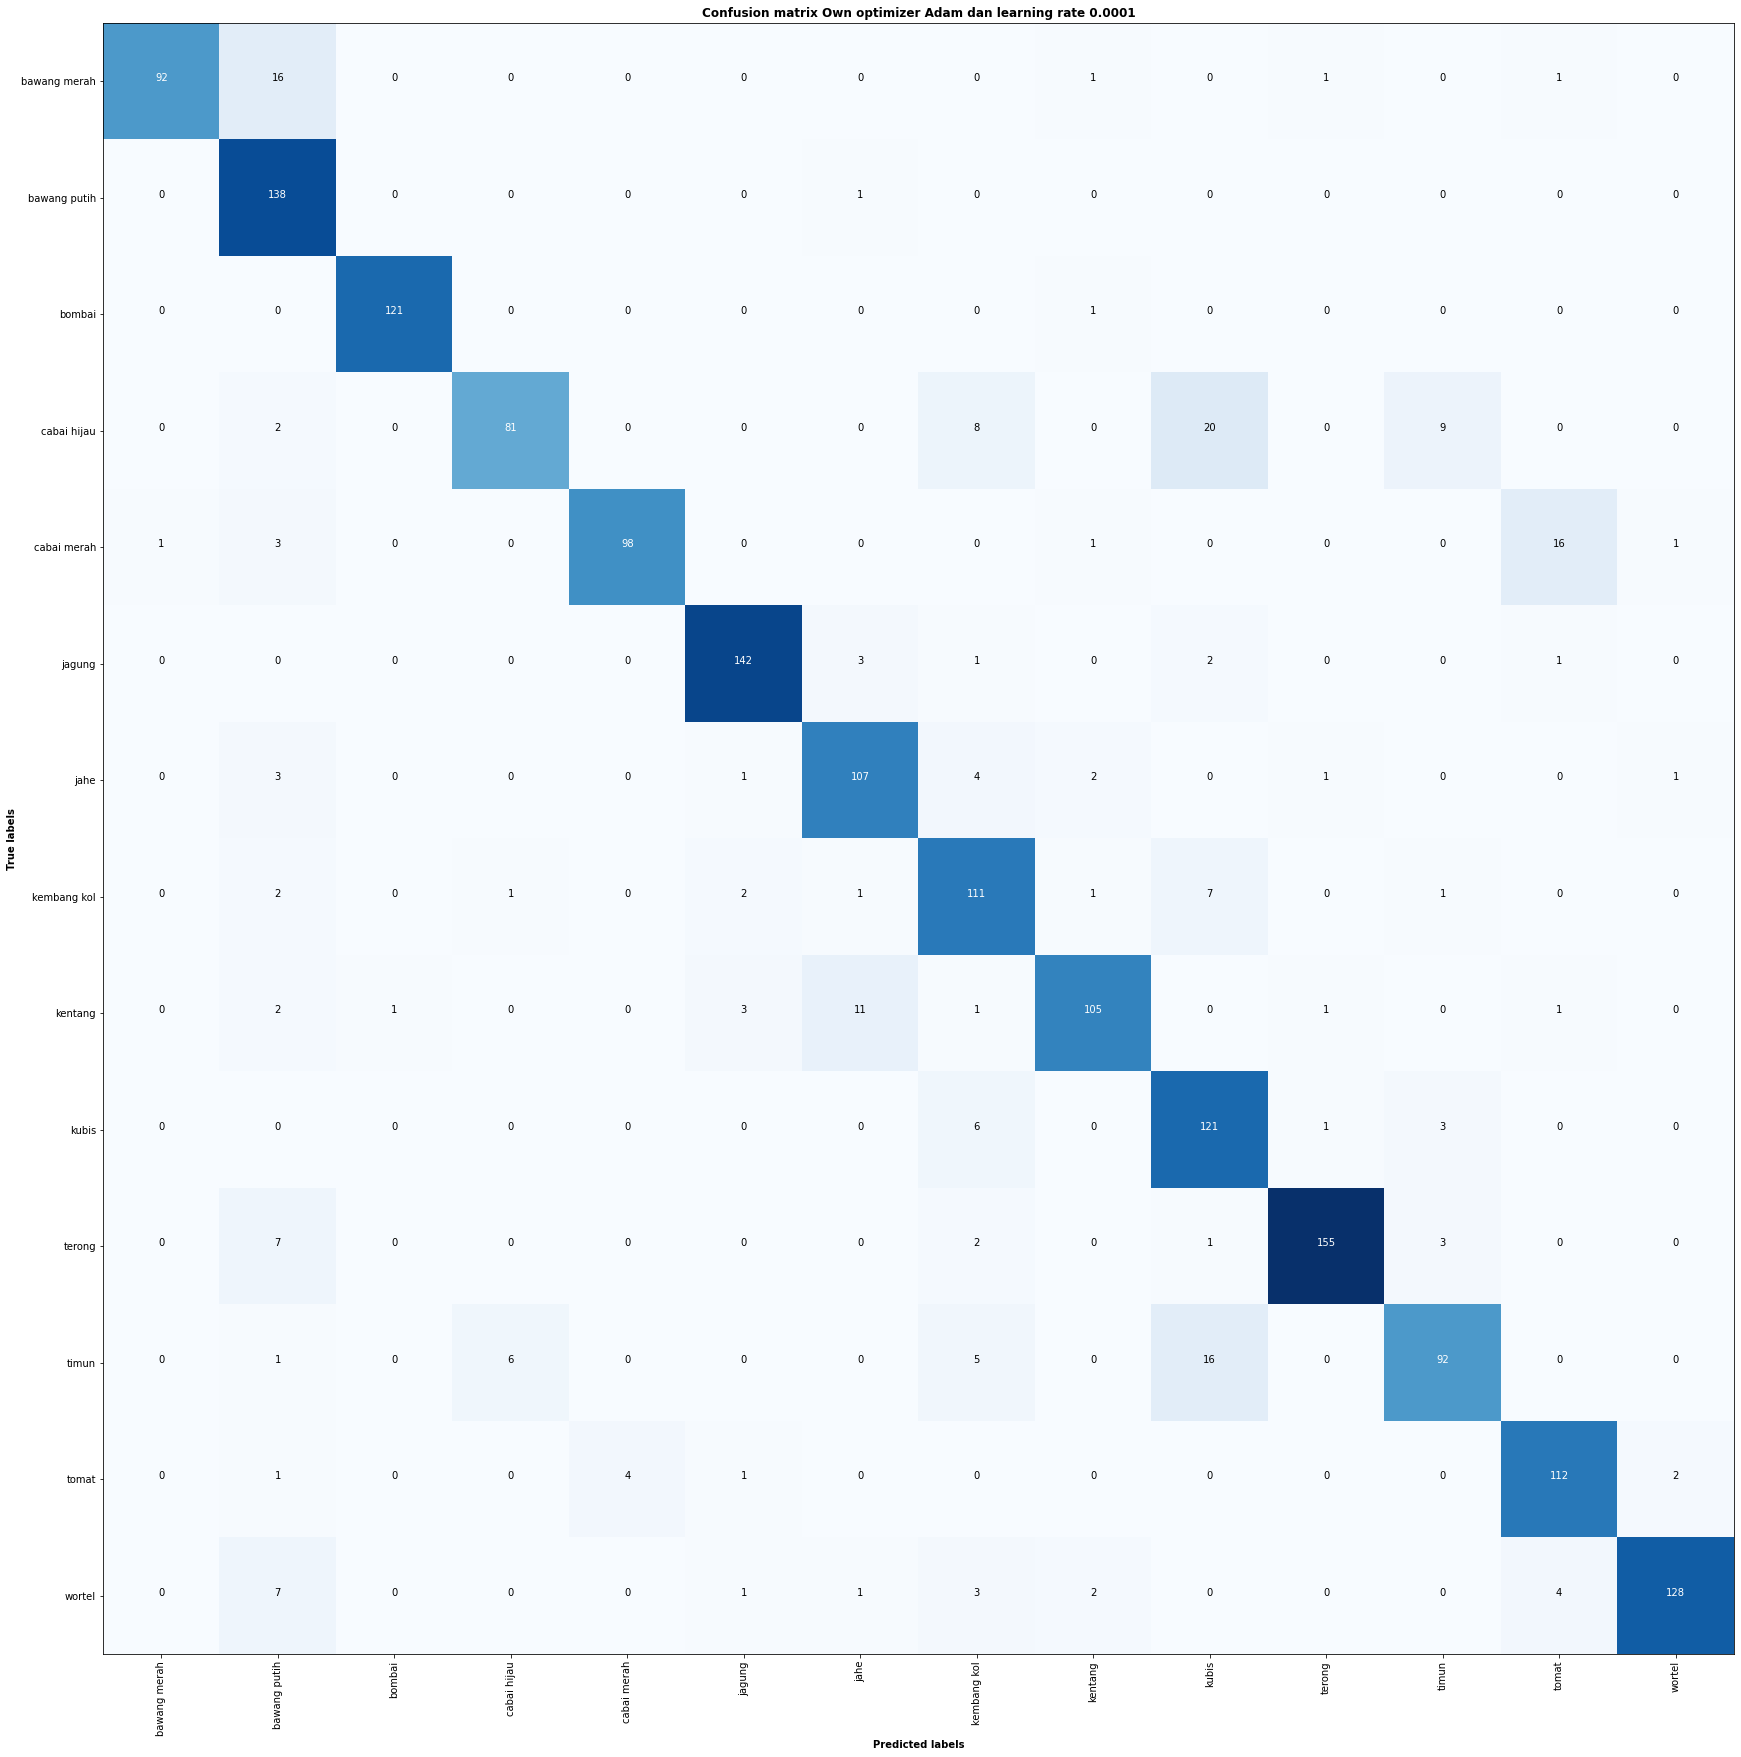

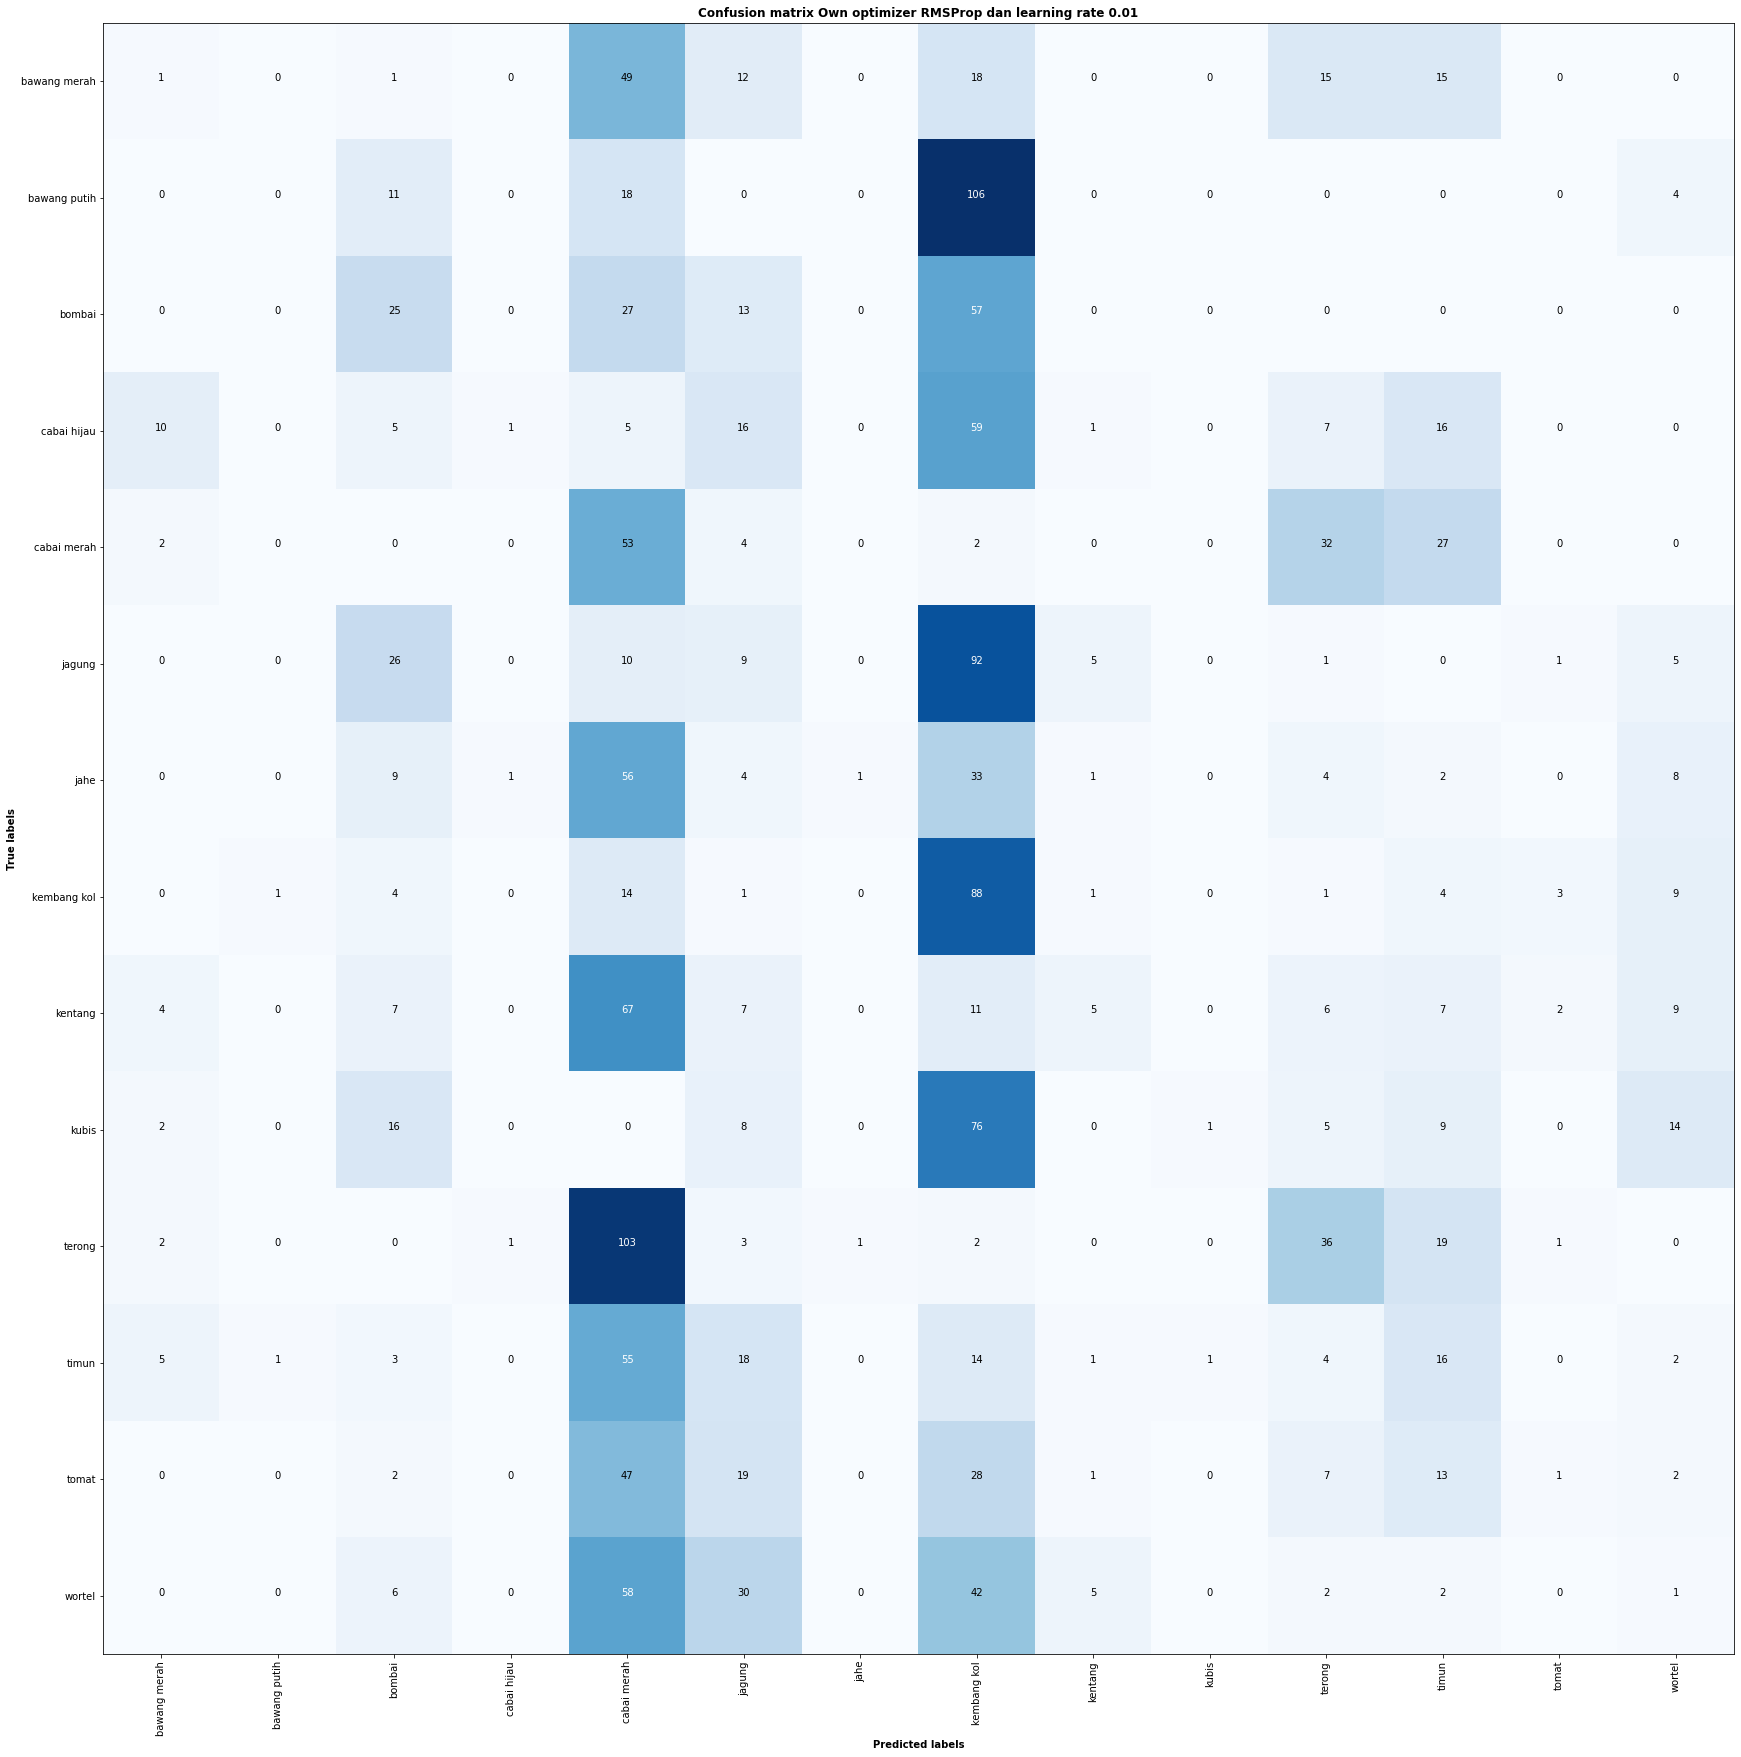

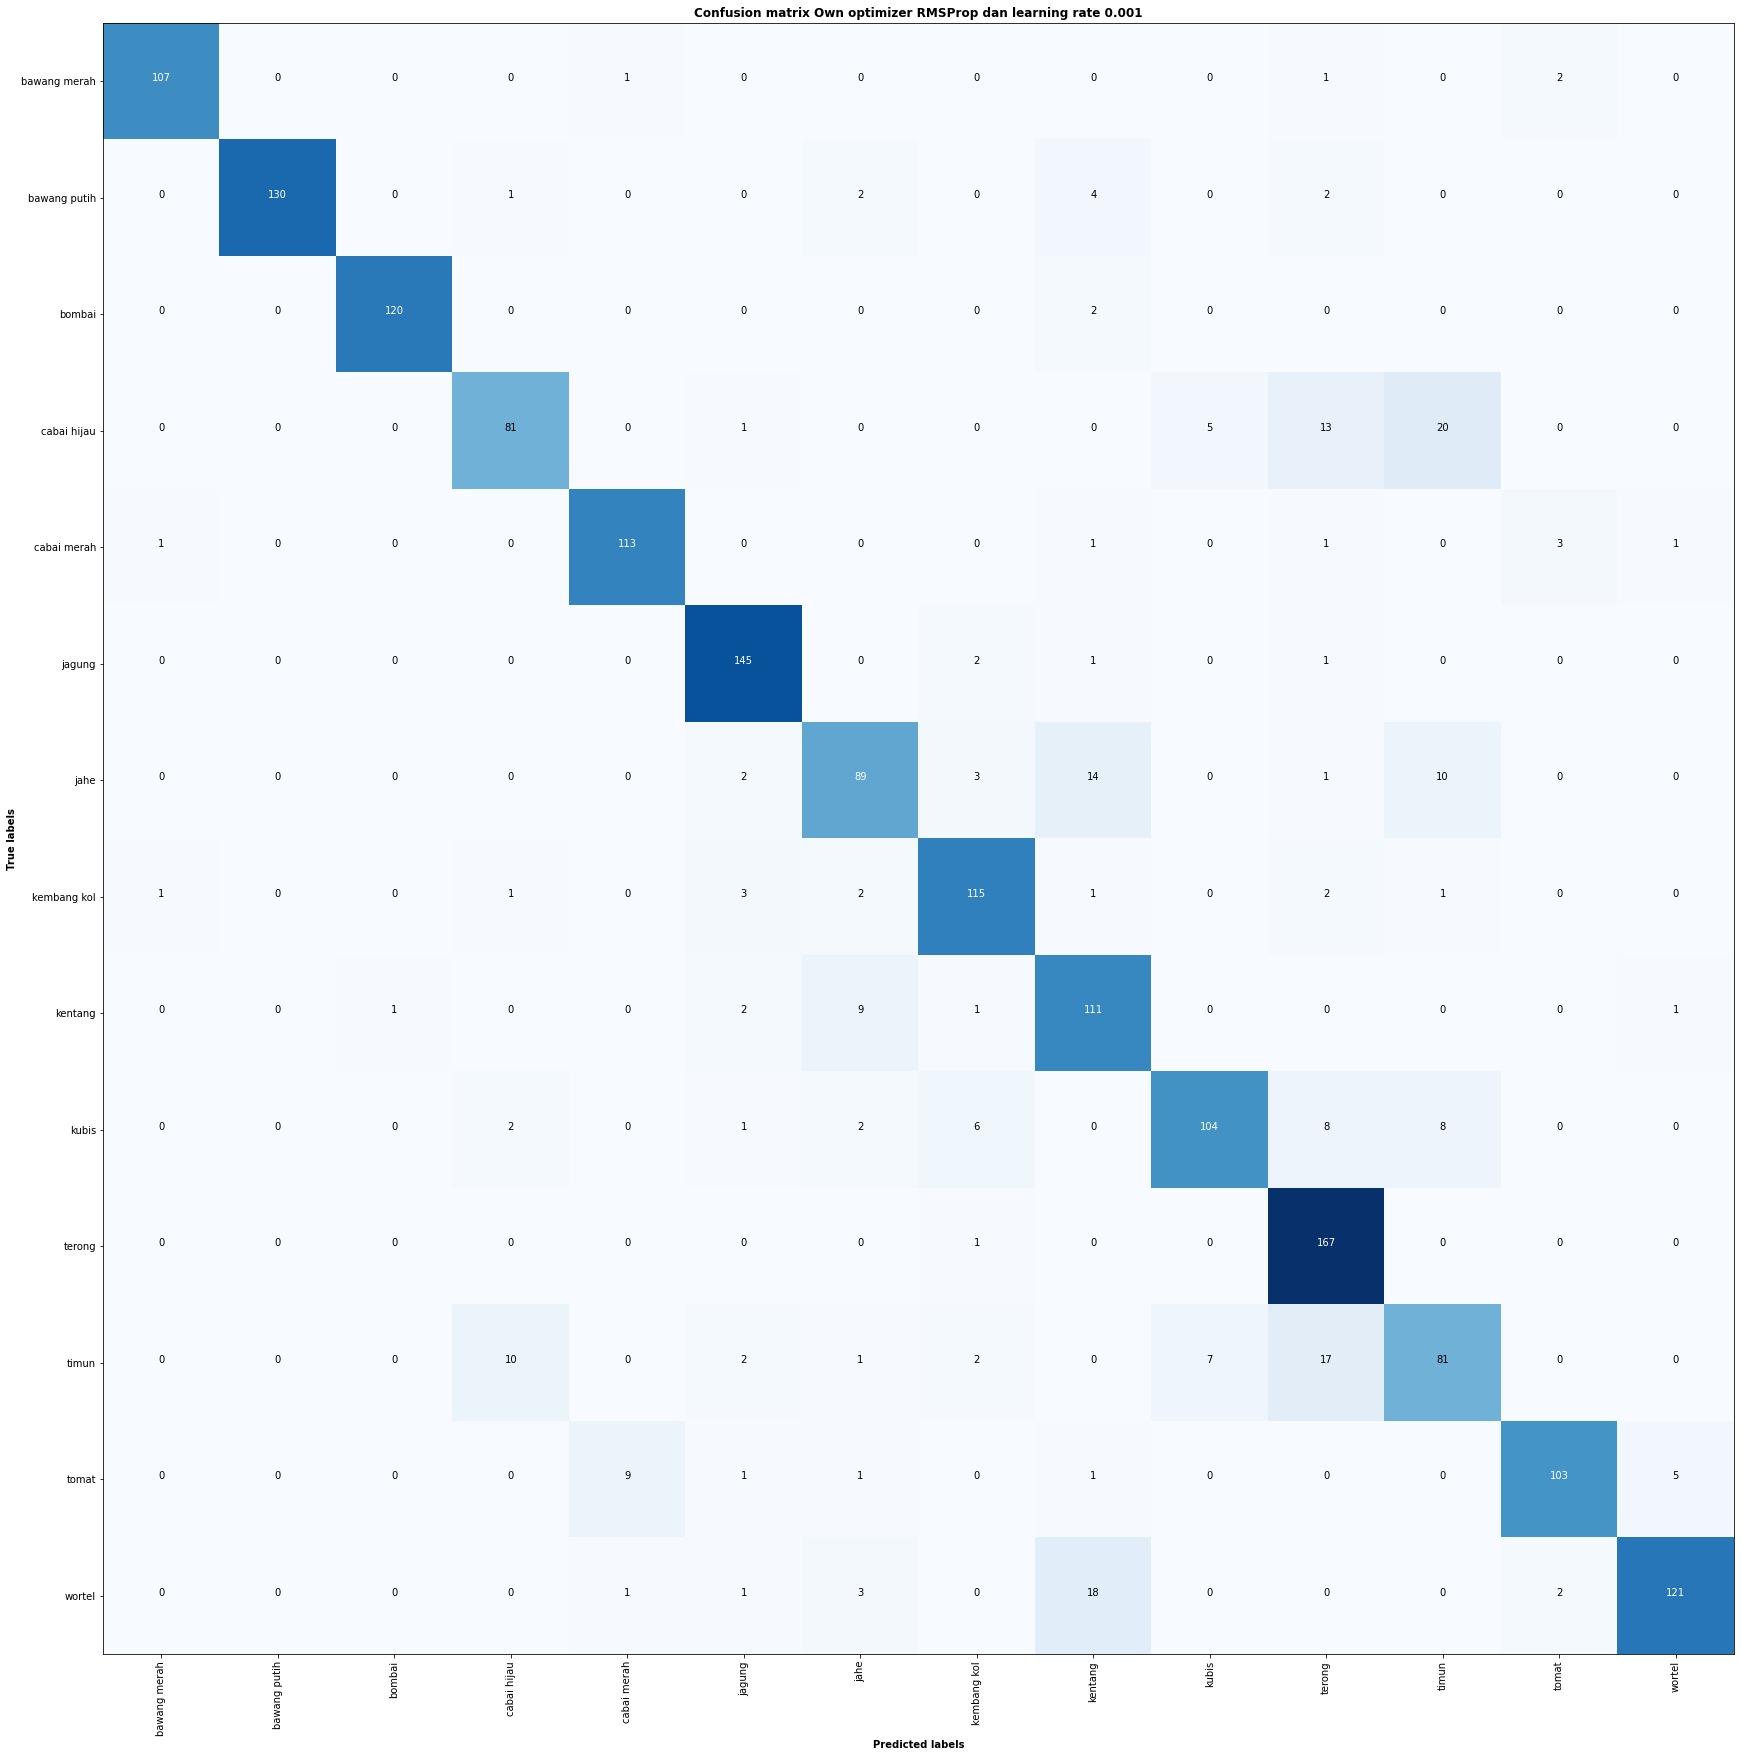

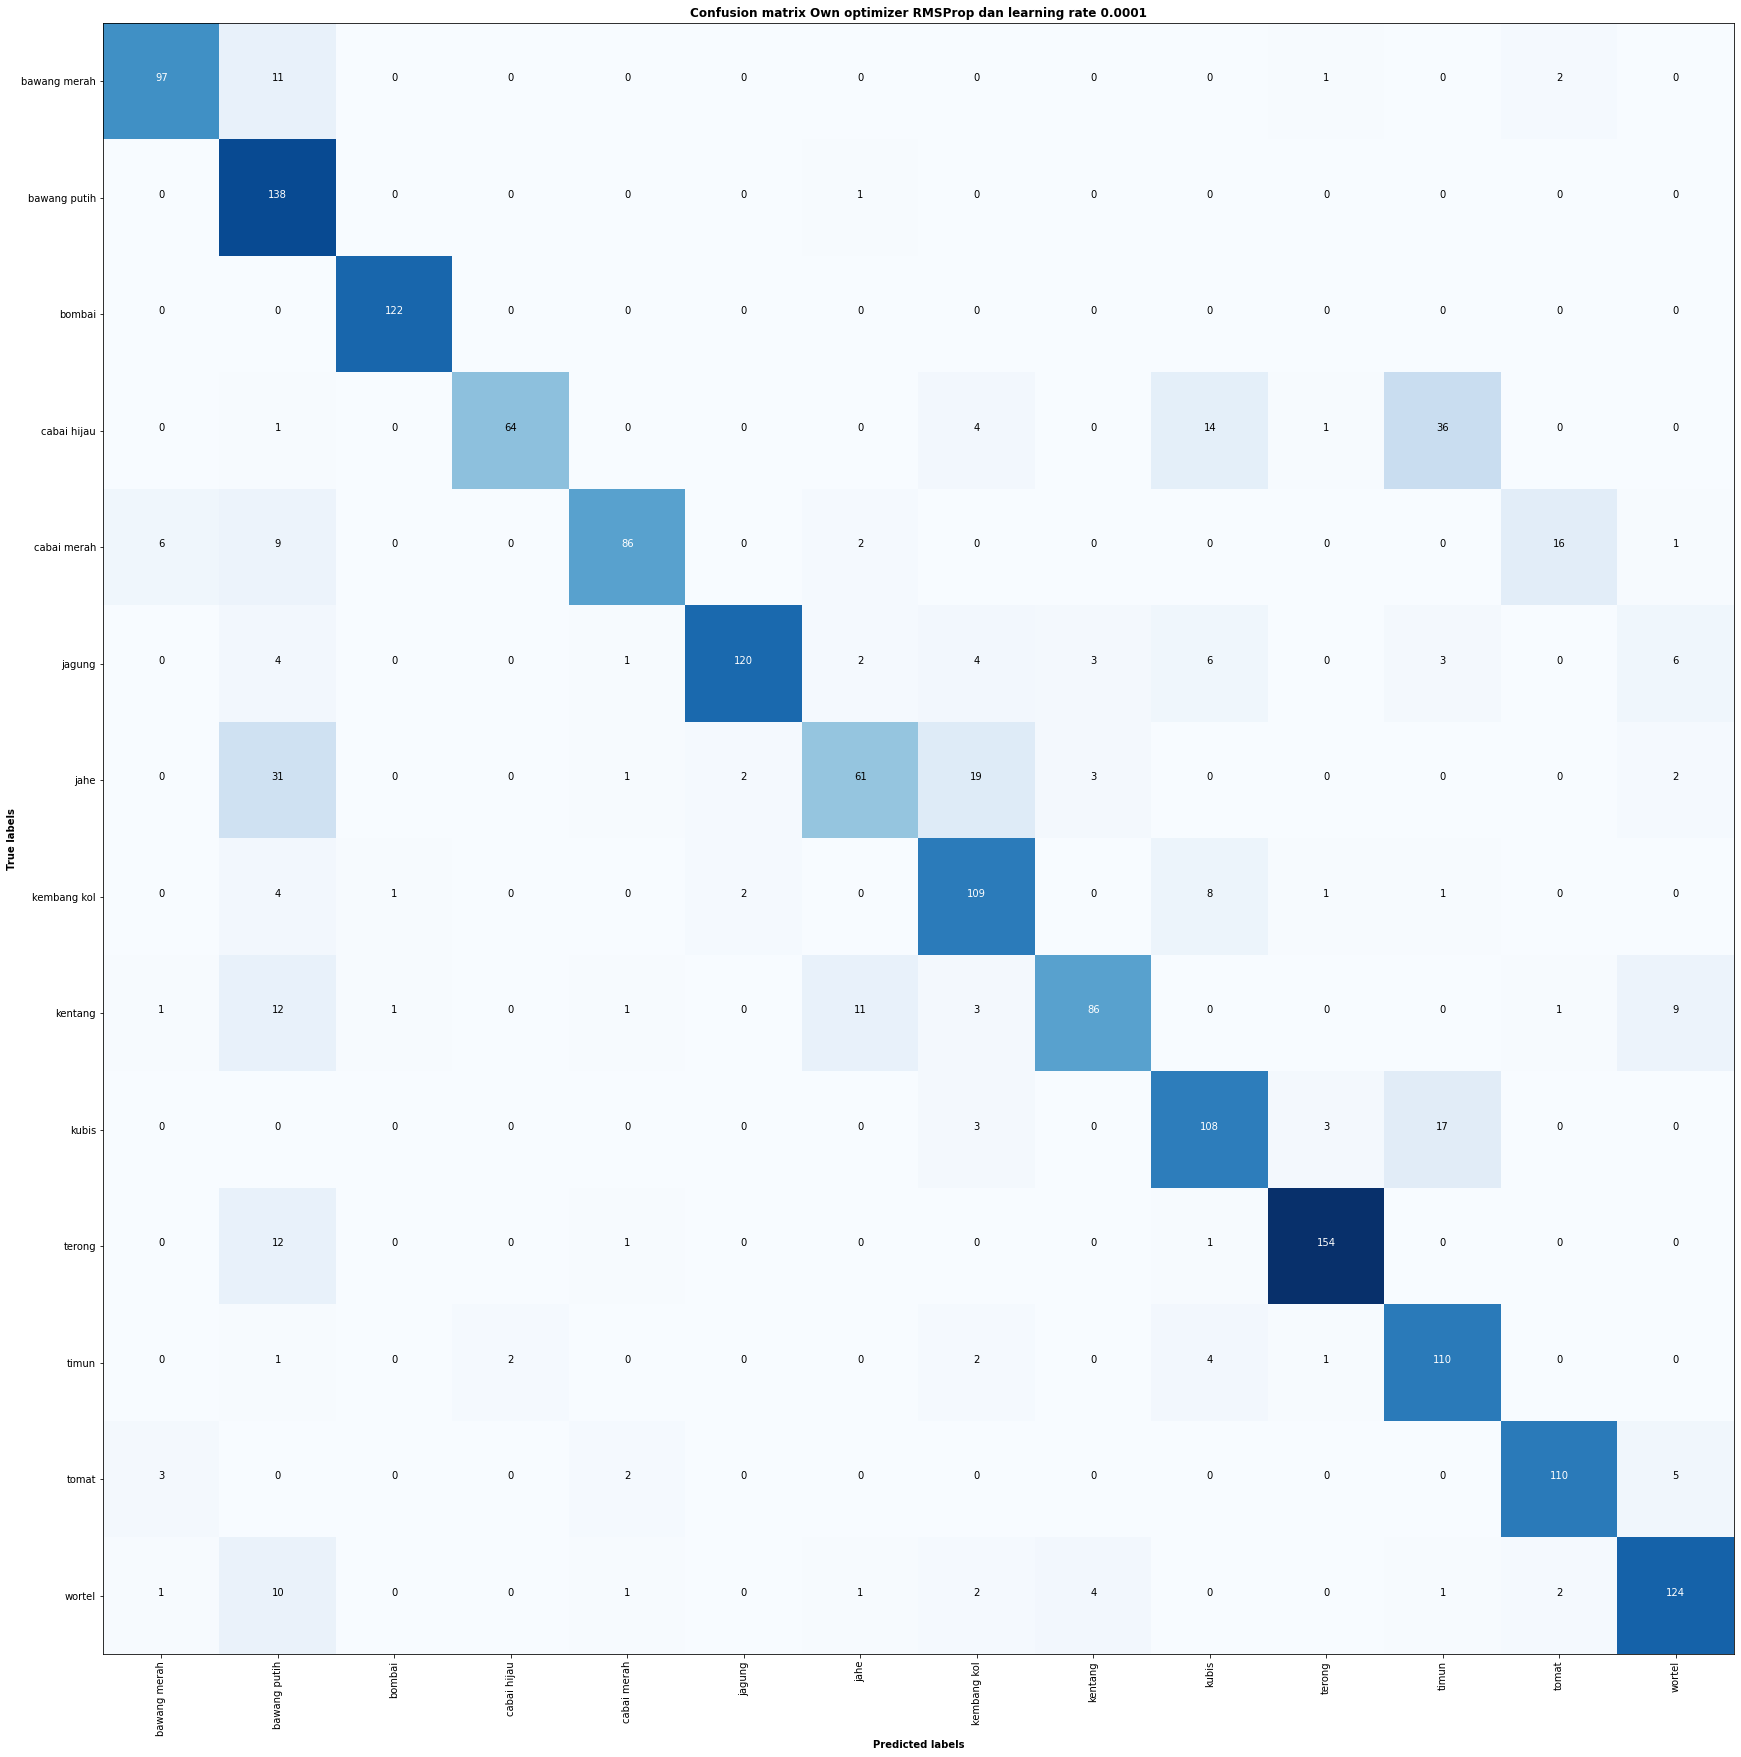

In [ ]:
# Visualisasi menggunakan confusion matrix
for (x, y, z) in (zip(res_predict, opt, lr)):
  preds = np.argmax(x, axis=1) # mengubah matrix ke array
  plot_confusion_matrix(confusion_matrix(true_classes, preds), class_labels, f"Own optimizer {y} dan learning rate {z}")

### 6.4 Visualisasi Hasil Prediksi Model Terbaik

In [ ]:
img = tf.keras.utils.load_img('/content/dataset/split_70_30/val/bawang merah/034_688eb6ef.jpg')
imgplot = plt.imshow(img)

In [ ]:
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels = list(labels.values())
labels

['bawang merah',
 'bawang putih',
 'bombai',
 'cabai hijau',
 'cabai merah',
 'jagung',
 'jahe',
 'kembang kol',
 'kentang',
 'kubis',
 'terong',
 'timun',
 'tomat',
 'wortel']

In [ ]:
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels = list(labels.values())

%matplotlib inline
import numpy as np
from google.colab import files
from keras.utils import load_img

path = '/content/dataset/split_70_30/val/terong/117_dba350df.jpg'
img = keras.utils.load_img(path, target_size=(224,224))
x = keras.utils.img_to_array(img)
plt.imshow(x/255.)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model_mobilenet_adam1.predict(images, batch_size=10)
print(classes[0])
print(labels[np.argmax(classes[0])])

# **EXPORT BEST MODEL**

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_mobilenet_adam1)
tflite_model = converter.convert()
open("model_mobilenet_adam1"+".tflite", "wb").write(tflite_model)

9662120